# In this notebook we will be implmenting our own models and understanding of the ckd problem and comparing them to the articles in terms of result interpretation and robustness

In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support, precision_score, recall_score
#classes = ['CKD', 'NCKD']

In [2]:
# this segment is reserved for usage on google colab
# it is used to be able to import the data
from google.colab import files
uploaded = files.upload()

Saving csv_result-chronic_kidney_disease.csv to csv_result-chronic_kidney_disease.csv


In [3]:
dataset = read_csv("csv_result-chronic_kidney_disease.csv")
dataset.head()

'age' 'bp'   'sg' 'al' 'su'   'rbc'      'pc'       'pcc'        'ba' 'bgr'  \
0    48   80   1.02    1    0       ?    normal  notpresent  notpresent   121   
1     7   50   1.02    4    0       ?    normal  notpresent  notpresent     ?   
2    62   80   1.01    2    3  normal    normal  notpresent  notpresent   423   
3    48   70  1.005    4    0  normal  abnormal     present  notpresent   117   
4    51   80   1.01    2    0  normal    normal  notpresent  notpresent   106   

   ... 'wbcc' 'rbcc' 'htn' 'dm' 'cad' 'appet' 'pe' 'ane' 'class' Unnamed: 25  
0  ...   7800    5.2   yes  yes    no    good   no    no     ckd         NaN  
1  ...   6000      ?    no   no    no    good   no    no     ckd         NaN  
2  ...   7500      ?    no  yes    no    poor   no   yes     ckd         NaN  
3  ...   6700    3.9   yes   no    no    poor  yes   yes     ckd         NaN  
4  ...   7300    4.6    no   no    no    good   no    no     ckd         NaN  

[5 rows x 26 columns]

In [4]:
#As the dataset was originally in .arff extention when converting to csv it automatically added an extra empty column to compensate for the issue it has with extra ,
# we will drop this extra column
dataset.drop(columns=dataset.columns[-1], 
        axis=1, 
        inplace=True)

In [5]:
# let's take a look at the shape of the dataset
dataset.shape

(400, 25)

In [6]:
# let's take a look at the column names
dataset.columns

Index([''age'', ''bp'', ''sg'', ''al'', ''su'', ''rbc'', ''pc'', ''pcc'',
       ''ba'', ''bgr'', ''bu'', ''sc'', ''sod'', ''pot'', ''hemo'', ''pcv'',
       ''wbcc'', ''rbcc'', ''htn'', ''dm'', ''cad'', ''appet'', ''pe'',
       ''ane'', ''class''],
      dtype='object')

\we can detect that there are extra ' ' on each column name and we can  see that they are the abbreviation of the feature names so let's go ahead and put in the original names








In [7]:
# let's take care of the extra ''
dataset.columns = dataset.columns.str.replace("['']", "")

<ipython-input-7-38f7c09ee5e5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset.columns = dataset.columns.str.replace("['']", "")


In [8]:
# let's provide the original names
cols_names={"bp":"blood_pressure",
          "sg":"specific_gravity",
          "al":"albumin",
          "su":"sugar",
          "rbc":"red_blood_cells",
          "pc":"pus_cell",
          "pcc":"pus_cell_clumps",
          "ba":"bacteria",
          "bgr":"blood_glucose_random",
          "bu":"blood_urea",
          "sc":"serum_creatinine",
          "sod":"sodium",
          "pot":"potassium",
          "hemo":"haemoglobin",
          "pcv":"packed_cell_volume",
          "wbcc":"white_blood_cell_count",
          "rbcc":"red_blood_cell_count",
          "htn":"hypertension",
          "dm":"diabetes_mellitus",
          "cad":"coronary_artery_disease",
          "appet":"appetite",
          "pe":"pedal_edema",
          "ane":"anemia"}

dataset.rename(columns=cols_names, inplace=True)

In [9]:
# now let's make a copy of the dataset to conduct all the experiments on
df=dataset.copy()

In [10]:
df.columns

Index(['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'hypertension',
       'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
       'pedal_edema', 'anemia', 'class'],
      dtype='object')

In [11]:
df.describe()

age blood_pressure specific_gravity albumin sugar red_blood_cells  \
count   400            400              400     400   400             400   
unique   77             11                6       7     7               3   
top      60             80             1.02       0     0          normal   
freq     19            116              106     199   290             201   

       pus_cell pus_cell_clumps    bacteria blood_glucose_random  ...  \
count       400             400         400                  400  ...   
unique        3               3           3                  147  ...   
top      normal      notpresent  notpresent                    ?  ...   
freq        259             354         374                   44  ...   

       packed_cell_volume white_blood_cell_count red_blood_cell_count  \
count                 400                    400                  400   
unique                 43                     90                   46   
top                     ?                      ?                    ?   
freq                   71                    106                  131   

       hypertension diabetes_mellitus coronary_artery_disease appetite  \
count           400               399                     400      400   
unique            3                 3                       3        4   
top              no                no                      no     good   
freq            251               260                     364      316   

       pedal_edema anemia class  
count          400    400   400  
unique           4      3     3  
top             no     no   ckd  
freq           322    339   250  

[4 rows x 25 columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   age                      400 non-null    object
 1   blood_pressure           400 non-null    object
 2   specific_gravity         400 non-null    object
 3   albumin                  400 non-null    object
 4   sugar                    400 non-null    object
 5   red_blood_cells          400 non-null    object
 6   pus_cell                 400 non-null    object
 7   pus_cell_clumps          400 non-null    object
 8   bacteria                 400 non-null    object
 9   blood_glucose_random     400 non-null    object
 10  blood_urea               400 non-null    object
 11  serum_creatinine         400 non-null    object
 12  sodium                   400 non-null    object
 13  potassium                400 non-null    object
 14  haemoglobin              400 non-null    o

We can see from the info() and describe() functions that all the features are in object type and we can also detect instances of '?' in all the features except the our target.
We will start by turning that value into nas

In [13]:
# replace '?' with nans
for i in df.columns:
    df[i] = df[i].replace('?',np.NaN)

What we will move on to do is to separate the numerical features and the categorical ones according to the uci description of the dataset

In [14]:
# let's start by checking how many unique values does each feature have
for i in df.columns:
    print(f'{i} : {df[i].nunique()} values')

age : 76 values
blood_pressure : 10 values
specific_gravity : 5 values
albumin : 6 values
sugar : 6 values
red_blood_cells : 2 values
pus_cell : 2 values
pus_cell_clumps : 2 values
bacteria : 2 values
blood_glucose_random : 146 values
blood_urea : 118 values
serum_creatinine : 84 values
sodium : 34 values
potassium : 40 values
haemoglobin : 115 values
packed_cell_volume : 42 values
white_blood_cell_count : 89 values
red_blood_cell_count : 45 values
hypertension : 2 values
diabetes_mellitus : 2 values
coronary_artery_disease : 2 values
appetite : 3 values
pedal_edema : 3 values
anemia : 2 values
class : 3 values


In [15]:
# let's separate our features into numerical and categorical features according to the dataset desciption
nominal_columns_list = []
numecial_columns_list = []

for i in df.columns:
    if df[i].nunique()>4:
        numecial_columns_list.append(i)
    else:
        nominal_columns_list.append(i)

In [16]:
print('Numerical features: ', numecial_columns_list)
print('\nCategorical features: ', nominal_columns_list)

Numerical features:  ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium', 'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count']

Categorical features:  ['red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia', 'class']


In [17]:
# we will change the types of the numerical data data 
for col in numecial_columns_list:
        df[col]=df[col].astype('float')

In [18]:
# we will check the unique values of the categorical features
for i in nominal_columns_list:
    print(i, df[i].unique())

red_blood_cells [nan 'normal' 'abnormal']
pus_cell ['normal' 'abnormal' nan]
pus_cell_clumps ['notpresent' 'present' nan]
bacteria ['notpresent' 'present' nan]
hypertension ['yes' 'no' nan]
diabetes_mellitus ['yes' 'no' nan]
coronary_artery_disease ['no' 'yes' nan]
appetite ['good' 'poor' nan 'no']
pedal_edema ['no' 'yes' nan 'good']
anemia ['no' 'yes' nan]
class ['ckd' 'notckd' 'no']


apart from the the nan values we can see that a couple of the features have typos. We will change thse typos according to the logical value

In [19]:
# let's change the typo values into appropriate ones
df['appetite'] = df['appetite'].str.replace('no', 'good')
df['pedal_edema'] = df['pedal_edema'].str.replace('good', 'no')
df['class'] = df['class'].replace('no', 'notckd')

In [20]:
df

age  blood_pressure  specific_gravity  albumin  sugar red_blood_cells  \
0    48.0            80.0             1.020      1.0    0.0             NaN   
1     7.0            50.0             1.020      4.0    0.0             NaN   
2    62.0            80.0             1.010      2.0    3.0          normal   
3    48.0            70.0             1.005      4.0    0.0          normal   
4    51.0            80.0             1.010      2.0    0.0          normal   
..    ...             ...               ...      ...    ...             ...   
395  55.0            80.0             1.020      0.0    0.0          normal   
396  42.0            70.0             1.025      0.0    0.0          normal   
397  12.0            80.0             1.020      0.0    0.0          normal   
398  17.0            60.0             1.025      0.0    0.0          normal   
399  58.0            80.0             1.025      0.0    0.0          normal   

     pus_cell pus_cell_clumps    bacteria  blood_glucose_random  ...  \
0      normal      notpresent  notpresent                 121.0  ...   
1      normal      notpresent  notpresent                   NaN  ...   
2      normal      notpresent  notpresent                 423.0  ...   
3    abnormal         present  notpresent                 117.0  ...   
4      normal      notpresent  notpresent                 106.0  ...   
..        ...             ...         ...                   ...  ...   
395    normal      notpresent  notpresent                 140.0  ...   
396    normal      notpresent  notpresent                  75.0  ...   
397    normal      notpresent  notpresent                 100.0  ...   
398    normal      notpresent  notpresent                 114.0  ...   
399    normal      notpresent  notpresent                 131.0  ...   

     packed_cell_volume  white_blood_cell_count  red_blood_cell_count  \
0                  44.0                  7800.0                   5.2   
1                  38.0                  6000.0                   NaN   
2                  31.0                  7500.0                   NaN   
3                  32.0                  6700.0                   3.9   
4                  35.0                  7300.0                   4.6   
..                  ...                     ...                   ...   
395                47.0                  6700.0                   4.9   
396                54.0                  7800.0                   6.2   
397                49.0                  6600.0                   5.4   
398                51.0                  7200.0                   5.9   
399                53.0                  6800.0                   6.1   

     hypertension  diabetes_mellitus  coronary_artery_disease  appetite  \
0             yes                yes                       no      good   
1              no                 no                       no      good   
2              no                yes                       no      poor   
3             yes                 no                       no      poor   
4              no                 no                       no      good   
..            ...                ...                      ...       ...   
395            no                 no                       no      good   
396            no                 no                       no      good   
397            no                 no                       no      good   
398            no                 no                       no      good   
399            no                 no                       no      good   

     pedal_edema anemia   class  
0             no     no     ckd  
1             no     no     ckd  
2             no    yes     ckd  
3            yes    yes     ckd  
4             no     no     ckd  
..           ...    ...     ...  
395           no     no  notckd  
396           no     no  notckd  
397           no     no  notckd  
398           no     no  notckd  
399           no     no  notckd  

[400 

let's take a brief look at the data distribution of the features

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

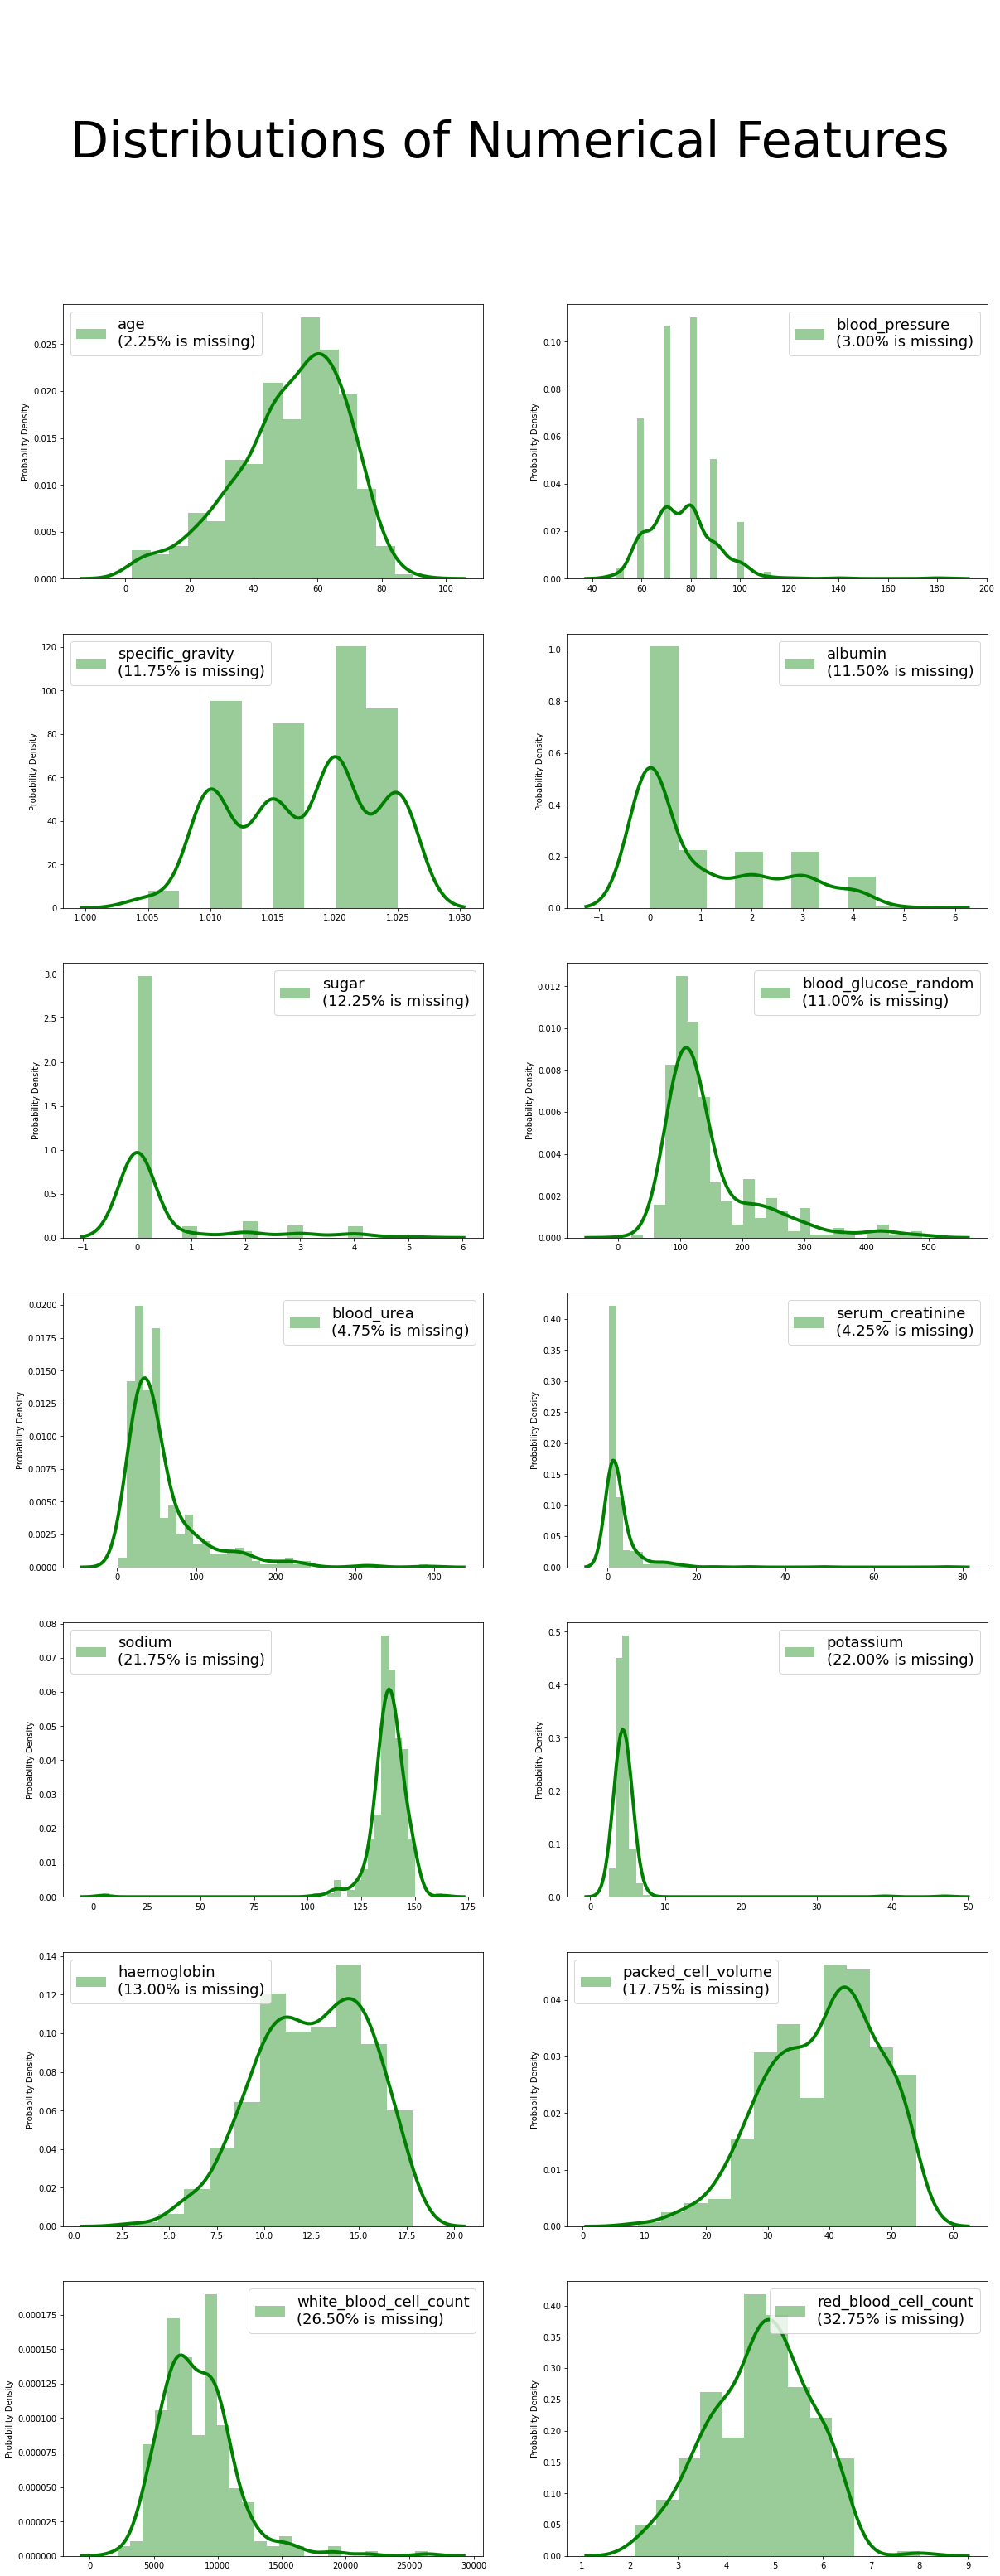

In [21]:
n_rows, n_cols = (7,2)

figure, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(20, 50))
figure.suptitle('\n\nDistributions of Numerical Features', fontsize=60)

for index, column in enumerate(numecial_columns_list):
    
    i,j = (index // n_cols), (index % n_cols)
    
    miss_perc="%.2f"%(100*(1-(df[column].dropna().shape[0])/df.shape[0]))
    
    collabel=column+"\n({}% is missing)".format(miss_perc)
    
    fig=sns.distplot(df[column], color="g", label=collabel, norm_hist=True,
    
    ax=axes[i,j], kde_kws={"lw":4})
    
    fig=fig.legend(loc='best', fontsize=18)
    
    axes[i,j].set_ylabel("Probability Density",fontsize='medium')
    
    axes[i,j].set_xlabel(None)

plt.show()

Some features show some very distant outliers.
Some others have discrete values, but I'll be treating them like continuous ones.
The reason being is that these are measures of biological variables which are in reality continuous.
Them being discrete is probably due to the method they've been measured with.
Some features have high proportions of missing values, thus they cannot be imputed with measures of central tendency. That would distort their distributions.
Plus, some features are very skewed while others are almost normal, some have a very distinct mode while some don't. Which means even if we didn't have so many missing values, we'd have to deal with each feature separately.

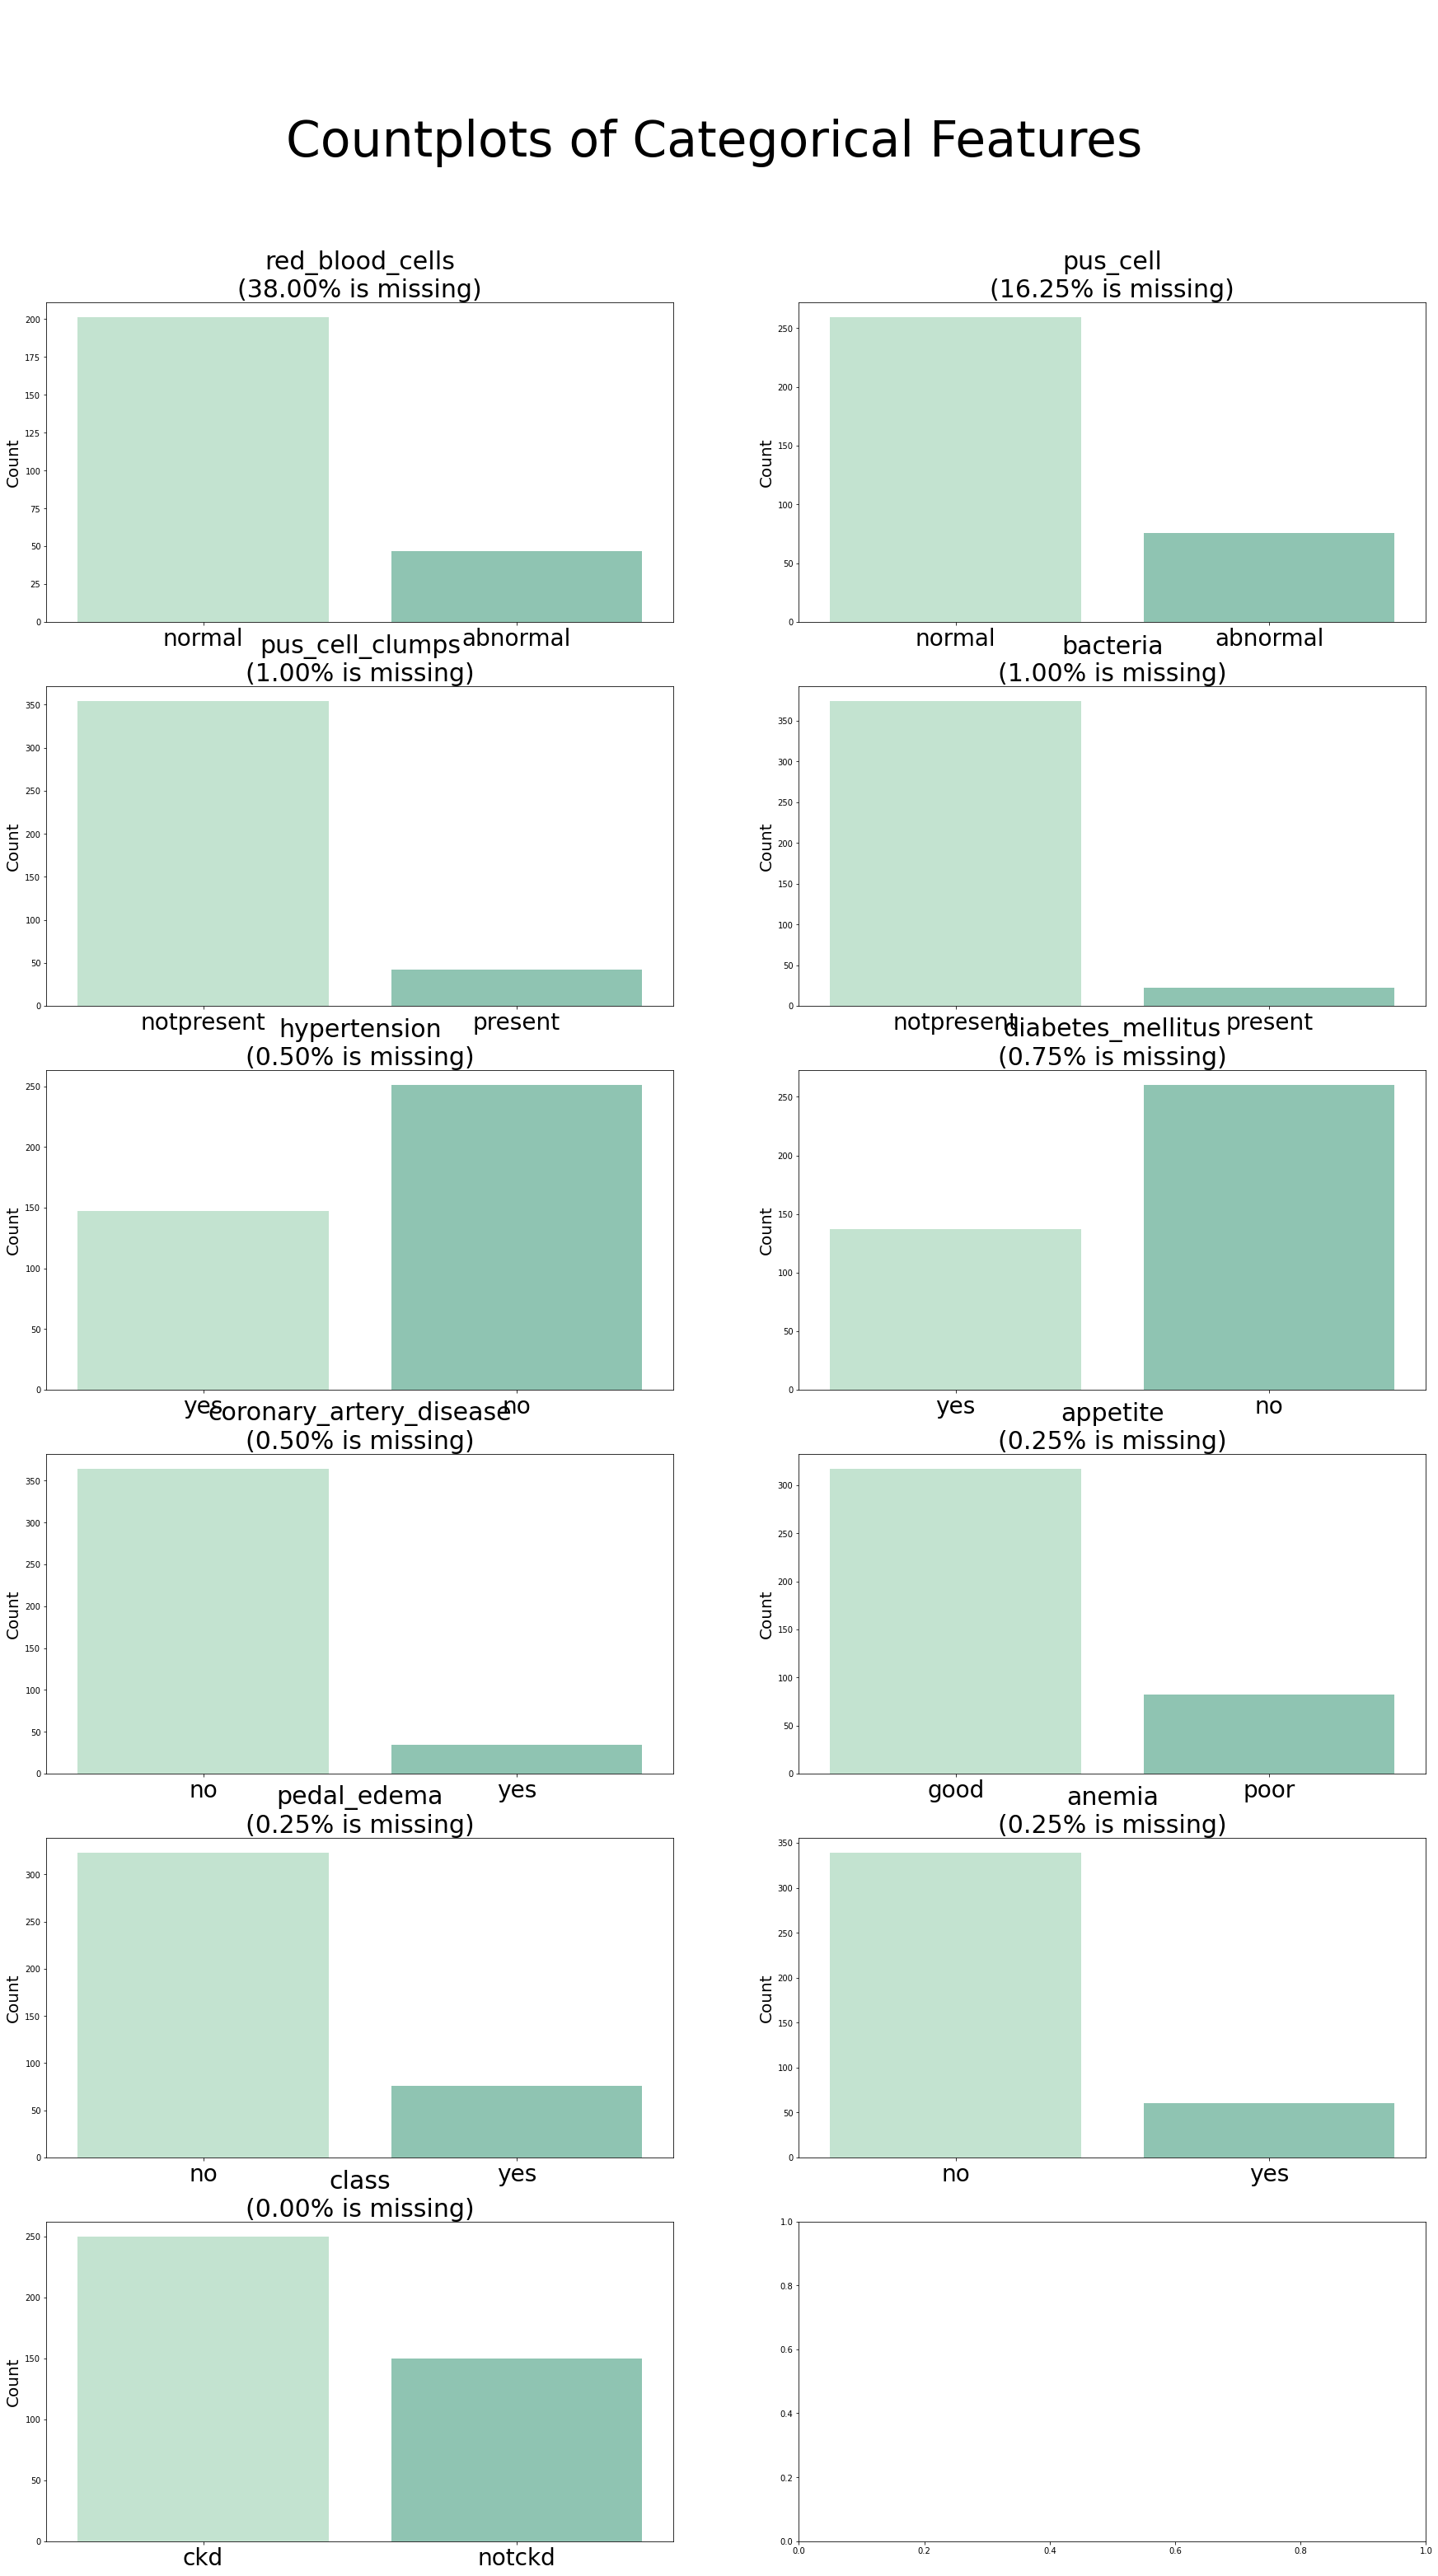

In [22]:
n_rows, n_cols = (6,2)

figure, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(30, 50))
figure.suptitle('\n\nCountplots of Categorical Features', fontsize=60)

for index, column in enumerate(nominal_columns_list):
    
    i,j = index // n_cols, index % n_cols
    
    miss_perc="%.2f"%(100*(1-(df[column].dropna().shape[0])/df.shape[0]))
    
    collabel=column+"\n({}% is missing)".format(miss_perc)
    
    fig = sns.countplot(x=column, data=df,label=collabel, palette=sns.cubehelix_palette(rot=-.35,light=0.85,hue=1),
    
    ax=axes[i,j])
    
    axes[i,j].set_title(collabel,fontsize=30)
    
    axes[i,j].set_xlabel(None)
    
    axes[i,j].set_ylabel("Count",fontsize=20)
    
    axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), Fontsize=28)

plt.show()

Some features have very high percentages of missing values while some have almost none.
Certain abnormalities/diseases seem relatively commun in this dataset, such as diabetes and hypertension.

Now that we have our information in order, we need to take care of the missing values

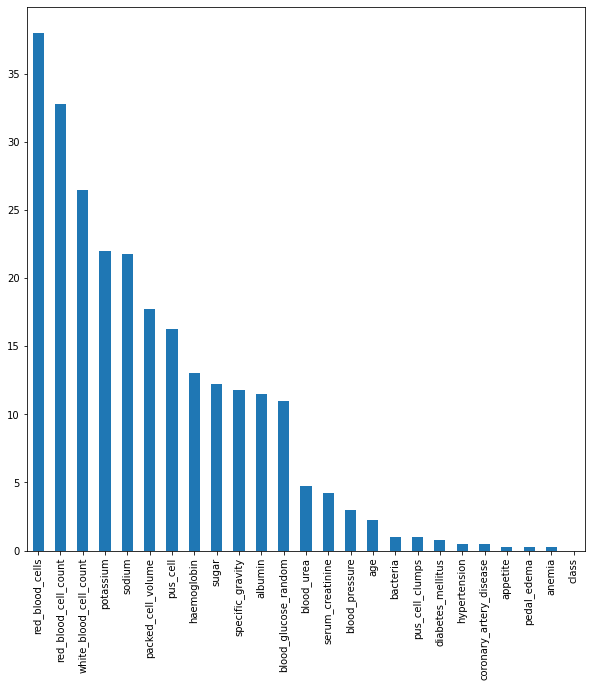

In [23]:
# lets plot the percentage of the missing values
((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False).plot(kind='bar', figsize=(10,10))

In [43]:
import plotly.express as px
#for i in df.columns:
px.scatter(df, x='age', y="haemoglobin", color="class", marginal_y="violin", marginal_x="box")


We chose to use KNN for imputation as i is robust and would not cause a deviation in the distribution.
But we have to encode the categorical features first.
As every categorical feature has only 2 values, One-Hot Encoding is usualy the way to go as it won't be increasing dimensions but because it would also cause the nans to be encodes, we will opt for the ordinal encoder instead.

In [44]:
from sklearn.preprocessing import OrdinalEncoder
ode = OrdinalEncoder(dtype = int)
def encode(data):
    '''function to encode non-nan data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = ode.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#loop through each categorical column in the data
for columns in nominal_columns_list:
    encode(df[columns])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:



In [45]:
df.head(30).T

0       1       2       3       4       5   \
age                        48.0     7.0    62.0    48.0    51.0    60.0   
blood_pressure             80.0    50.0    80.0    70.0    80.0    90.0   
specific_gravity           1.02    1.02    1.01   1.005    1.01   1.015   
albumin                     1.0     4.0     2.0     4.0     2.0     3.0   
sugar                       0.0     0.0     3.0     0.0     0.0     0.0   
red_blood_cells             NaN     NaN       1       1       1     NaN   
pus_cell                      1       1       1       0       1     NaN   
pus_cell_clumps               0       0       0       1       0       0   
bacteria                      0       0       0       0       0       0   
blood_glucose_random      121.0     NaN   423.0   117.0   106.0    74.0   
blood_urea                 36.0    18.0    53.0    56.0    26.0    25.0   
serum_creatinine            1.2     0.8     1.8     3.8     1.4     1.1   
sodium                      NaN     NaN     NaN   111.0     NaN   142.0   
potassium                   NaN     NaN     NaN     2.5     NaN     3.2   
haemoglobin                15.4    11.3     9.6    11.2    11.6    12.2   
packed_cell_volume         44.0    38.0    31.0    32.0    35.0    39.0   
white_blood_cell_count   7800.0  6000.0  7500.0  6700.0  7300.0  7800.0   
red_blood_cell_count        5.2     NaN     NaN     3.9     4.6     4.4   
hypertension                  1       0       0       1       0       1   
diabetes_mellitus             1       0       1       0       0       1   
coronary_artery_disease       0       0       0       0       0       0   
appetite                      0       0       1       1       0       0   
pedal_edema                   0       0       0       1       0       1   
anemia                        0       0       1       1       0       0   
class                         0       0       0       0       0       0   

                            6       7       8        9   ...      20      21  \
age                       68.0    24.0    52.0     53.0  ...    61.0    60.0   
blood_pressure            70.0     NaN   100.0     90.0  ...    80.0    90.0   
specific_gravity          1.01   1.015   1.015     1.02  ...   1.015     NaN   
albumin                    0.0     2.0     3.0      2.0  ...     2.0     NaN   
sugar                      0.0     4.0     0.0      0.0  ...     0.0     NaN   
red_blood_cells            NaN       1       1        0  ...       0     NaN   
pus_cell                     1       0       0        0  ...       0     NaN   
pus_cell_clumps              0       0       1        1  ...       0       0   
bacteria                     0       0       0        0  ...       0       0   
blood_glucose_random     100.0   410.0   138.0     70.0  ...   173.0     NaN   
blood_urea                54.0    31.0    60.0    107.0  ...   148.0   180.0   
serum_creatinine          24.0     1.1     1.9      7.2  ...     3.9    76.0   
sodium                   104.0     NaN     NaN    114.0  ...   135.0     4.5   
potassium                  4.0     NaN     NaN      3.7  ...     5.2     NaN   
haemoglobin               12.4    12.4    10.8      9.5  ...     7.7    10.9   
packed_cell_volume        36.0    44.0    33.0     29.0  ...    24.0    32.0   
white_blood_cell_count     NaN  6900.0  9600.0  12100.0  ...  9200.0  6200.0   
red_blood_cell_count       NaN     5.0     4.0      3.7  ...     3.2     3.6   
hypertension                 0       0       1        1  ...       1       1   
diabetes_mellitus            0       1       1        1  ...       1       1   
coronary_artery_disease      0       0       0        0  ...       1       1   
appetite                     0       0       0        1  ...       1       0   
pedal_edema                  0       1       0        0  ...       1       0   
anemia                       0       0       1        1  ...       1       0   
class                        0       0       0        0  ...       0       0  

Let's take a look at the nan distribution of the numerical and nominal features

In [46]:
# let's check the number of missing values that each column has
for i in numecial_columns_list:
  print("the number of missing values for", i," is:", df[i].isnull().sum())
print("-----------------------------------")
for i in nominal_columns_list:
  print("the number of missing values for", i," is:", df[i].isnull().sum())
# lets check the sum of all nans on the dataset
print("the sum of all missing values on the dataset is: ", df.isnull().sum().sum())

the number of missing values for age  is: 9
the number of missing values for blood_pressure  is: 12
the number of missing values for specific_gravity  is: 47
the number of missing values for albumin  is: 46
the number of missing values for sugar  is: 49
the number of missing values for blood_glucose_random  is: 44
the number of missing values for blood_urea  is: 19
the number of missing values for serum_creatinine  is: 17
the number of missing values for sodium  is: 87
the number of missing values for potassium  is: 88
the number of missing values for haemoglobin  is: 52
the number of missing values for packed_cell_volume  is: 71
the number of missing values for white_blood_cell_count  is: 106
the number of missing values for red_blood_cell_count  is: 131
-----------------------------------
the number of missing values for red_blood_cells  is: 152
the number of missing values for pus_cell  is: 65
the number of missing values for pus_cell_clumps  is: 4
the number of missing values for b

Let's take a look at the values count of the nominal data

In [47]:
# let's check the unique values
for var in nominal_columns_list:
        print(f"- {var} : ")
        print(df[var].value_counts())
        print("----------------------")

- red_blood_cells : 
1    201
0     47
Name: red_blood_cells, dtype: int64
----------------------
- pus_cell : 
1    259
0     76
Name: pus_cell, dtype: int64
----------------------
- pus_cell_clumps : 
0    354
1     42
Name: pus_cell_clumps, dtype: int64
----------------------
- bacteria : 
0    374
1     22
Name: bacteria, dtype: int64
----------------------
- hypertension : 
0    251
1    147
Name: hypertension, dtype: int64
----------------------
- diabetes_mellitus : 
0    260
1    137
Name: diabetes_mellitus, dtype: int64
----------------------
- coronary_artery_disease : 
0    364
1     34
Name: coronary_artery_disease, dtype: int64
----------------------
- appetite : 
0    317
1     82
Name: appetite, dtype: int64
----------------------
- pedal_edema : 
0    323
1     76
Name: pedal_edema, dtype: int64
----------------------
- anemia : 
0    339
1     60
Name: anemia, dtype: int64
----------------------
- class : 
0    250
1    150
Name: class, dtype: int64
-------------------

Let's take a look at the value count of the numerical features

In [ ]:
# let's check the unique values
for var in numecial_columns_list:
        print(f"- {var} : ")
        print(df[var].value_counts())
        print("----------------------")

let's use the knn imputer to reolace the missing values

In [49]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=8)
# we will impute the data and then put in a dataframe once again
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

Let's take a look at the values count of the numerical data after the imputation

In [51]:
# let's check the unique values
for var in numecial_columns_list:
        print(f"- {var} : ")
        print(df[var].value_counts())
        print("----------------------")

- age : 
60.0    19
65.0    17
48.0    12
55.0    12
50.0    12
        ..
11.0     1
83.0     1
4.0      1
3.0      1
79.0     1
Name: age, Length: 85, dtype: int64
----------------------
- blood_pressure : 
80.00     117
70.00     113
60.00      71
90.00      53
100.00     25
50.00       5
110.00      3
76.25       2
73.75       2
67.50       1
120.00      1
63.75       1
140.00      1
65.00       1
180.00      1
66.25       1
71.25       1
86.25       1
Name: blood_pressure, dtype: int64
----------------------
- specific_gravity : 
1.020000    107
1.010000     84
1.025000     81
1.015000     77
1.005000      7
1.015000      6
1.013125      6
1.013750      5
1.014375      4
1.015625      3
1.016250      3
1.018125      3
1.016875      2
1.017500      2
1.012500      2
1.018750      2
1.019375      1
1.012500      1
1.011875      1
1.011875      1
1.016250      1
1.014375      1
Name: specific_gravity, dtype: int64
----------------------
- albumin : 
0.000    199
1.000     47
2.000   

Let's take a look at the values count of the categorical data after the imputation

In [52]:
# let's check the unique values
for var in nominal_columns_list:
        print(f"- {var} : ")
        print(df[var].value_counts())
        print("----------------------")

- red_blood_cells : 
1.000    203
0.000     48
0.500     36
0.625     33
0.750     23
0.375     17
0.125     14
0.250     13
0.875     13
Name: red_blood_cells, dtype: int64
----------------------
- pus_cell : 
1.000    265
0.000     76
0.750     15
0.625     12
0.500     12
0.875     12
0.375      8
Name: pus_cell, dtype: int64
----------------------
- pus_cell_clumps : 
0.000    357
1.000     42
0.125      1
Name: pus_cell_clumps, dtype: int64
----------------------
- bacteria : 
0.0    378
1.0     22
Name: bacteria, dtype: int64
----------------------
- hypertension : 
0.000    251
1.000    147
0.250      1
0.125      1
Name: hypertension, dtype: int64
----------------------
- diabetes_mellitus : 
0.000    260
1.000    137
0.500      1
0.125      1
0.625      1
Name: diabetes_mellitus, dtype: int64
----------------------
- coronary_artery_disease : 
0.000    364
1.000     34
0.125      2
Name: coronary_artery_disease, dtype: int64
----------------------
- appetite : 
0.000    317
1.

the specific gravity feature has a few specific values that we would like to keep as their original, so instead of using the round option we will be providing an interval to bring the values back to their original  

In [54]:
df.loc[df.specific_gravity<1.005,'specific_gravity']=1.005
df.loc[(df.specific_gravity>1.005) & (df.specific_gravity<1.010),'specific_gravity']=1.01
df.loc[(df.specific_gravity>1.010) & (df.specific_gravity<1.015),'specific_gravity']=1.015
df.loc[(df.specific_gravity>1.015) & (df.specific_gravity<1.02),'specific_gravity']=1.02
df.loc[(df.specific_gravity>1.02) & (df.specific_gravity<1.025),'specific_gravity']=1.025


We the applied a round() function to resolve the issue of knn float values that are not logical. We applied this especially for the fatures that were originally in int form and according to the description of the variables and the categorical features which should not have any values ofther than 0 and 1 

In [55]:
for var in nominal_columns_list:
    df[var] = np.round(df[var])
for var in ["sugar","albumin"]:
    df[var] = np.round(df[var]) 
numerical_int_list = ['age','blood_pressure','blood_glucose_random','blood_urea','sodium','packed_cell_volume','white_blood_cell_count' ]
for var in numerical_int_list:
    df[var] = np.round(df[var])

Value count after round function

In [56]:
# let's check the unique values
for var in nominal_columns_list:
        print(f"- {var} : ")
        print(df[var].value_counts())
        print("----------------------")

- red_blood_cells : 
1.0    272
0.0    128
Name: red_blood_cells, dtype: int64
----------------------
- pus_cell : 
1.0    304
0.0     96
Name: pus_cell, dtype: int64
----------------------
- pus_cell_clumps : 
0.0    358
1.0     42
Name: pus_cell_clumps, dtype: int64
----------------------
- bacteria : 
0.0    378
1.0     22
Name: bacteria, dtype: int64
----------------------
- hypertension : 
0.0    253
1.0    147
Name: hypertension, dtype: int64
----------------------
- diabetes_mellitus : 
0.0    262
1.0    138
Name: diabetes_mellitus, dtype: int64
----------------------
- coronary_artery_disease : 
0.0    366
1.0     34
Name: coronary_artery_disease, dtype: int64
----------------------
- appetite : 
0.0    318
1.0     82
Name: appetite, dtype: int64
----------------------
- pedal_edema : 
0.0    324
1.0     76
Name: pedal_edema, dtype: int64
----------------------
- anemia : 
0.0    340
1.0     60
Name: anemia, dtype: int64
----------------------
- class : 
0.0    250
1.0    150
N

In [57]:
for var in ["sugar","specific_gravity","albumin"]:
        print(f"- {var} : ")
        print(df[var].value_counts())
        print("----------------------")

- sugar : 
0.0    318
1.0     33
2.0     19
3.0     14
4.0     13
5.0      3
Name: sugar, dtype: int64
----------------------
- specific_gravity : 
1.020    130
1.015     98
1.010     84
1.025     81
1.005      7
Name: specific_gravity, dtype: int64
----------------------
- albumin : 
0.0    200
1.0     73
2.0     59
3.0     43
4.0     24
5.0      1
Name: albumin, dtype: int64
----------------------


In [58]:
# cheking ofr any possible nans after the imputation jsut to make sure our work is plausible
for i in df.columns:
    print("the number of missing values for", i," is:", df[i].isnull().sum())

the number of missing values for age  is: 0
the number of missing values for blood_pressure  is: 0
the number of missing values for specific_gravity  is: 0
the number of missing values for albumin  is: 0
the number of missing values for sugar  is: 0
the number of missing values for red_blood_cells  is: 0
the number of missing values for pus_cell  is: 0
the number of missing values for pus_cell_clumps  is: 0
the number of missing values for bacteria  is: 0
the number of missing values for blood_glucose_random  is: 0
the number of missing values for blood_urea  is: 0
the number of missing values for serum_creatinine  is: 0
the number of missing values for sodium  is: 0
the number of missing values for potassium  is: 0
the number of missing values for haemoglobin  is: 0
the number of missing values for packed_cell_volume  is: 0
the number of missing values for white_blood_cell_count  is: 0
the number of missing values for red_blood_cell_count  is: 0
the number of missing values for hypert

### Moving onto the outliers

for the outliers, contrary to the work on the previous notebooks, we did not acctually consider any of these values an outlier.

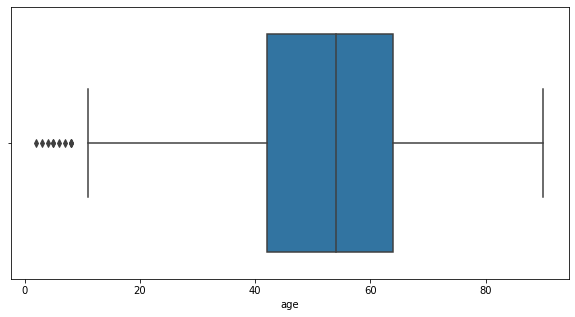

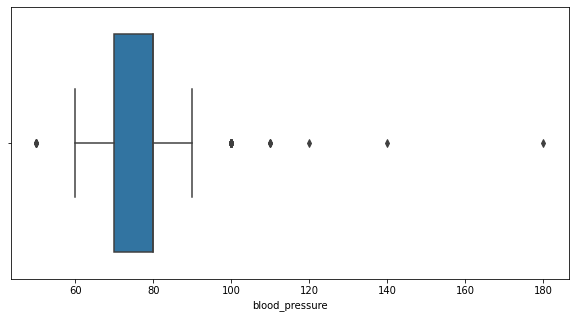

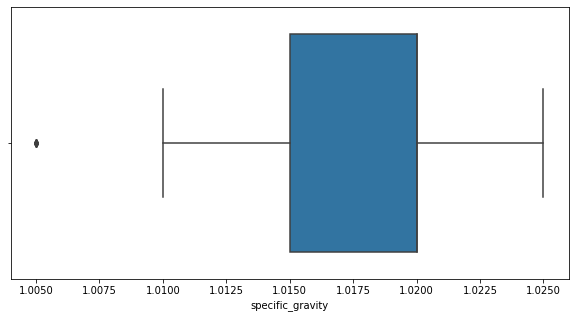

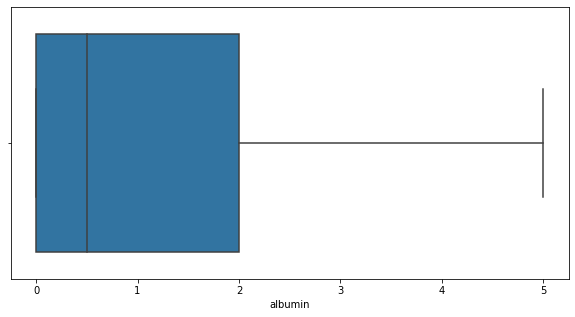

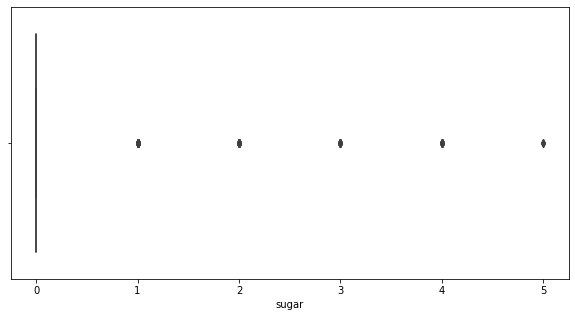

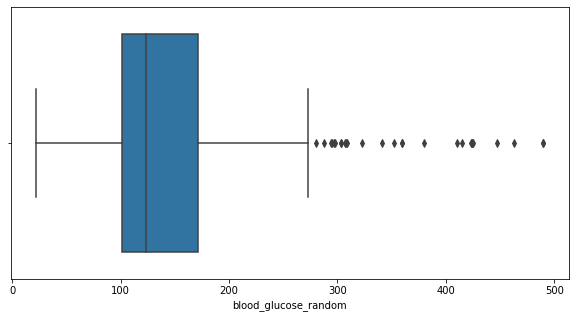

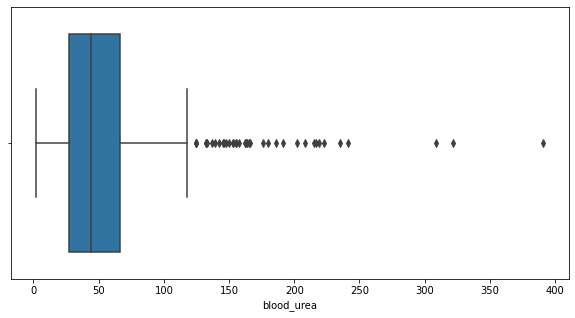

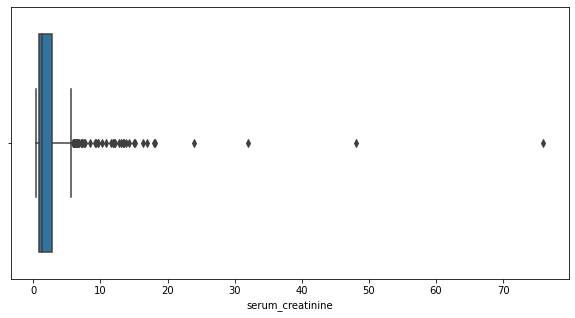

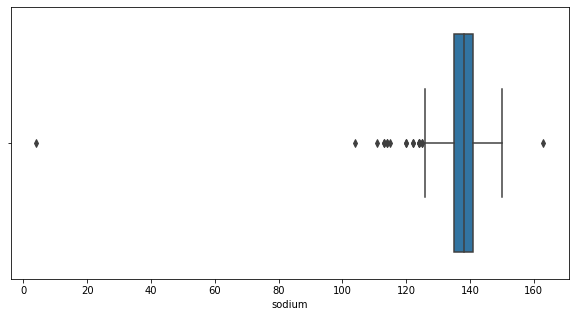

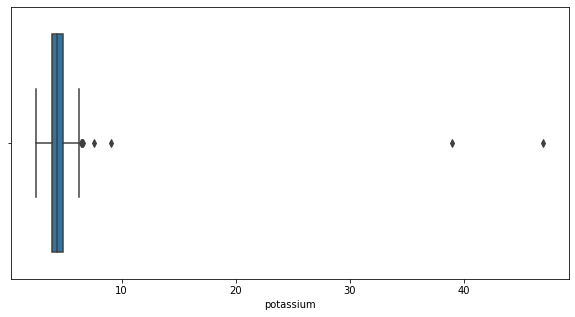

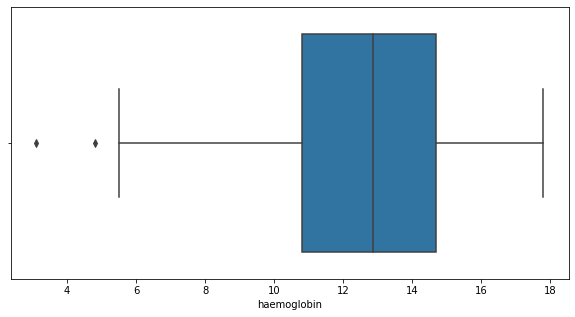

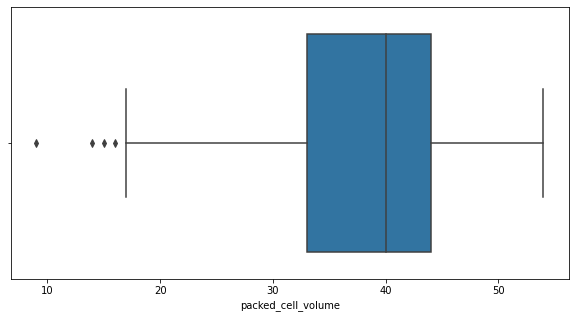

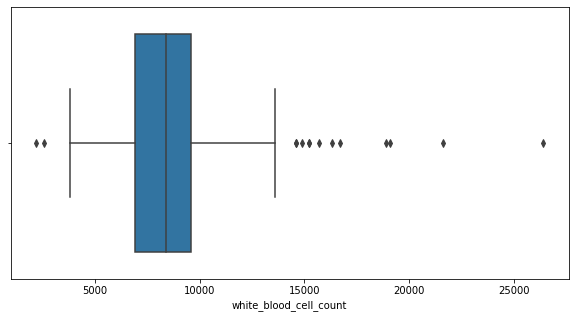

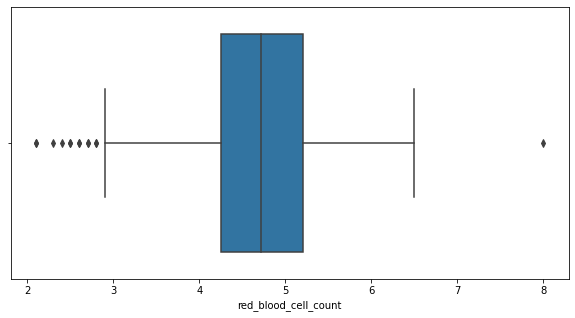

In [59]:
for column in numecial_columns_list:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=(column),data=df)

The reason for this is that if we take a look at the distribution of the ourliers depending on our target class, we can see that the some of the intervls which contain the outliers should in fact not be considered as such. This is is the case of the age feature and blood presure feature and many others.
We determined that the reason for this is because of the skewedness of the data and not because of acctual outliers.

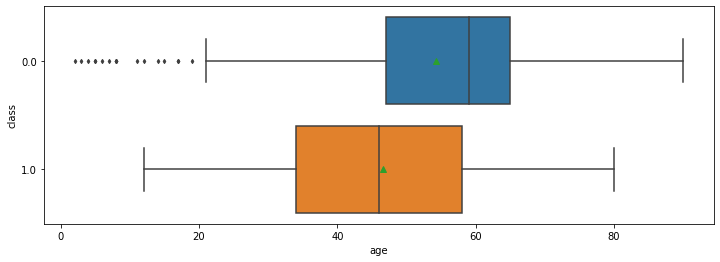

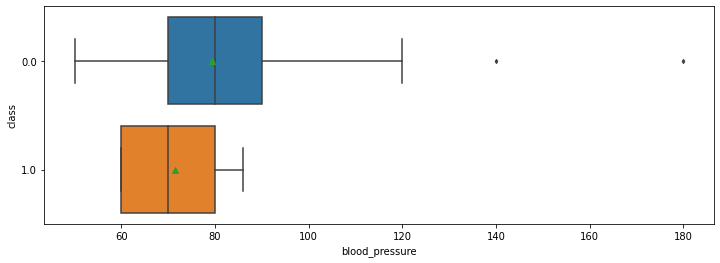

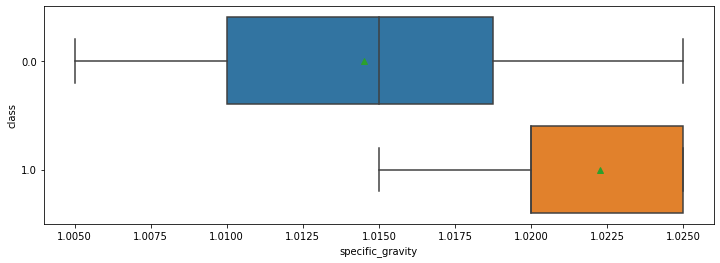

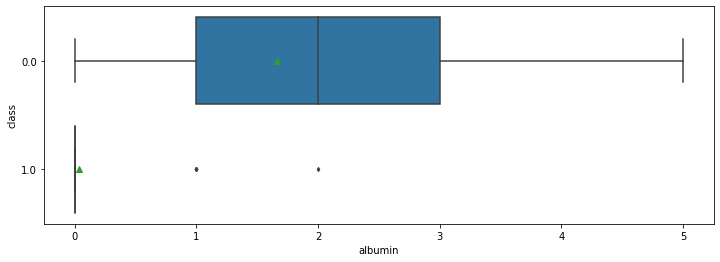

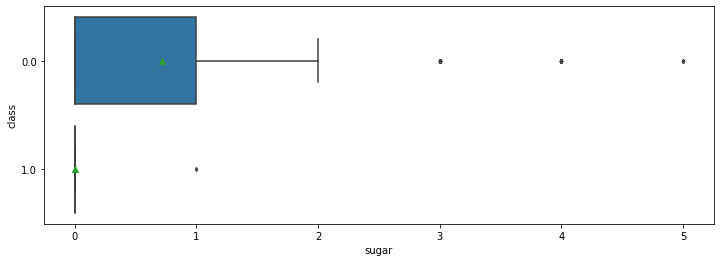

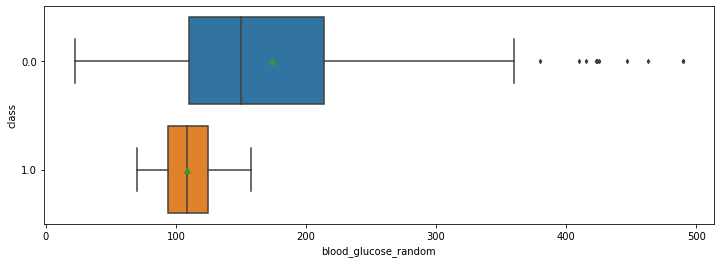

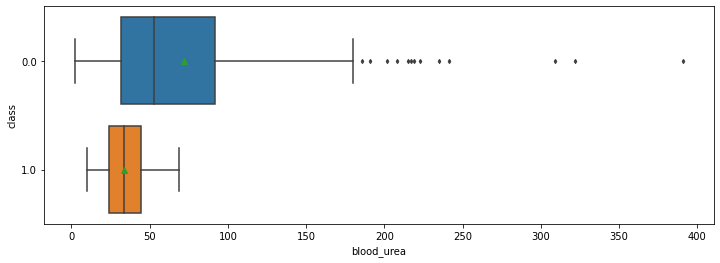

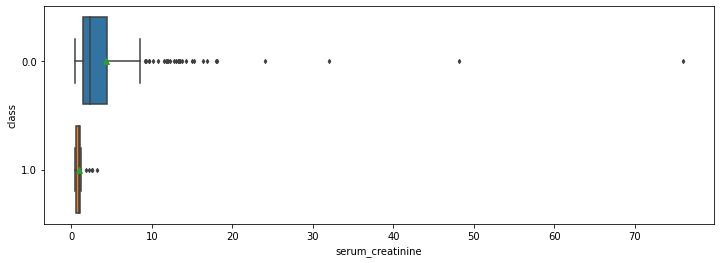

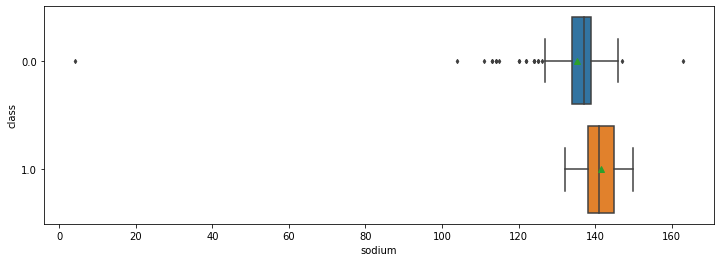

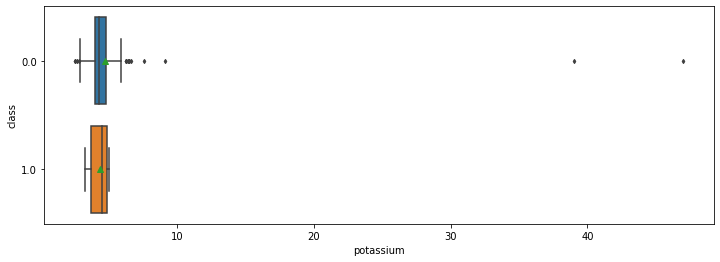

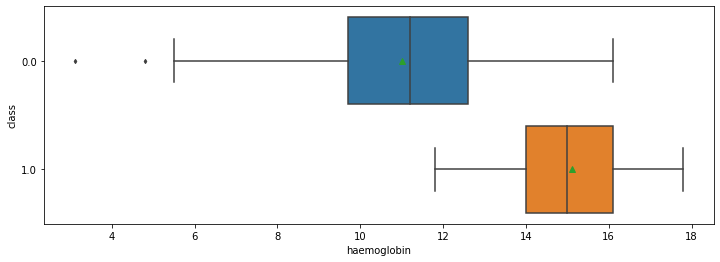

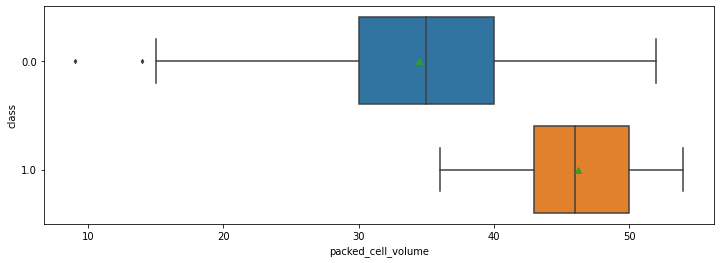

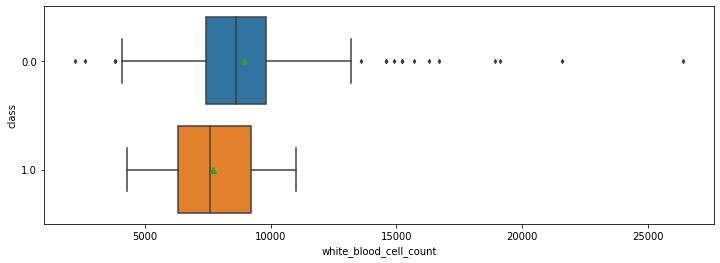

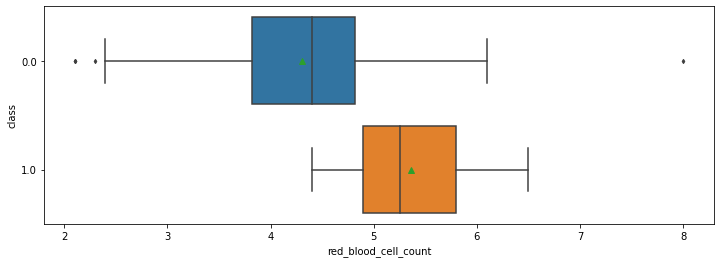

In [60]:
from scipy import stats
for column in numecial_columns_list:   
    fig, ax = plt.subplots(figsize=(12,4))
    sns.boxplot(y = 'class', x = column, data = df,width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = ax)
    
    r, p = stats.pointbiserialr(df[column], df['class'])
plt.show()   

Since th issue of th outliers is not there, we will take a brief look at the correlation map to see if wen determine anything at the moment

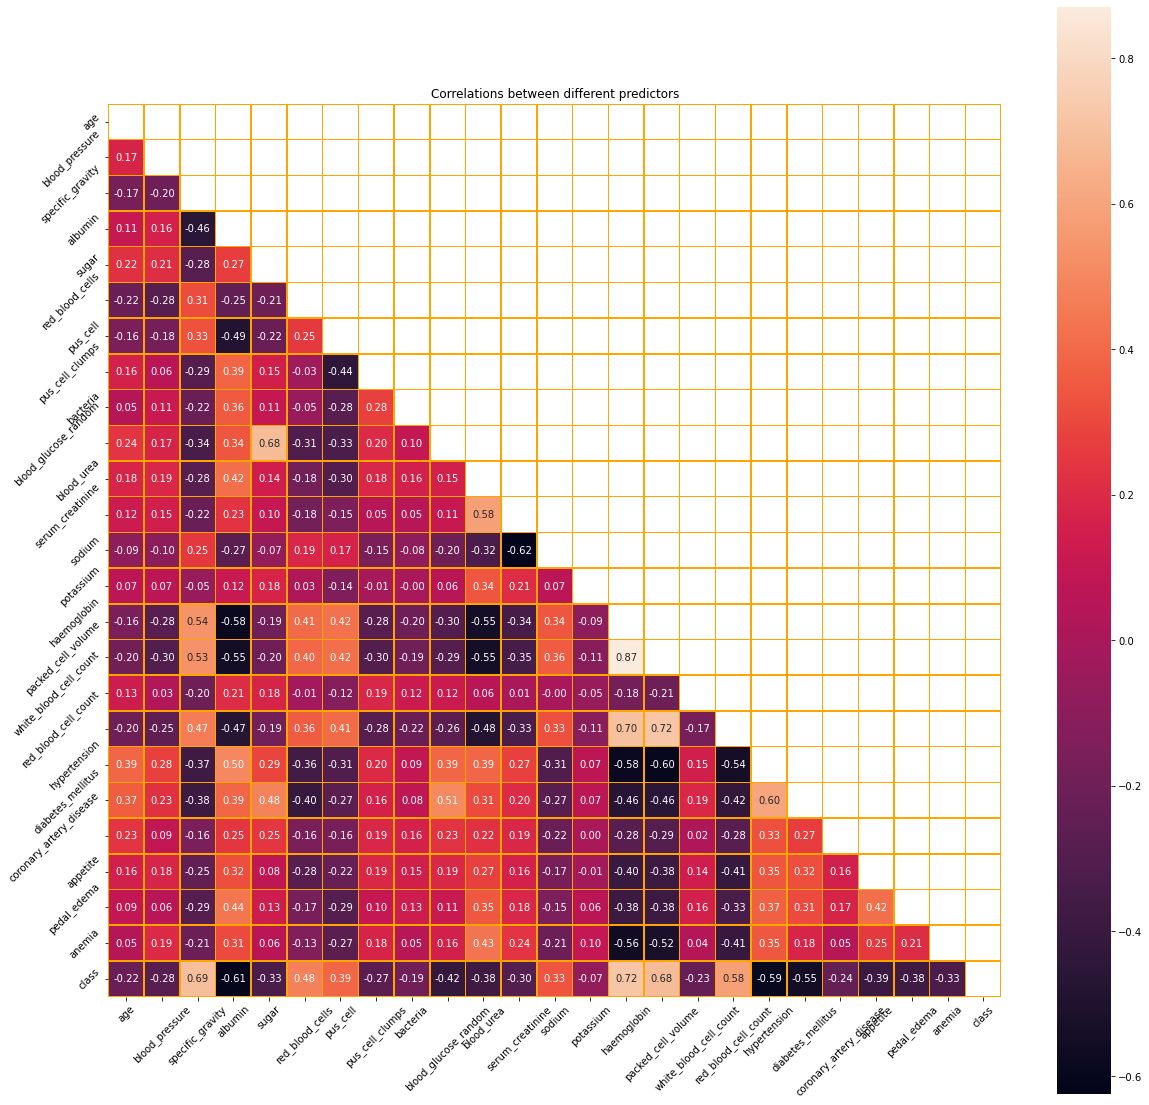

In [61]:
corr_ckd = df.corr()
f,ax=plt.subplots(figsize=(20,20))
mask = np.zeros_like(corr_ckd)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_ckd,annot=True,fmt=".2f",ax=ax,linewidths=0.5,linecolor="orange", mask = mask, square=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Correlations between different predictors')
plt.show()

The heatmap proved the strong correlation between several varianbles and this is going to be especially helpful during feature selction and modeling

Before moving on however, we will first scale our data. The reason is that some of the algorithms that we used are quite sensitive to unscald data. In this prospect and to make sure we are not completely obliterating any doubts about the outlier issue, we chose to use a the robust scaler which renders the data immune to outliers.

In [ ]:
# applying the robust scaler
from sklearn import preprocessing
X= df.drop('class', axis=1)
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(X)
X = pd.DataFrame(robust_df, columns =['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'hypertension',
       'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
       'pedal_edema', 'anemia'])

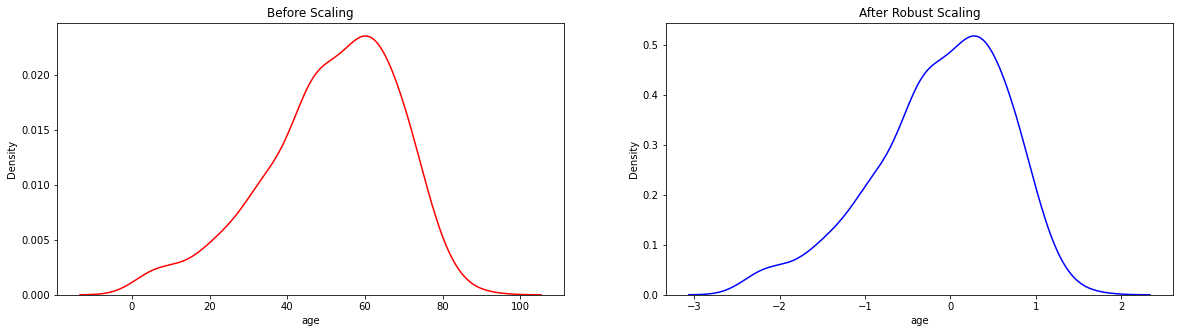

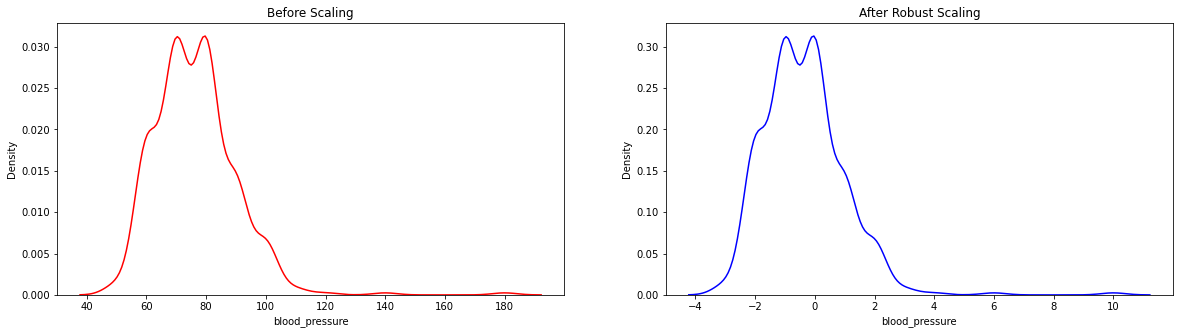

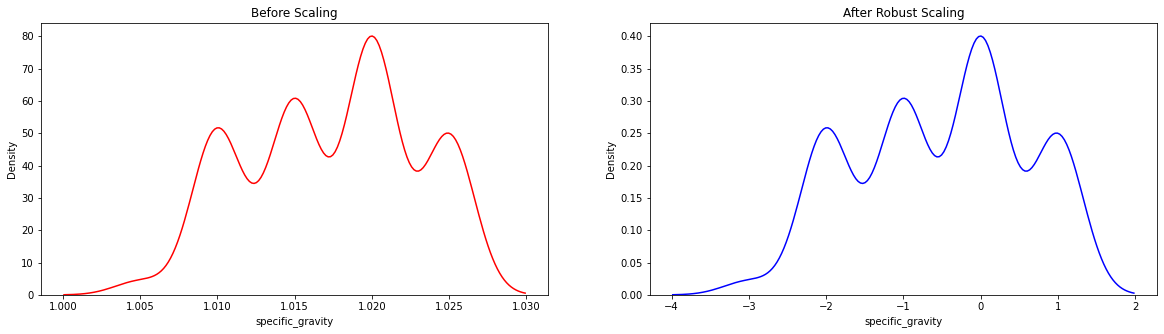

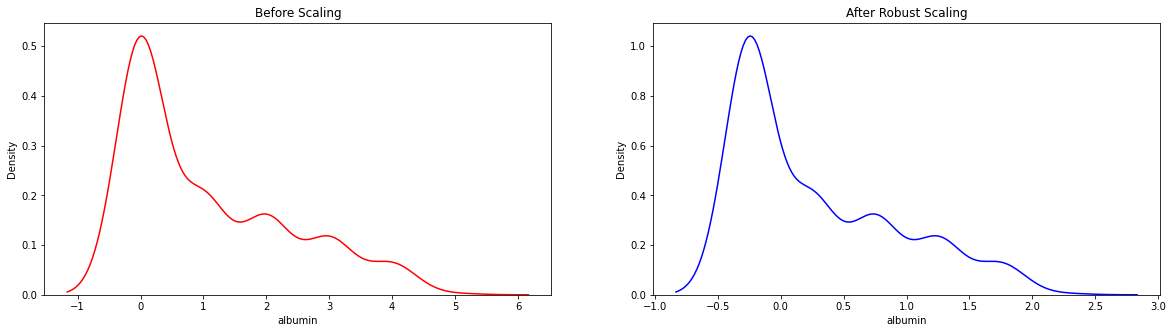

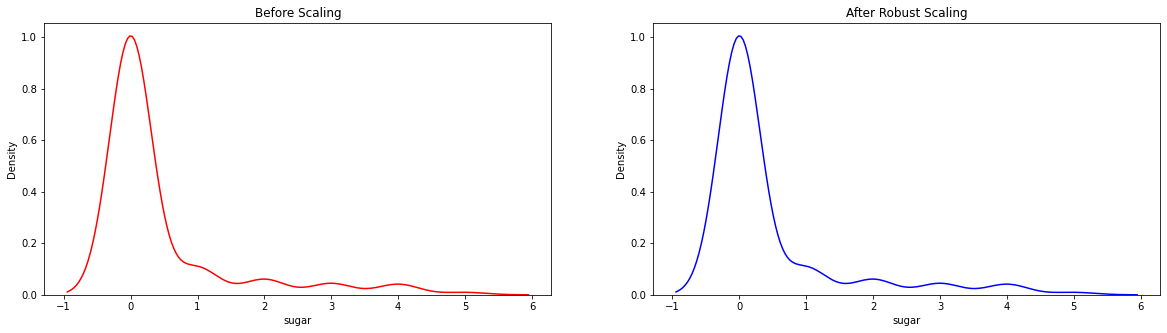

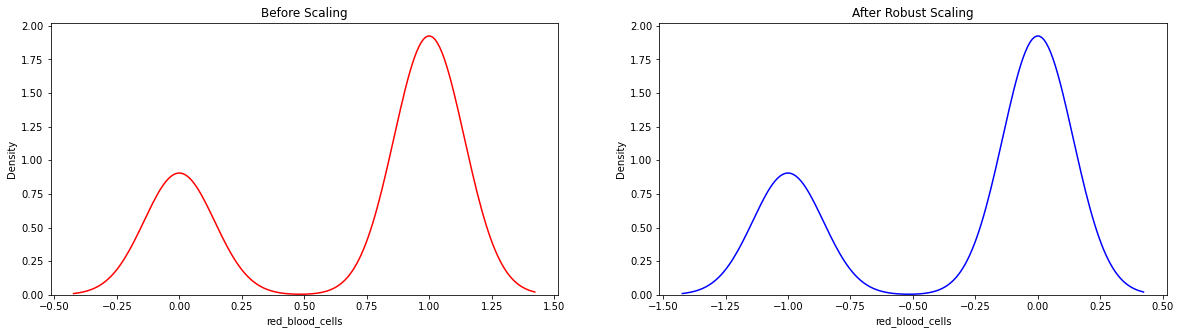

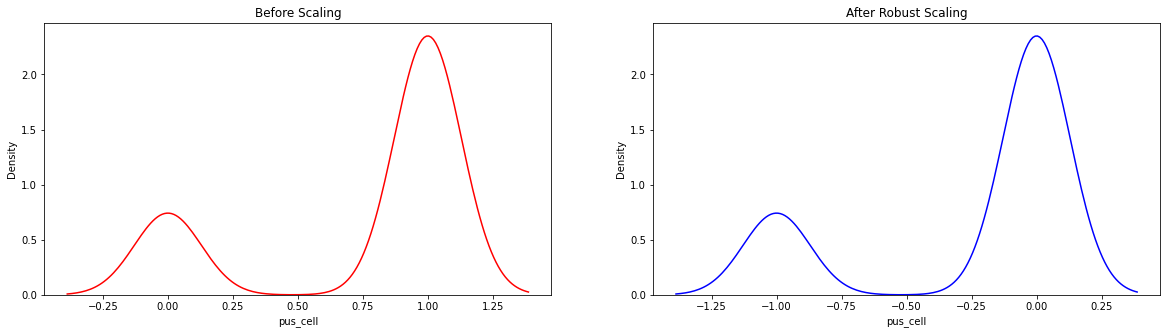

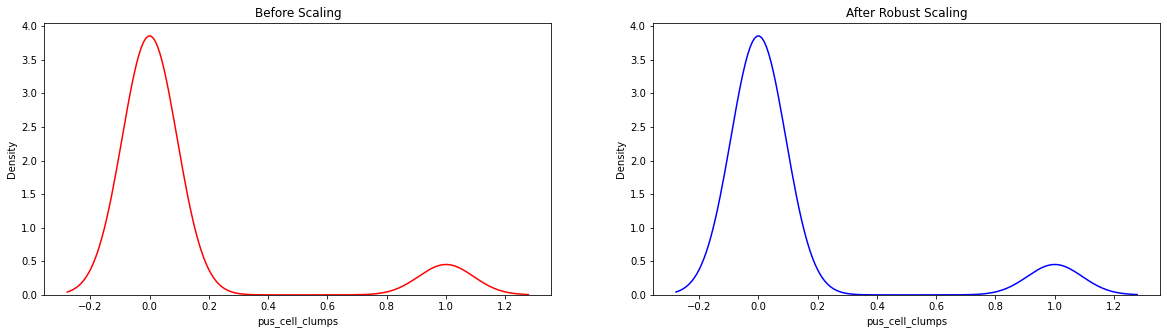

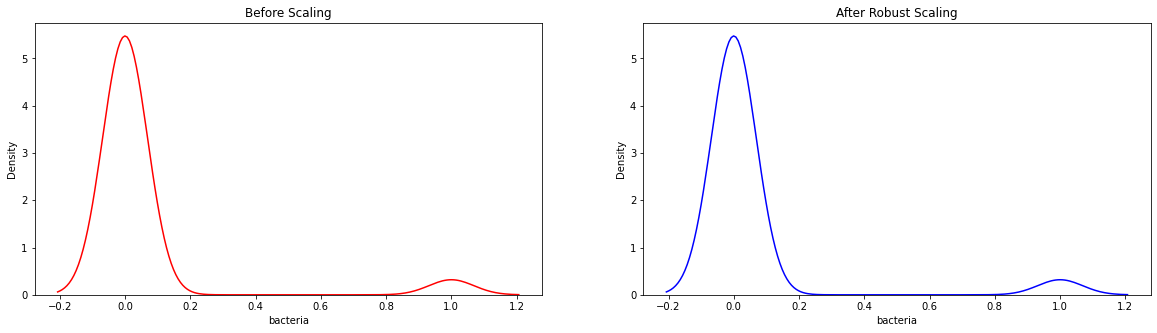

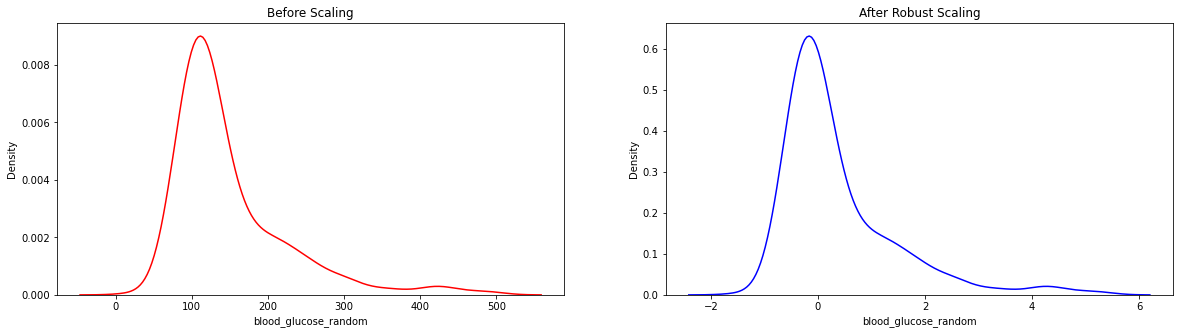

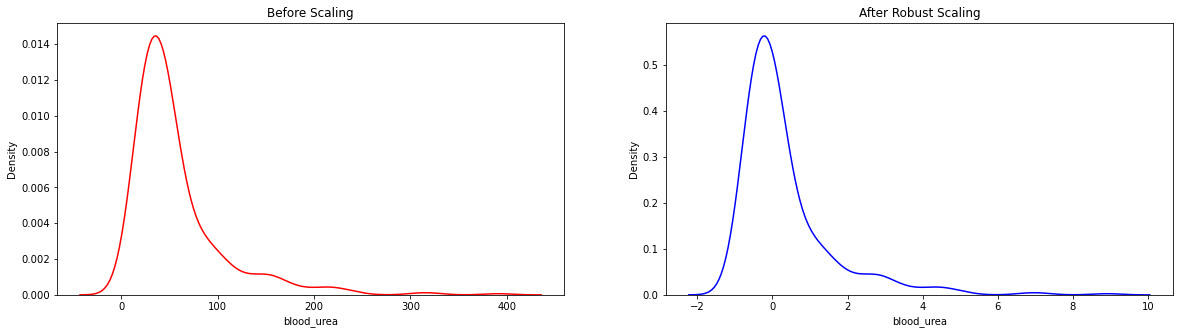

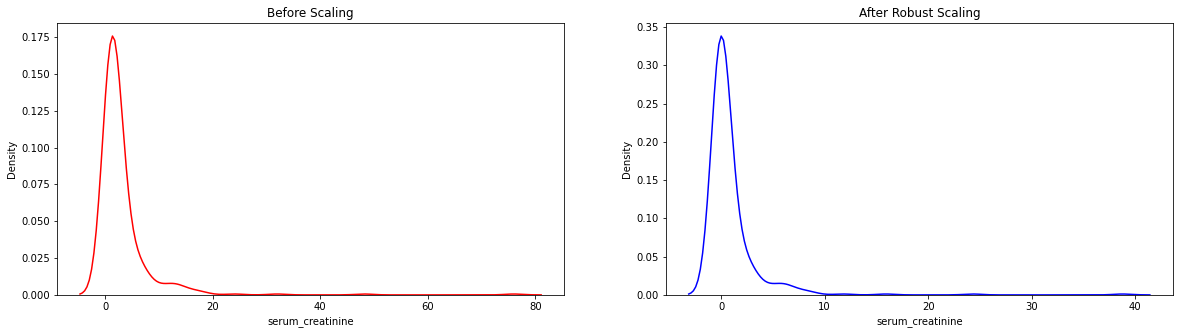

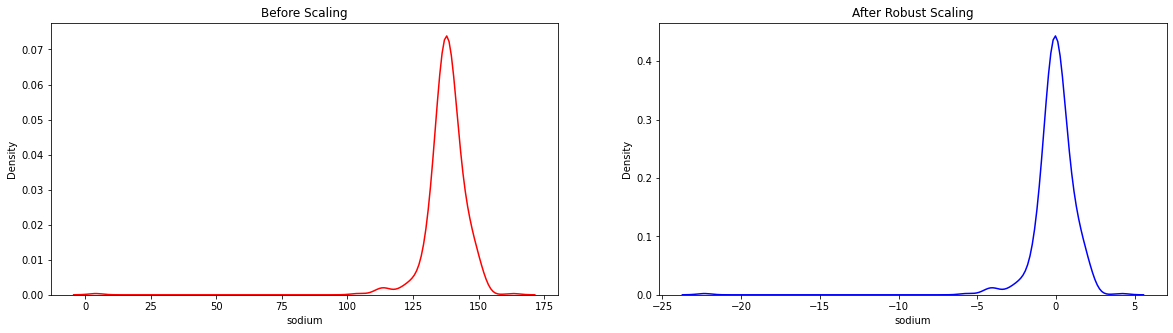

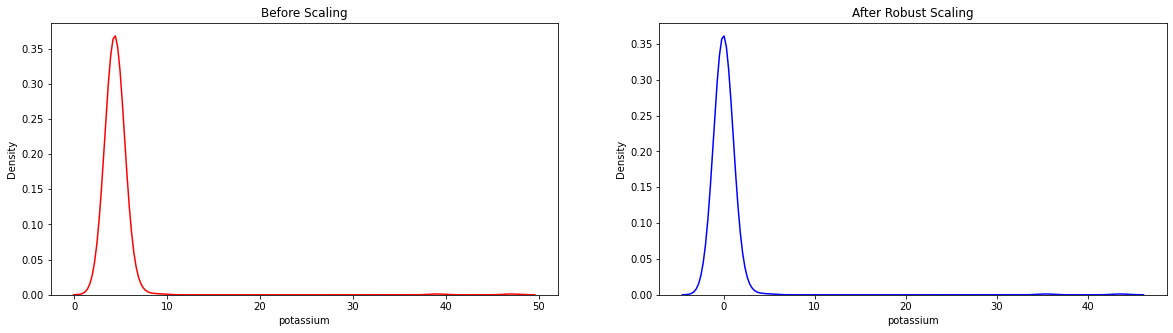

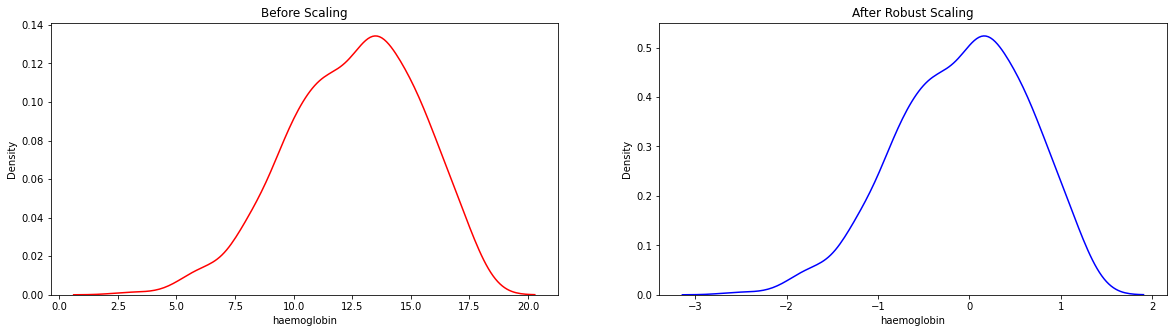

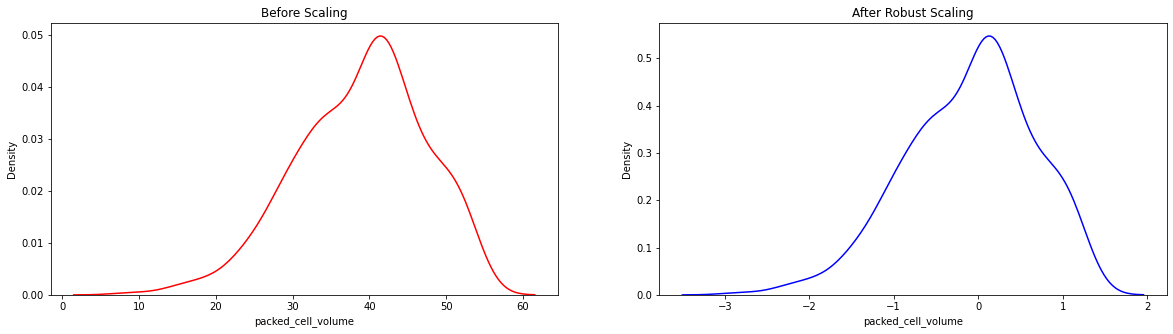

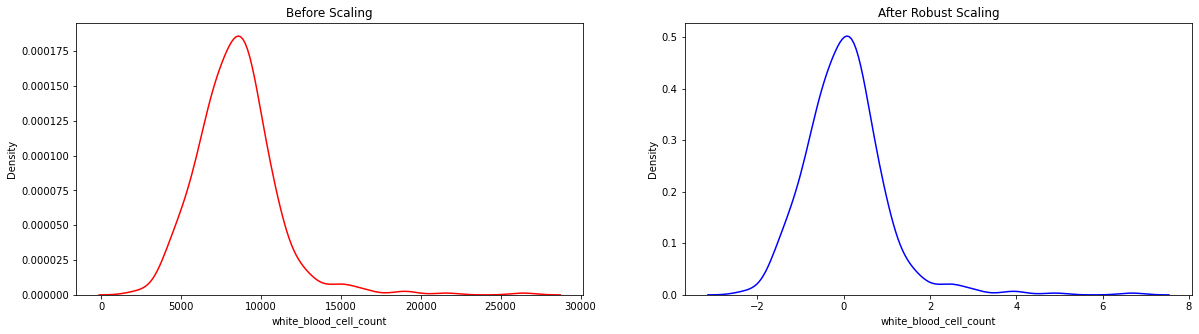

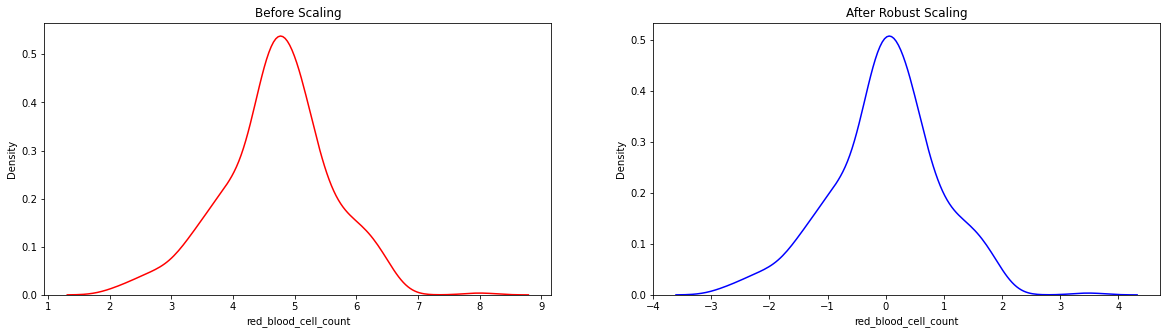

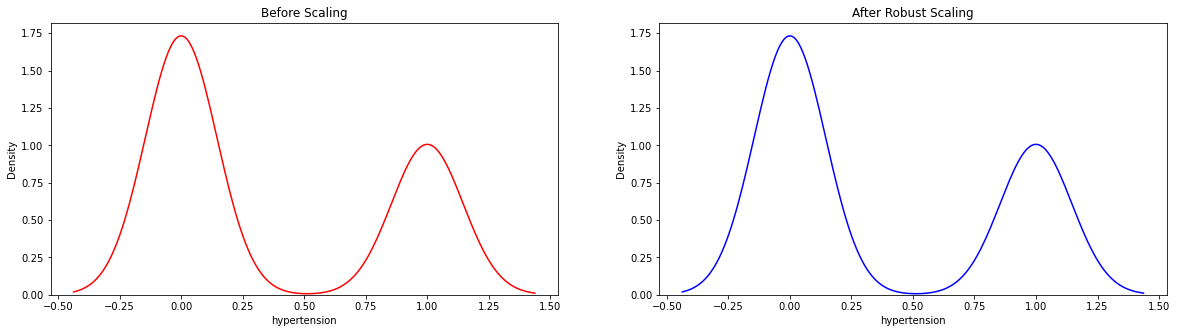

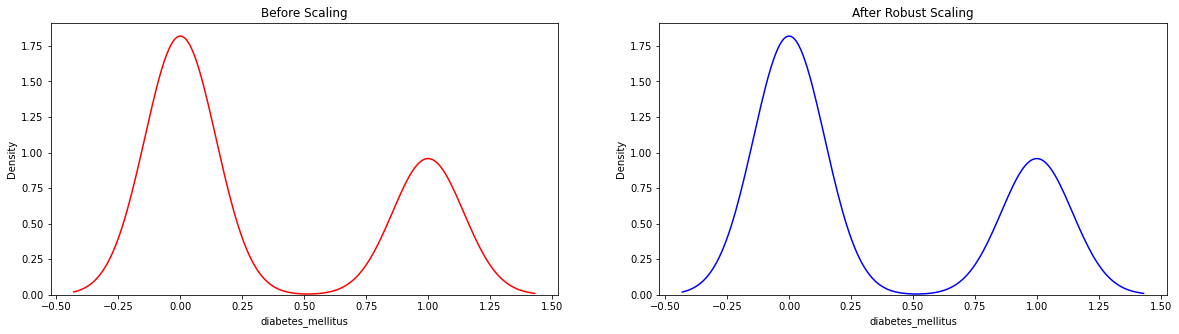

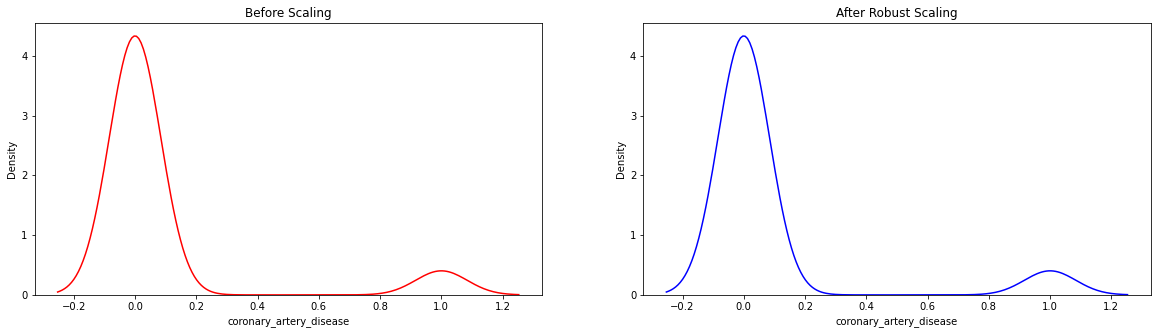

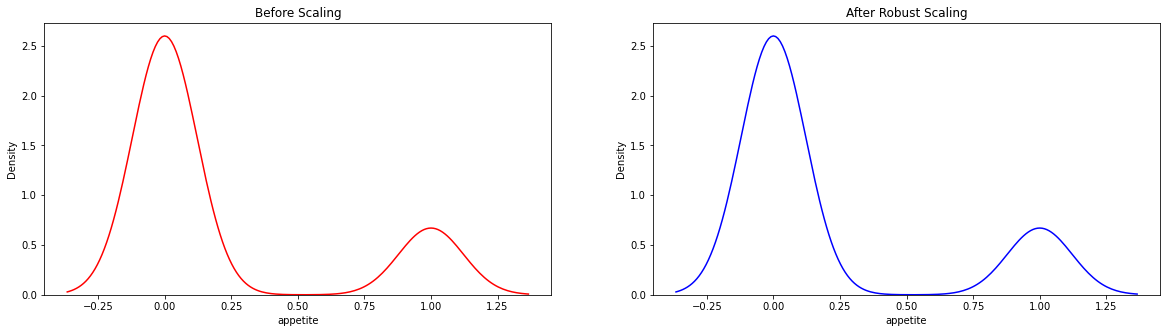

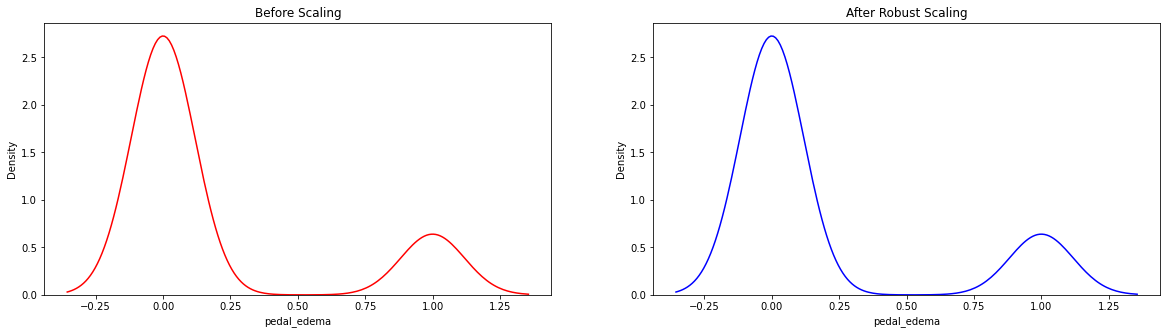

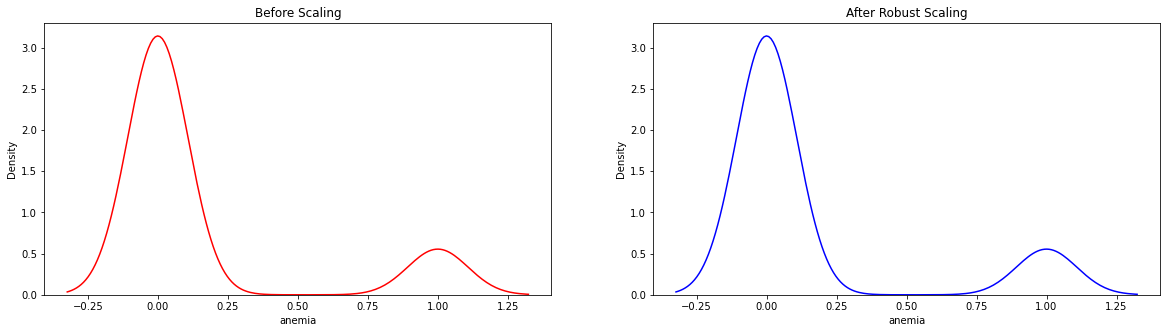

In [ ]:
# visualizing the the difference of the status f the data before and after scalling
for i in X.columns:
    
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
    ax1.set_title('Before Scaling')
  
    sns.kdeplot(df[i], ax = ax1, color ='r')
    sns.kdeplot(X[i], ax = ax2, color ='b')
    ax2.set_title('After Robust Scaling')

### Let's start our modeling journey

In [ ]:
# splitting the data
y = df['class']
y = y.values
X= X.values
# Train/test set generation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Without feature selection

In this secion we trained 8 different algorithms without feature selection

Decision Tree

In [ ]:
# Grid search CV for Decision Tree before fs
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
grid_values = {'criterion':['gini','entropy'],
               'max_depth': np.arange(3, 15),
               'min_samples_leaf':np.arange(1, 5),
               'min_samples_split':np.arange(2, 10),
               'splitter':['best','random']
              }
grid_search_dt = GridSearchCV(dt, param_grid = grid_values, cv = 5, scoring = 'accuracy')
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'splitter': 'random'}

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



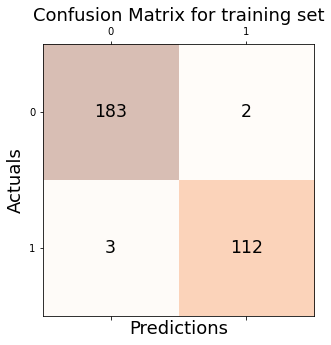

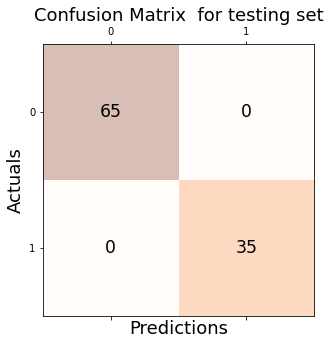

----------------- Overall Results -----------------
Accuracy Result for train set: 98.33%
Accuracy Result for test set: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%
AUC Result:100.00%


In [ ]:
#Let's apply the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
DT = DecisionTreeClassifier(criterion = 'entropy',random_state=4862, splitter='random', 
                            max_depth=6,min_samples_leaf= 3, min_samples_split= 8)
DT.fit(X_train, y_train)
#prediction phase
preds_dt = DT.predict(X_test)

print(classification_report(y_test, preds_dt))


conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=DT.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, DT.predict(X_train))
acc_dt = accuracy_score(y_test, preds_dt)
precision_dt = precision_score(y_test, preds_dt)*100    
recall_dt= recall_score(y_test, preds_dt)*100    
f1score_dt = f1_score(y_test, preds_dt)*100

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_dt*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_dt))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_dt)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_dt)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_dt)*100))

K Nearest Neighbor

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



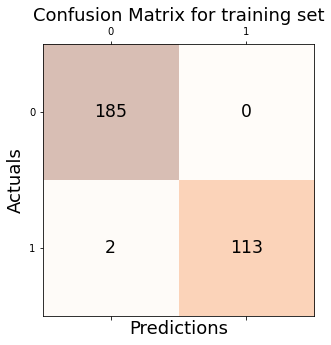

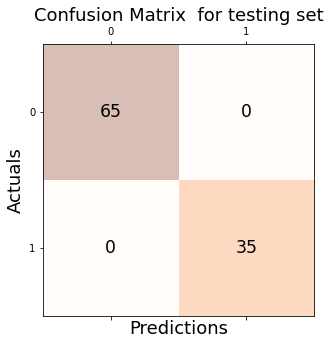

----------------- Overall Results -----------------
Accuracy Result for train set: 99.33%
Accuracy Result for test set: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%
AUC Result:100.00%


In [ ]:
#let's apply KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
#predition phase
preds_knn=knn.predict(X_test)
print(classification_report(y_test, preds_knn))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=knn.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_knn)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, knn.predict(X_train))
acc_knn = accuracy_score(y_test, preds_knn)
precision_knn = precision_score(y_test, preds_knn)*100    
recall_knn= recall_score(y_test, preds_knn)*100    
f1score_knn = f1_score(y_test, preds_knn)*100
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_knn*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_knn))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_knn)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_knn)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_knn)*100))

Light Gradient Boosting Machine(LGBM)

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix of training set:- 
[[185   0]
 [  0 115]]

Confusion Matrix testing set:- 
[[64  1]
 [ 0 35]]



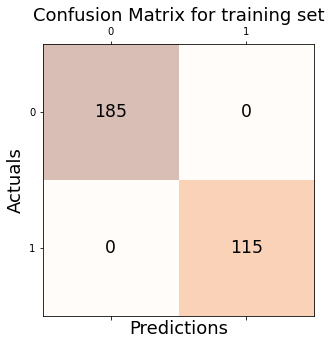

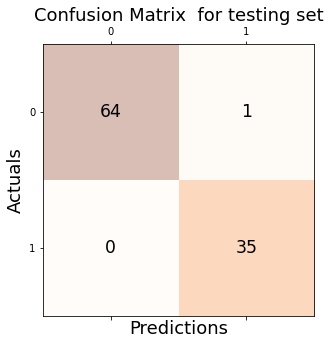

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 99.00%
Precision Result: 97.22%
Recall Result: 100.00%
F1-Score Result: 98.59%
AUC Result:99.23%


In [ ]:
# model fit
LGBM = LGBMClassifier()
LGBM.fit(X_train, y_train)

# prediction
preds_lgbm = LGBM.predict(X_test)
print(classification_report(y_test, preds_lgbm))
print(f"Confusion Matrix of training set:- \n{confusion_matrix(y_train, LGBM.predict(X_train))}\n")
print(f"Confusion Matrix testing set:- \n{confusion_matrix(y_test, preds_lgbm)}\n")

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=LGBM.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lgbm)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, LGBM.predict(X_train))
acc_lgbm = accuracy_score(y_test, preds_lgbm)
precision_lgbm = precision_score(y_test, preds_lgbm)*100    
recall_lgbm = recall_score(y_test, preds_lgbm)*100    
f1score_lgbm = f1_score(y_test, preds_lgbm)*100    
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lgbm*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lgbm))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lgbm)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lgbm)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lgbm)*100))

Naive Bayes, or more specifically Gaussian Naive Bayes

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.0004328761281083057)


              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        65
         1.0       0.90      1.00      0.95        35

    accuracy                           0.96       100
   macro avg       0.95      0.97      0.96       100
weighted avg       0.96      0.96      0.96       100



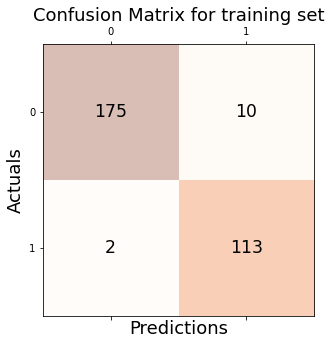

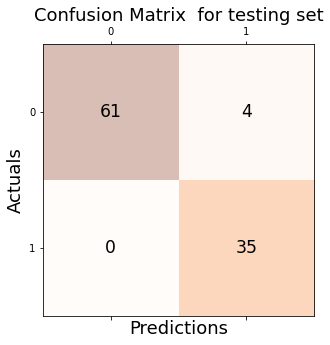

----------------- Overall Results -----------------
Accuracy Result for train set: 96.00%
Accuracy Result for test set: 96.00%
Precision Result: 89.74%
Recall Result: 100.00%
F1-Score Result: 94.59%
AUC Result:96.92%


In [ ]:
# model fit
NB = GaussianNB(var_smoothing=0.0004328761281083057)
NB.fit(X_train, y_train)

# prediction
preds_nb = NB.predict(X_test)
print(classification_report(y_test, preds_nb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=NB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_nb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, NB.predict(X_train))
acc_nb = accuracy_score(y_test, preds_nb)
precision_nb = precision_score(y_test, preds_nb)*100    
recall_nb = recall_score(y_test, preds_nb)*100    
f1score_nb = f1_score(y_test, preds_nb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_nb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_nb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_nb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_nb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_nb)*100))

Random Forest

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



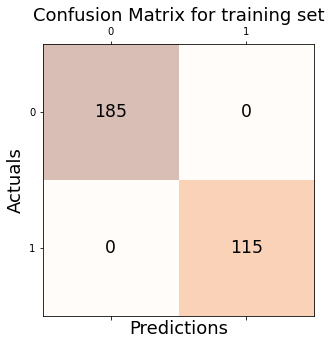

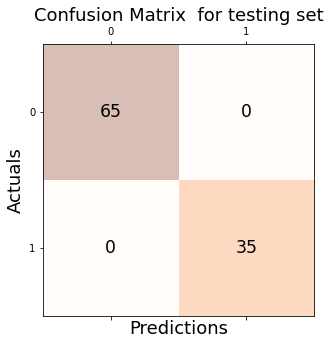

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%
AUC Result:100.00%


In [ ]:
# model fit
rf = RandomForestClassifier(n_estimators= 200, random_state=6518)
rf.fit(X_train, y_train)

# prediction
preds_rf = rf.predict(X_test)
print(classification_report(y_test, preds_rf))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=rf.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_rf)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, rf.predict(X_train))
acc_rf = accuracy_score(y_test, preds_rf)
precision_rf = precision_score(y_test, preds_rf)*100    
recall_rf = recall_score(y_test, preds_rf)*100    
f1score_rf = f1_score(y_test, preds_rf)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_rf*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_rf))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_rf)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_rf)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_rf)*100))

Linear Discriminant Analysis (LDA)

In [ ]:
grid=dict()
grid['solver']=['svd', 'lsqr', 'eigen']
search=GridSearchCV(LinearDiscriminantAnalysis(), grid, scoring='accuracy', cv=10, n_jobs=-1 )
result=search.fit(X_train, y_train)
result.best_params_

{'solver': 'svd'}

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        65
         1.0       0.90      1.00      0.95        35

    accuracy                           0.96       100
   macro avg       0.95      0.97      0.96       100
weighted avg       0.96      0.96      0.96       100



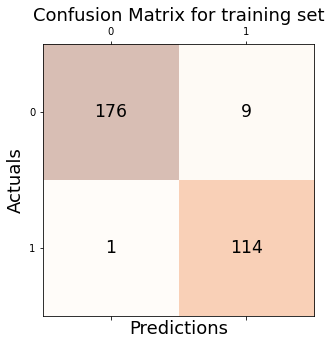

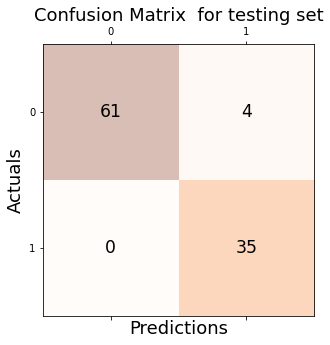

----------------- Overall Results -----------------
Accuracy Result for train set: 96.67%
Accuracy Result for test set: 96.00%
Precision Result: 89.74%
Recall Result: 100.00%
F1-Score Result: 94.59%
AUC Result:96.92%


In [ ]:
# model fit
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train, y_train)

# prediction
preds_lda = lda.predict(X_test)
print(classification_report(y_test, preds_lda))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=lda.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lda)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, lda.predict(X_train))
acc_lda = accuracy_score(y_test, preds_lda)
precision_lda = precision_score(y_test, preds_lda)*100    
recall_lda = recall_score(y_test, preds_lda)*100    
f1score_lda = f1_score(y_test, preds_lda)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lda*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lda))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lda)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lda)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lda)*100))

XGBoost

[18:25:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



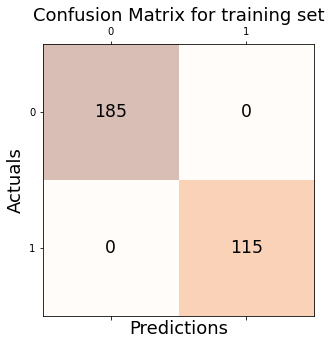

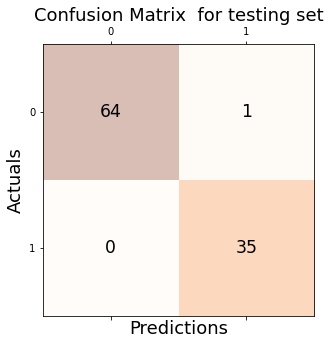

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 99.00%
Precision Result: 97.22%
Recall Result: 100.00%
F1-Score Result: 98.59%
AUC Result:99.23%


In [ ]:
# model fit
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

# prediction
preds_xgb = XGB.predict(X_test)
print(classification_report(y_test, preds_xgb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=XGB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_xgb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, XGB.predict(X_train))
acc_xgb = accuracy_score(y_test, preds_xgb)
precision_xgb = precision_score(y_test, preds_xgb)*100    
recall_xgb = recall_score(y_test, preds_xgb)*100    
f1score_xgb = f1_score(y_test, preds_xgb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_xgb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_xgb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_xgb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_xgb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_xgb)*100))

Multiple Lyer Perception (MLP)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



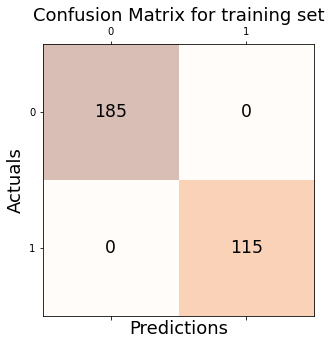

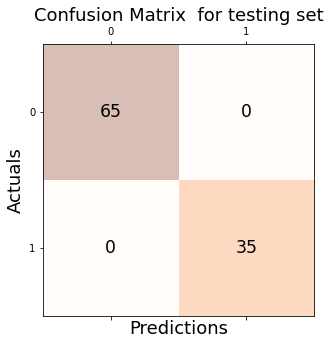

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%
AUC Result:100.00%


In [ ]:
# model fit
MLP = MLPClassifier(random_state=13324)
MLP.fit(X_train, y_train)

# prediction
preds_mlp = MLP.predict(X_test)
print(classification_report(y_test, preds_mlp))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=MLP.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_mlp)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, MLP.predict(X_train))
acc_mlp = accuracy_score(y_test, preds_mlp)

precision_mlp = precision_score(y_test, preds_mlp)*100    
recall_mlp = recall_score(y_test, preds_mlp)*100    
f1score_mlp = f1_score(y_test, preds_mlp)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_mlp*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_mlp))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_mlp)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_mlp)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_mlp)*100))

Let's plot the results of all the algorithms

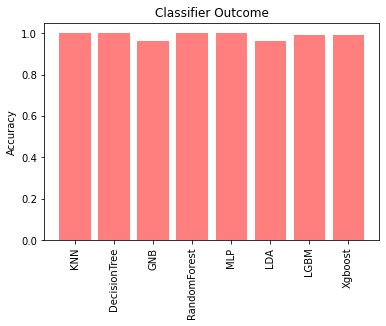

In [ ]:
#plotting the accuracy of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [acc_knn, acc_dt, acc_nb, acc_rf, acc_mlp, acc_lda, acc_lgbm, acc_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Classifier Outcome')
plt.show()

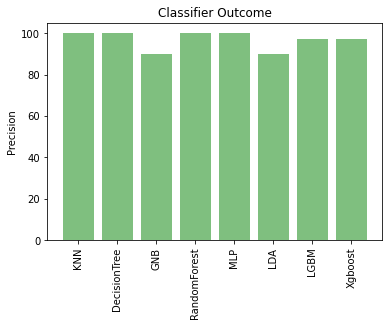

In [ ]:
#plotting the Precision of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [precision_knn, precision_dt, precision_nb, precision_rf, precision_mlp, precision_lda, precision_lgbm, precision_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='g')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Precision')
plt.title('Classifier Outcome')
plt.show()

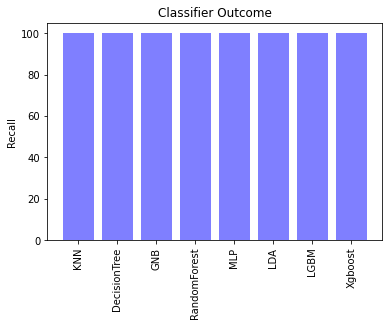

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [recall_knn, recall_dt, recall_nb, recall_rf, recall_mlp, recall_lda, recall_lgbm, recall_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='b')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Recall')
plt.title('Classifier Outcome')
plt.show()

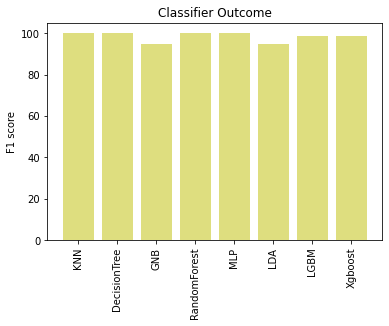

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [f1score_knn, f1score_dt, f1score_nb, f1score_rf, f1score_mlp,f1score_lda, f1score_lgbm, f1score_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='y')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('F1 score')
plt.title('Classifier Outcome')
plt.show()

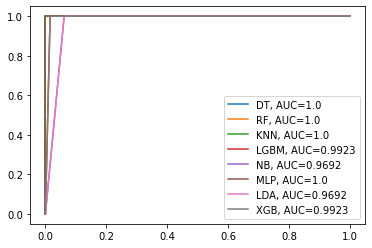

In [ ]:
#plotting the AUC of all models

# roc curve for classifiers before parameter tuning
fpr1, tpr1, _1 = roc_curve(y_test, preds_dt)
auc1 = round(roc_auc_score(y_test, preds_dt), 4)
plt.plot(fpr1,tpr1,label="DT, AUC="+str(auc1))

fpr2, tpr2, _2 = roc_curve(y_test,preds_rf)
auc2 = round(roc_auc_score(y_test, preds_rf), 4)
plt.plot(fpr2,tpr2,label="RF, AUC="+str(auc2))

fpr3, tpr3, _3 = roc_curve(y_test, preds_knn)
auc3 = round(roc_auc_score(y_test, preds_knn), 4)
plt.plot(fpr3,tpr3,label="KNN, AUC="+str(auc3))

fpr4, tpr4, _4 = roc_curve(y_test, preds_lgbm)
auc4 = round(roc_auc_score(y_test,preds_lgbm), 4)
plt.plot(fpr4,tpr4,label="LGBM, AUC="+str(auc4))

fpr5, tpr5, _5 = roc_curve(y_test, preds_nb)
auc5 = round(roc_auc_score(y_test, preds_nb), 4)
plt.plot(fpr5,tpr5,label="NB, AUC="+str(auc5))

fpr6, tpr6, _6 = roc_curve(y_test, preds_mlp)
auc6 = round(roc_auc_score(y_test, preds_mlp), 4)
plt.plot(fpr6,tpr6,label="MLP, AUC="+str(auc6))

fpr7, tpr7, _7 = roc_curve(y_test, preds_lda)
auc7 = round(roc_auc_score(y_test, preds_lda), 4)
plt.plot(fpr7,tpr7,label="LDA, AUC="+str(auc7))

fpr8, tpr8, _8 = roc_curve(y_test, preds_xgb)
auc8 = round(roc_auc_score(y_test, preds_xgb), 4)
plt.plot(fpr8,tpr8,label="XGB, AUC="+str(auc8))

plt.legend()


To make sure the results of our algorithms are robust, we will also check with the cross val score on KStratified folds 

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 0
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(GaussianNB())
classifiers.append(RandomForestClassifier())
classifiers.append(MLPClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier())
classifiers.append(XGBClassifier(use_label_encoder=False))

In [ ]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","DecisionTree","GNB",
"RandomForest","MLP","LDA","LGBM","Xgboost"]})

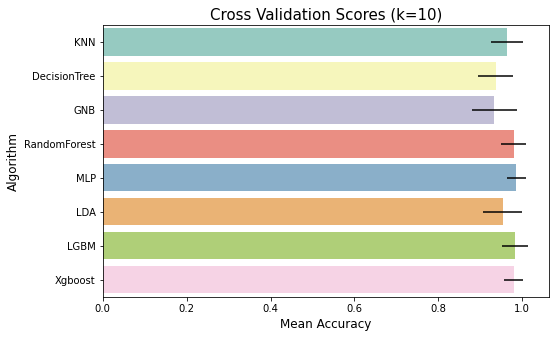

In [ ]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean Accuracy", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [ ]:
cv_res

CrossValMeans  CrossValerrors     Algorithm
0       0.963333        0.037859           KNN
1       0.936667        0.040689  DecisionTree
2       0.933333        0.053748           GNB
3       0.980000        0.030551  RandomForest
4       0.986667        0.022111           MLP
5       0.953333        0.047610           LDA
6       0.983333        0.030732          LGBM
7       0.980000        0.022111       Xgboost

# With Feature selection

We will test out algorithms with 2 feature selection methods

# MRMR feature selection

In [ ]:
pip install mrmr-selection

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# splitting the data
y = df['class']
X = pd.DataFrame(robust_df, columns =['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'hypertension',
       'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
       'pedal_edema', 'anemia'])

In [ ]:
# applying thr mRMR algorithm
from mrmr import mrmr_classif
selected_features_mrmr = mrmr_classif(X=X, y=y, K=11)

selected_features_mrmr

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.95it/s]


['haemoglobin',
 'specific_gravity',
 'packed_cell_volume',
 'albumin',
 'hypertension',
 'diabetes_mellitus',
 'red_blood_cell_count',
 'red_blood_cells',
 'blood_glucose_random',
 'appetite',
 'pedal_edema']

In [ ]:
# We will get the column idexes of the selected feature to be able to use during trainin and testing
mrmr_subset_list = []
for i in selected_features_mrmr: 
    column_index = df.columns.get_loc(i)
    mrmr_subset_list.append(column_index)

In [ ]:
y = y.values
X= X.values
# Train/test set generation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:, mrmr_subset_list], y, test_size=0.25, random_state=123)

Let's model

DEcision Tree

In [ ]:
# Grid search CV for Decision Tree after fs
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
grid_values = {'criterion':['gini','entropy'],
               'max_depth': np.arange(3, 15),
               'min_samples_leaf':np.arange(1, 10),
               'min_samples_split':np.arange(2, 10),
               'splitter':['best','random']
              }
grid_search_dt = GridSearchCV(dt, param_grid = grid_values, cv = 5, scoring = 'accuracy')
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'splitter': 'random'}

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        65
         1.0       0.97      0.97      0.97        35

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



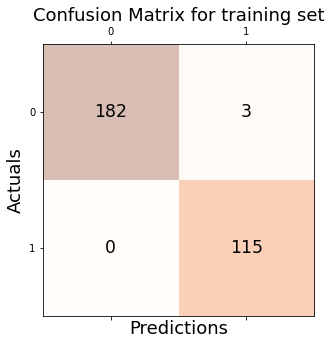

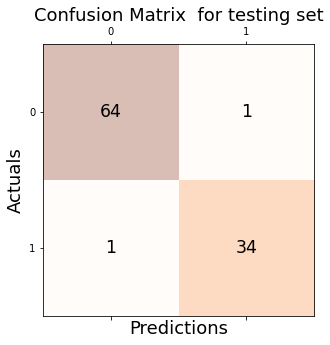

----------------- Overall Results -----------------
Accuracy Result for train set: 99.00%
Accuracy Result for test set: 98.00%
Precision Result: 97.14%
Recall Result: 97.14%
F1-Score Result: 97.14%
AUC Result:97.80%


In [ ]:
#Let's apply the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
DT = DecisionTreeClassifier(criterion = 'gini',random_state=62, splitter='random', max_depth=8,
                            min_samples_leaf= 1, min_samples_split=4)
DT.fit(X_train, y_train)
#prediction phase
preds_dt = DT.predict(X_test)

print(classification_report(y_test, preds_dt))


conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=DT.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, DT.predict(X_train))
acc_dt = accuracy_score(y_test, preds_dt)
precision_dt = precision_score(y_test, preds_dt)*100    
recall_dt= recall_score(y_test, preds_dt)*100    
f1score_dt = f1_score(y_test, preds_dt)*100

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_dt*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_dt))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_dt)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_dt)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_dt)*100))

K Neighbors Classifier

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



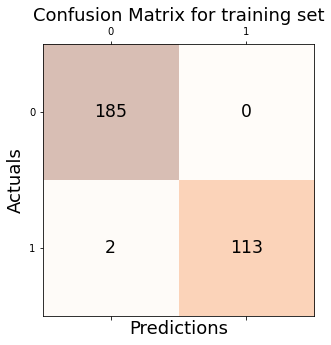

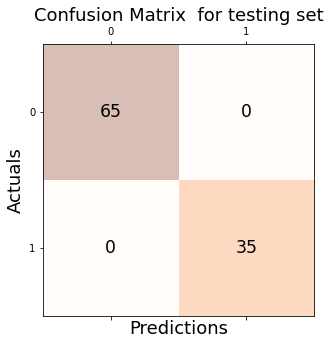

----------------- Overall Results -----------------
Accuracy Result for train set: 99.33%
Accuracy Result for test set: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%
AUC Result:100.00%


In [ ]:
#let's apply KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
#predition phase
preds_knn=knn.predict(X_test)
print(classification_report(y_test, preds_knn))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=knn.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_knn)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, knn.predict(X_train))
acc_knn = accuracy_score(y_test, preds_knn)
precision_knn = precision_score(y_test, preds_knn)*100    
recall_knn= recall_score(y_test, preds_knn)*100    
f1score_knn = f1_score(y_test, preds_knn)*100
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_knn*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_knn))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_knn)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_knn)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_knn)*100))

LGBM Classifier

In [ ]:
# Grid search for LGBM
import lightgbm as lgb
lgb=lgb.LGBMClassifier()
#Define the parameters
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}
#Define the scoring
clf=GridSearchCV(lgb,parameters,scoring='accuracy')
clf.fit(X=X_train, y=y_train)
print(clf.best_params_)

{'learning_rate': 0.2, 'max_depth': 5, 'min_child_samples': 5, 'num_leaves': 20, 'reg_alpha': 0.01}


              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98        65
         1.0       0.94      0.97      0.96        35

    accuracy                           0.97       100
   macro avg       0.96      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

Confusion Matrix of training set:- 
[[185   0]
 [  0 115]]

Confusion Matrix testing set:- 
[[63  2]
 [ 1 34]]



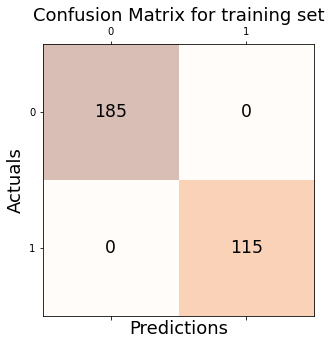

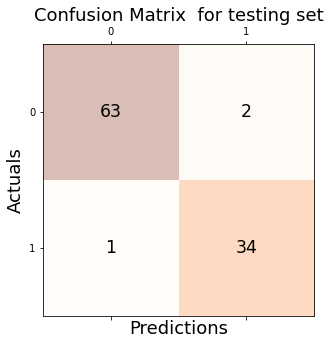

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 97.00%
Precision Result: 94.44%
Recall Result: 97.14%
F1-Score Result: 95.77%
AUC Result:97.03%


In [ ]:
# model fit
LGBM = LGBMClassifier(class_weight="balanced", n_estimators=800, learning_rate=0.2, subsample=0.7, 
                      reg_alpha=0.2, reg_lambda=0.8)
#LGBM = LGBMClassifier(learning_rate= 0.05, max_depth= 5, min_child_samples= 15, num_leaves= 20, reg_alpha= 0.03)
LGBM.fit(X_train, y_train)

# prediction
preds_lgbm = LGBM.predict(X_test)
print(classification_report(y_test, preds_lgbm))
print(f"Confusion Matrix of training set:- \n{confusion_matrix(y_train, LGBM.predict(X_train))}\n")
print(f"Confusion Matrix testing set:- \n{confusion_matrix(y_test, preds_lgbm)}\n")

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=LGBM.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lgbm)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, LGBM.predict(X_train))
acc_lgbm = accuracy_score(y_test, preds_lgbm)
precision_lgbm = precision_score(y_test, preds_lgbm)*100    
recall_lgbm = recall_score(y_test, preds_lgbm)*100    
f1score_lgbm = f1_score(y_test, preds_lgbm)*100    
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lgbm*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lgbm))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lgbm)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lgbm)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lgbm)*100))

Gaussian Naive Bayes

In [ ]:
#grid search for naive bayes algorithm
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 0.02310129700083159}

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        65
         1.0       0.90      1.00      0.95        35

    accuracy                           0.96       100
   macro avg       0.95      0.97      0.96       100
weighted avg       0.96      0.96      0.96       100



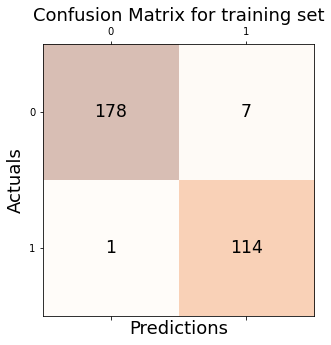

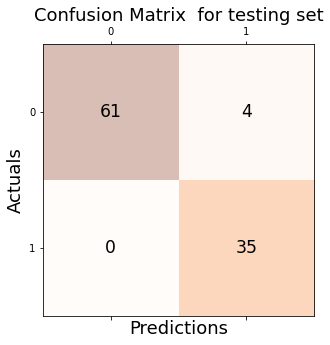

----------------- Overall Results -----------------
Accuracy Result for train set: 97.33%
Accuracy Result for test set: 96.00%
Precision Result: 89.74%
Recall Result: 100.00%
F1-Score Result: 94.59%
AUC Result:96.92%


In [ ]:
# model fit
NB = GaussianNB(var_smoothing=0.02310129700083159)
NB.fit(X_train, y_train)

# prediction
preds_nb = NB.predict(X_test)
print(classification_report(y_test, preds_nb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=NB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_nb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, NB.predict(X_train))
acc_nb = accuracy_score(y_test, preds_nb)
precision_nb = precision_score(y_test, preds_nb)*100    
recall_nb = recall_score(y_test, preds_nb)*100    
f1score_nb = f1_score(y_test, preds_nb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_nb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_nb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_nb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_nb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_nb)*100))

Random Forest

In [ ]:
# Grid search for RF
from sklearn.model_selection import GridSearchCV
rf =  RandomForestClassifier()
params =  {
    'max_leaf_nodes': [2, 3, 4, 5, 6, 7], 
    'criterion': ['entropy', 'gini'],
    'min_samples_split': [0.1,0.3,0.5,2,3,5, 10, 20, 50],
    'max_depth': [2,5,7,10,13,15,20],
    'max_features': ['sqrt','auto'],
    'n_estimators':[50, 100, 200],
    'bootstrap':[True, False]
}


# Create gridsearch instance
grid = GridSearchCV(estimator=rf,
                    param_grid=params,
                    cv=5,
                    n_jobs=1,
                    verbose=0)
# Fit the model
grid.fit(X_train, y_train)

# Assess the score
grid.best_score_, grid.best_params_

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        65
         1.0       1.00      0.91      0.96        35

    accuracy                           0.97       100
   macro avg       0.98      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100



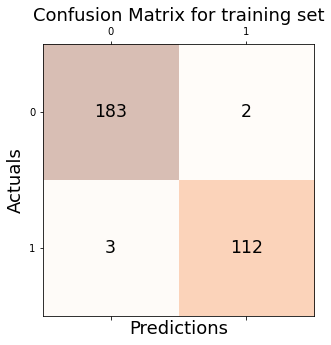

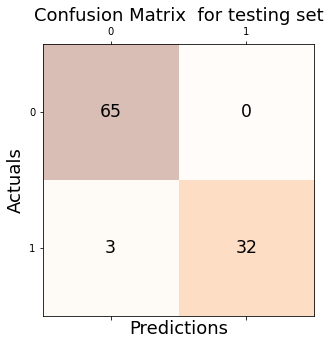

----------------- Overall Results -----------------
Accuracy Result for train set: 98.33%
Accuracy Result for test set: 97.00%
Precision Result: 100.00%
Recall Result: 91.43%
F1-Score Result: 95.52%
AUC Result:95.71%


In [ ]:
# model fit
rf = RandomForestClassifier(n_estimators=300,  max_depth=12, max_leaf_nodes=6,random_state=123, 
                            criterion ='gini', max_features='sqrt')
rf.fit(X_train, y_train)

# prediction
preds_rf = rf.predict(X_test)
print(classification_report(y_test, preds_rf))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=rf.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_rf)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, rf.predict(X_train))
acc_rf = accuracy_score(y_test, preds_rf)
precision_rf = precision_score(y_test, preds_rf)*100    
recall_rf = recall_score(y_test, preds_rf)*100    
f1score_rf = f1_score(y_test, preds_rf)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_rf*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_rf))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_rf)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_rf)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_rf)*100))

Linear Discriminant Analysis

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        65
         1.0       0.88      1.00      0.93        35

    accuracy                           0.95       100
   macro avg       0.94      0.96      0.95       100
weighted avg       0.96      0.95      0.95       100



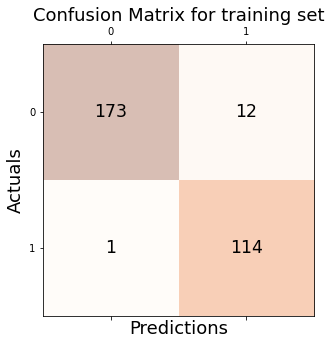

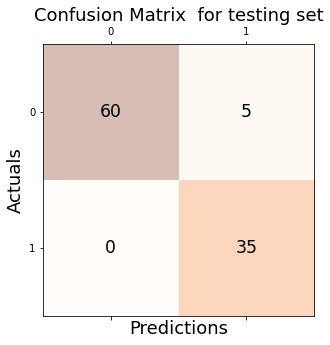

----------------- Overall Results -----------------
Accuracy Result for train set: 95.67%
Accuracy Result for test set: 95.00%
Precision Result: 87.50%
Recall Result: 100.00%
F1-Score Result: 93.33%
AUC Result:96.15%


In [ ]:
# model fit
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# prediction
preds_lda = lda.predict(X_test)
print(classification_report(y_test, preds_lda))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=lda.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lda)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, lda.predict(X_train))
acc_lda = accuracy_score(y_test, preds_lda)
precision_lda = precision_score(y_test, preds_lda)*100    
recall_lda = recall_score(y_test, preds_lda)*100    
f1score_lda = f1_score(y_test, preds_lda)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lda*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lda))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lda)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lda)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lda)*100))

XGBoost

[18:35:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        65
         1.0       0.97      0.97      0.97        35

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



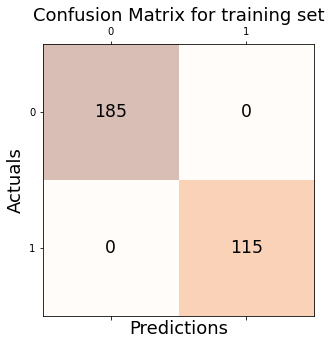

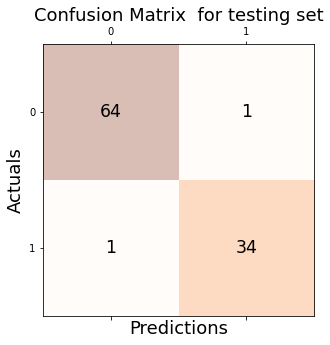

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 98.00%
Precision Result: 97.14%
Recall Result: 97.14%
F1-Score Result: 97.14%
AUC Result:97.80%


In [ ]:
# model fit
XGB = XGBClassifier(n_estimators= 300, learning_rate=0.1, subsample=0.7, scale_pos_weight=3)
XGB.fit(X_train, y_train)

# prediction
preds_xgb = XGB.predict(X_test)
print(classification_report(y_test, preds_xgb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=XGB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_xgb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, XGB.predict(X_train))
acc_xgb = accuracy_score(y_test, preds_xgb)
precision_xgb = precision_score(y_test, preds_xgb)*100    
recall_xgb = recall_score(y_test, preds_xgb)*100    
f1score_xgb = f1_score(y_test, preds_xgb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_xgb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_xgb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_xgb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_xgb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_xgb)*100))

MLP Classifier

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



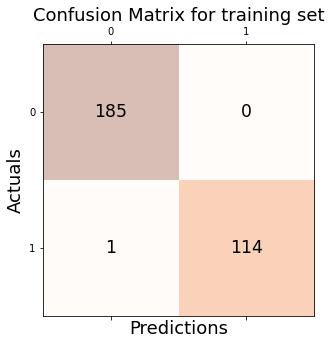

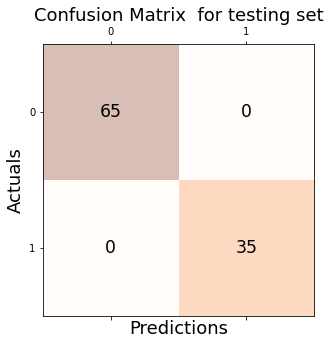

----------------- Overall Results -----------------
Accuracy Result for train set: 99.67%
Accuracy Result for test set: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%
AUC Result:100.00%


In [ ]:
# model fit
MLP = MLPClassifier(random_state=78412)
MLP.fit(X_train, y_train)

# prediction
preds_mlp = MLP.predict(X_test)
print(classification_report(y_test, preds_mlp))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=MLP.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_mlp)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, MLP.predict(X_train))
acc_mlp = accuracy_score(y_test, preds_mlp)

precision_mlp = precision_score(y_test, preds_mlp)*100    
recall_mlp = recall_score(y_test, preds_mlp)*100    
f1score_mlp = f1_score(y_test, preds_mlp)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_mlp*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_mlp))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_mlp)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_mlp)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_mlp)*100))

Let's plot the results

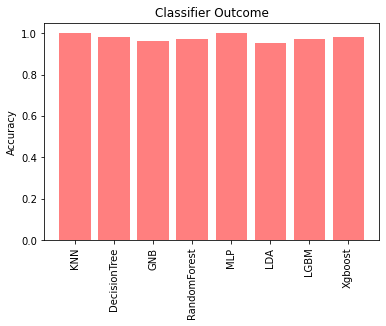

In [ ]:
#plotting the accuracy of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [acc_knn, acc_dt, acc_nb, acc_rf, acc_mlp, acc_lda, acc_lgbm, acc_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Classifier Outcome')
plt.show()

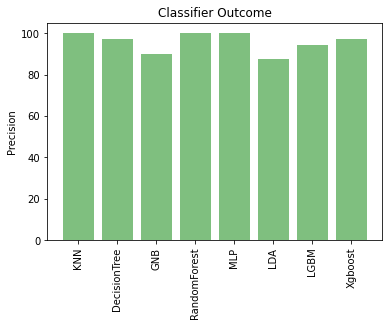

In [ ]:
#plotting the Precision of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [precision_knn, precision_dt, precision_nb, precision_rf, precision_mlp, precision_lda, precision_lgbm, precision_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='g')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Precision')
plt.title('Classifier Outcome')
plt.show()

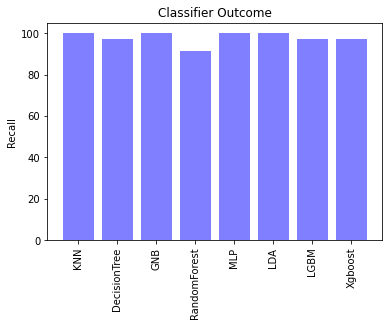

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [recall_knn, recall_dt, recall_nb, recall_rf, recall_mlp, recall_lda, recall_lgbm, recall_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='b')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Recall')
plt.title('Classifier Outcome')
plt.show()

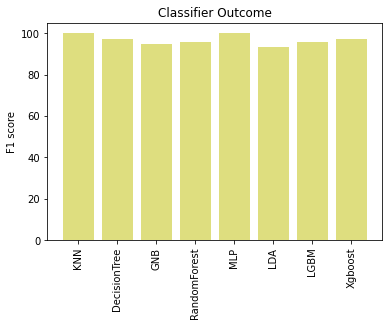

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [f1score_knn, f1score_dt, f1score_nb, f1score_rf, f1score_mlp,f1score_lda, f1score_lgbm, f1score_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='y')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('F1 score')
plt.title('Classifier Outcome')
plt.show()

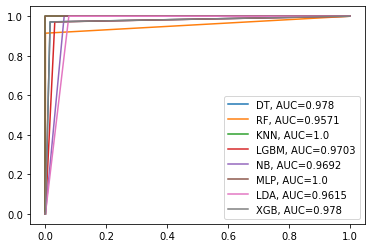

In [ ]:
#plotting the AUC of all models

# roc curve for classifiers before parameter tuning
fpr1, tpr1, _1 = roc_curve(y_test, preds_dt)
auc1 = round(roc_auc_score(y_test, preds_dt), 4)
plt.plot(fpr1,tpr1,label="DT, AUC="+str(auc1))

fpr2, tpr2, _2 = roc_curve(y_test,preds_rf)
auc2 = round(roc_auc_score(y_test, preds_rf), 4)
plt.plot(fpr2,tpr2,label="RF, AUC="+str(auc2))

fpr3, tpr3, _3 = roc_curve(y_test, preds_knn)
auc3 = round(roc_auc_score(y_test, preds_knn), 4)
plt.plot(fpr3,tpr3,label="KNN, AUC="+str(auc3))

fpr4, tpr4, _4 = roc_curve(y_test, preds_lgbm)
auc4 = round(roc_auc_score(y_test,preds_lgbm), 4)
plt.plot(fpr4,tpr4,label="LGBM, AUC="+str(auc4))

fpr5, tpr5, _5 = roc_curve(y_test, preds_nb)
auc5 = round(roc_auc_score(y_test, preds_nb), 4)
plt.plot(fpr5,tpr5,label="NB, AUC="+str(auc5))

fpr6, tpr6, _6 = roc_curve(y_test, preds_mlp)
auc6 = round(roc_auc_score(y_test, preds_mlp), 4)
plt.plot(fpr6,tpr6,label="MLP, AUC="+str(auc6))

fpr7, tpr7, _7 = roc_curve(y_test, preds_lda)
auc7 = round(roc_auc_score(y_test, preds_lda), 4)
plt.plot(fpr7,tpr7,label="LDA, AUC="+str(auc7))

fpr8, tpr8, _8 = roc_curve(y_test, preds_xgb)
auc8 = round(roc_auc_score(y_test, preds_xgb), 4)
plt.plot(fpr8,tpr8,label="XGB, AUC="+str(auc8))

plt.legend()


In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 0
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(GaussianNB())
classifiers.append(RandomForestClassifier())
classifiers.append(MLPClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier())
classifiers.append(XGBClassifier(use_label_encoder=False))

In [ ]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","DecisionTree","GNB",
"RandomForest","MLP","LDA","LGBM","Xgboost"]})

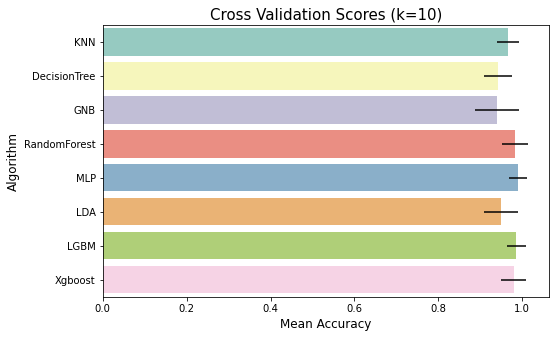

In [ ]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean Accuracy", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [ ]:
cv_res

CrossValMeans  CrossValerrors     Algorithm
0       0.966667        0.025820           KNN
1       0.943333        0.033500  DecisionTree
2       0.940000        0.053333           GNB
3       0.983333        0.030732  RandomForest
4       0.990000        0.021344           MLP
5       0.950000        0.040139           LDA
6       0.986667        0.022111          LGBM
7       0.980000        0.030551       Xgboost

# SFS feature selection

In [ ]:
# getting the original disposition of X and y
y = df['class']
X = pd.DataFrame(robust_df, columns =['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'hypertension',
       'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
       'pedal_edema', 'anemia'])

In [ ]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# apply the Sequential Feature Selection algorithm
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
dt = DecisionTreeClassifier()
sfs1 = SFS(dt, 
           k_features= 11, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10)
sfs1 = sfs1.fit(X, y)
sfs1.subsets_
# Which features?
feat_cols_sfs = list(sfs1.k_feature_idx_)
sfs1.k_score_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished

[2022-12-11 18:35:55] Features: 1/11 -- score: 0.8825[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s finished

[2022-12-11 18:35:56] Features: 2/11 -- score: 0.9524999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.2s finished

[2022-12-11 18:35:56] Features: 3/11 -- score: 0.9675[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:

0.9799999999999999

In [ ]:
y = y.values
X= X.values
# Train/test set generation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:, feat_cols_sfs], y, test_size=0.25, random_state=123)

Decision Tree Classifier

In [ ]:
# Grid search CV for Decision Tree before fs
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
grid_values = {'criterion':['gini','entropy'],
               'max_depth': np.arange(3, 15),
               'min_samples_leaf':np.arange(1, 5),
               'min_samples_split':np.arange(2, 10),
               'splitter':['best','random']
              }
grid_search_dt = GridSearchCV(dt, param_grid = grid_values, cv = 5, scoring = 'accuracy')
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'splitter': 'best'}

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96        65
         1.0       0.92      0.94      0.93        35

    accuracy                           0.95       100
   macro avg       0.94      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



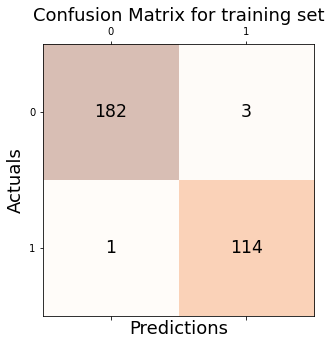

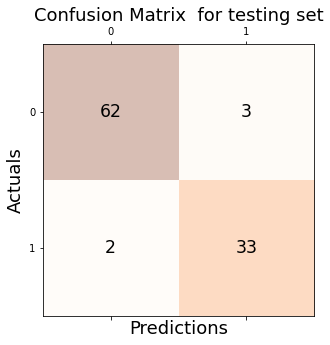

----------------- Overall Results -----------------
Accuracy Result for train set: 98.67%
Accuracy Result for test set: 95.00%
Precision Result: 91.67%
Recall Result: 94.29%
F1-Score Result: 92.96%
AUC Result:94.84%


In [ ]:
#Let's apply the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
DT = DecisionTreeClassifier(criterion = 'gini',random_state=7462, splitter='best', max_depth=4,
                            min_samples_leaf= 1, min_samples_split=5)
DT.fit(X_train, y_train)
#prediction phase
preds_dt = DT.predict(X_test)

print(classification_report(y_test, preds_dt))


conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=DT.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, DT.predict(X_train))
acc_dt = accuracy_score(y_test, preds_dt)
precision_dt = precision_score(y_test, preds_dt)*100    
recall_dt= recall_score(y_test, preds_dt)*100    
f1score_dt = f1_score(y_test, preds_dt)*100

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_dt*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_dt))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_dt)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_dt)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_dt)*100))

K Neighbors Classifier

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96        65
         1.0       0.94      0.91      0.93        35

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.95      0.95       100



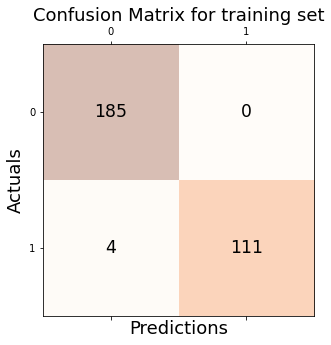

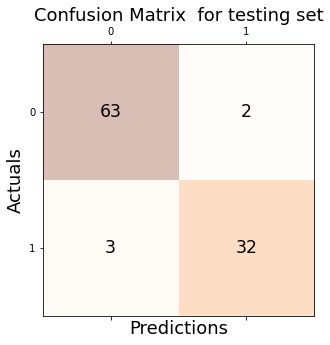

----------------- Overall Results -----------------
Accuracy Result for train set: 98.67%
Accuracy Result for test set: 95.00%
Precision Result: 94.12%
Recall Result: 91.43%
F1-Score Result: 92.75%
AUC Result:94.18%


In [ ]:
#let's apply KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
#predition phase
preds_knn=knn.predict(X_test)
print(classification_report(y_test, preds_knn))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=knn.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_knn)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, knn.predict(X_train))
acc_knn = accuracy_score(y_test, preds_knn)
precision_knn = precision_score(y_test, preds_knn)*100    
recall_knn= recall_score(y_test, preds_knn)*100    
f1score_knn = f1_score(y_test, preds_knn)*100
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_knn*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_knn))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_knn)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_knn)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_knn)*100))

LGBM Classifier

In [ ]:
import lightgbm as lgb
lgb=lgb.LGBMClassifier()
#Define the parameters
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}
#Define the scoring
clf=GridSearchCV(lgb,parameters,scoring='accuracy')
clf.fit(X=X_train, y=y_train)
print(clf.best_params_)

{'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 10, 'num_leaves': 20, 'reg_alpha': 0}


              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix of training set:- 
[[185   0]
 [  0 115]]

Confusion Matrix testing set:- 
[[64  1]
 [ 0 35]]



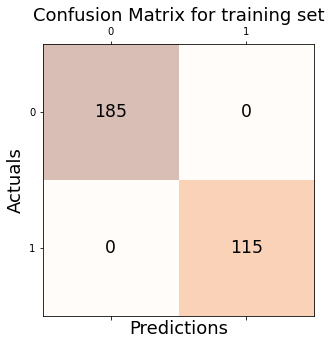

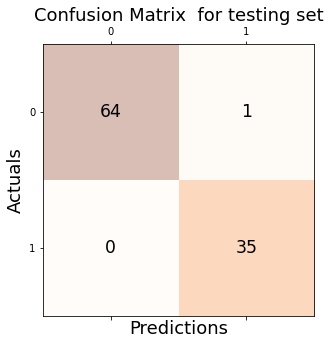

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 99.00%
Precision Result: 97.22%
Recall Result: 100.00%
F1-Score Result: 98.59%
AUC Result:99.23%


In [ ]:
# model fit
LGBM = LGBMClassifier(class_weight="balanced", n_estimators=1200, learning_rate=0.09, subsample=0.8, 
                      reg_alpha=0.8, reg_lambda=0.5)
LGBM.fit(X_train, y_train)

# prediction
preds_lgbm = LGBM.predict(X_test)
print(classification_report(y_test, preds_lgbm))
print(f"Confusion Matrix of training set:- \n{confusion_matrix(y_train, LGBM.predict(X_train))}\n")
print(f"Confusion Matrix testing set:- \n{confusion_matrix(y_test, preds_lgbm)}\n")

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=LGBM.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lgbm)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, LGBM.predict(X_train))
acc_lgbm = accuracy_score(y_test, preds_lgbm)
precision_lgbm = precision_score(y_test, preds_lgbm)*100    
recall_lgbm = recall_score(y_test, preds_lgbm)*100    
f1score_lgbm = f1_score(y_test, preds_lgbm)*100    
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lgbm*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lgbm))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lgbm)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lgbm)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lgbm)*100))

Gaussian NB

In [ ]:
#grid search for naive bayes algorithm
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 0.002848035868435802}

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93        65
         1.0       0.81      1.00      0.90        35

    accuracy                           0.92       100
   macro avg       0.91      0.94      0.92       100
weighted avg       0.93      0.92      0.92       100



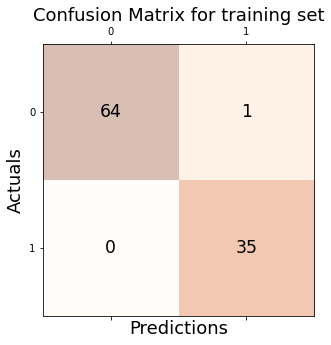

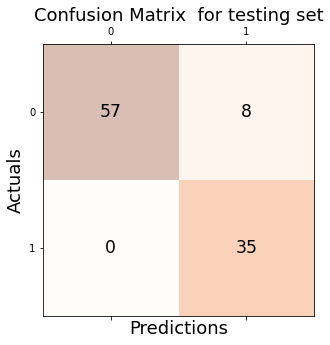

----------------- Overall Results -----------------
Accuracy Result for train set: 89.00%
Accuracy Result for test set: 92.00%
Precision Result: 81.40%
Recall Result: 100.00%
F1-Score Result: 89.74%
AUC Result:93.85%


In [ ]:
# model fit
NB = GaussianNB(var_smoothing= 0.01873817422860384)
NB.fit(X_train, y_train)

# prediction
preds_nb = NB.predict(X_test)
print(classification_report(y_test, preds_nb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=NB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_nb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, NB.predict(X_train))
acc_nb = accuracy_score(y_test, preds_nb)
precision_nb = precision_score(y_test, preds_nb)*100    
recall_nb = recall_score(y_test, preds_nb)*100    
f1score_nb = f1_score(y_test, preds_nb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_nb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_nb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_nb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_nb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_nb)*100))

Random Forest Classifier

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97        65
         1.0       0.97      0.91      0.94        35

    accuracy                           0.96       100
   macro avg       0.96      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100



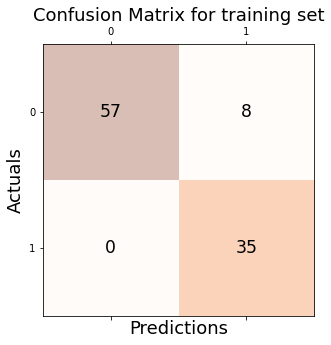

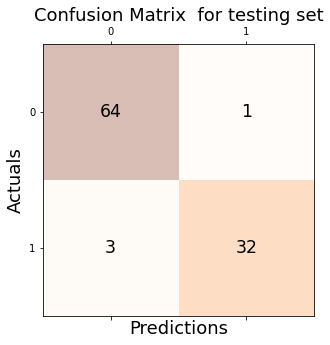

----------------- Overall Results -----------------
Accuracy Result for train set: 98.33%
Accuracy Result for test set: 96.00%
Precision Result: 96.97%
Recall Result: 91.43%
F1-Score Result: 94.12%
AUC Result:94.95%


In [ ]:
# model fit
rf = RandomForestClassifier(n_estimators=1000,  max_depth=12, max_leaf_nodes=6,random_state=7846, 
                            criterion ='entropy', max_features='sqrt')
rf.fit(X_train, y_train)

# prediction
preds_rf = rf.predict(X_test)
print(classification_report(y_test, preds_rf))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=rf.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_rf)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, rf.predict(X_train))
acc_rf = accuracy_score(y_test, preds_rf)
precision_rf = precision_score(y_test, preds_rf)*100    
recall_rf = recall_score(y_test, preds_rf)*100    
f1score_rf = f1_score(y_test, preds_rf)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_rf*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_rf))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_rf)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_rf)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_rf)*100))

Linear Discriminant Analysis

In [ ]:
# grid search for LDA
grid=dict()
grid['solver']=['svd', 'lsqr', 'eigen']
search=GridSearchCV(LinearDiscriminantAnalysis(), grid, scoring='accuracy', cv=10, n_jobs=-1 )
result=search.fit(X_train, y_train)
result.best_params_

{'solver': 'svd'}

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        65
         1.0       0.88      1.00      0.93        35

    accuracy                           0.95       100
   macro avg       0.94      0.96      0.95       100
weighted avg       0.96      0.95      0.95       100



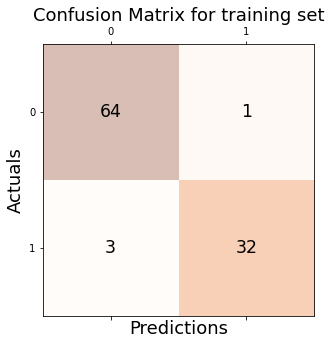

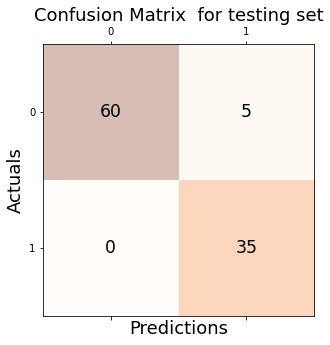

----------------- Overall Results -----------------
Accuracy Result for train set: 95.67%
Accuracy Result for test set: 95.00%
Precision Result: 87.50%
Recall Result: 100.00%
F1-Score Result: 93.33%
AUC Result:96.15%


In [ ]:
# model fit
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# prediction
preds_lda = lda.predict(X_test)
print(classification_report(y_test, preds_lda))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=lda.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lda)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, lda.predict(X_train))
acc_lda = accuracy_score(y_test, preds_lda)
precision_lda = precision_score(y_test, preds_lda)*100    
recall_lda = recall_score(y_test, preds_lda)*100    
f1score_lda = f1_score(y_test, preds_lda)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lda*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lda))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lda)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lda)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lda)*100))

XGBoost Classifier

[18:37:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



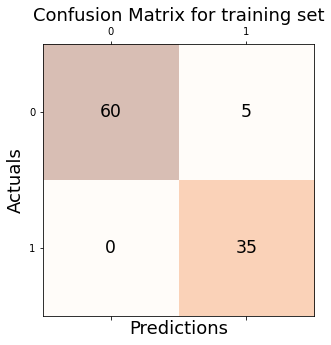

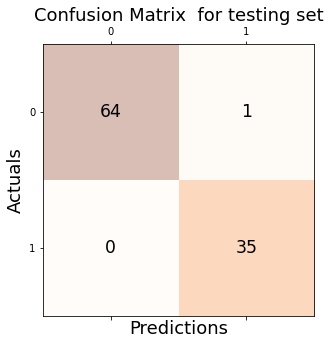

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 99.00%
Precision Result: 97.22%
Recall Result: 100.00%
F1-Score Result: 98.59%
AUC Result:99.23%


In [ ]:
# model fit
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

# prediction
preds_xgb = XGB.predict(X_test)
print(classification_report(y_test, preds_xgb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=XGB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_xgb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, XGB.predict(X_train))
acc_xgb = accuracy_score(y_test, preds_xgb)
precision_xgb = precision_score(y_test, preds_xgb)*100    
recall_xgb = recall_score(y_test, preds_xgb)*100    
f1score_xgb = f1_score(y_test, preds_xgb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_xgb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_xgb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_xgb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_xgb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_xgb)*100))

MLP Classifier

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



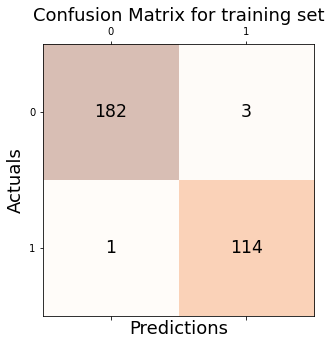

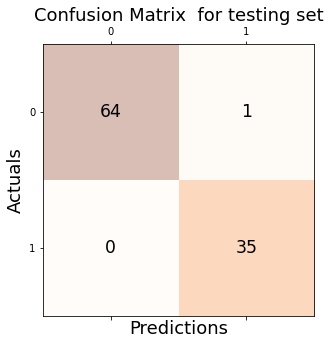

----------------- Overall Results -----------------
Accuracy Result for train set: 98.67%
Accuracy Result for test set: 99.00%
Precision Result: 97.22%
Recall Result: 100.00%
F1-Score Result: 98.59%
AUC Result:99.23%


In [ ]:
# model fit
MLP = MLPClassifier(random_state=7846)
MLP.fit(X_train, y_train)

# prediction
preds_mlp = MLP.predict(X_test)
print(classification_report(y_test, preds_mlp))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=MLP.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_mlp)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, MLP.predict(X_train))
acc_mlp = accuracy_score(y_test, preds_mlp)

precision_mlp = precision_score(y_test, preds_mlp)*100    
recall_mlp = recall_score(y_test, preds_mlp)*100    
f1score_mlp = f1_score(y_test, preds_mlp)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_mlp*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_mlp))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_mlp)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_mlp)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_mlp)*100))

Let's plot the results

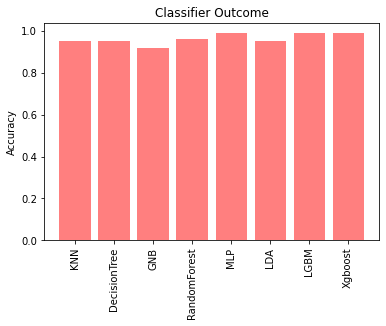

In [ ]:
#plotting the accuracy of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [acc_knn, acc_dt, acc_nb, acc_rf, acc_mlp, acc_lda, acc_lgbm, acc_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Classifier Outcome')
plt.show()

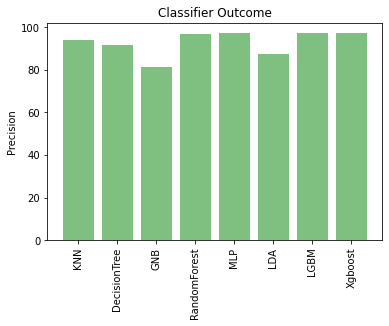

In [ ]:
#plotting the Precision of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [precision_knn, precision_dt, precision_nb, precision_rf, precision_mlp, precision_lda, precision_lgbm, precision_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='g')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Precision')
plt.title('Classifier Outcome')
plt.show()

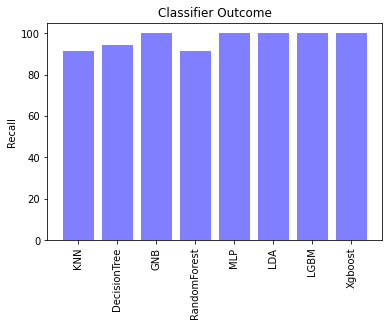

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [recall_knn, recall_dt, recall_nb, recall_rf, recall_mlp, recall_lda, recall_lgbm, recall_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='b')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Recall')
plt.title('Classifier Outcome')
plt.show()

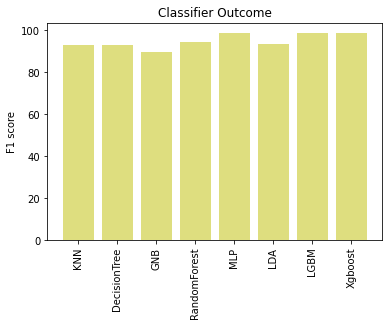

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [f1score_knn, f1score_dt, f1score_nb, f1score_rf, f1score_mlp,f1score_lda, f1score_lgbm, f1score_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='y')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('F1 score')
plt.title('Classifier Outcome')
plt.show()

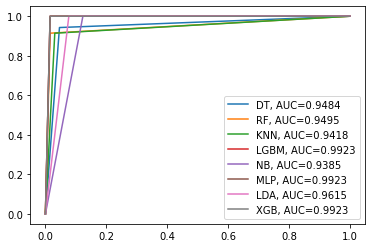

In [ ]:
#plotting the AUC of all models

# roc curve for classifiers before parameter tuning
fpr1, tpr1, _1 = roc_curve(y_test, preds_dt)
auc1 = round(roc_auc_score(y_test, preds_dt), 4)
plt.plot(fpr1,tpr1,label="DT, AUC="+str(auc1))

fpr2, tpr2, _2 = roc_curve(y_test,preds_rf)
auc2 = round(roc_auc_score(y_test, preds_rf), 4)
plt.plot(fpr2,tpr2,label="RF, AUC="+str(auc2))

fpr3, tpr3, _3 = roc_curve(y_test, preds_knn)
auc3 = round(roc_auc_score(y_test, preds_knn), 4)
plt.plot(fpr3,tpr3,label="KNN, AUC="+str(auc3))

fpr4, tpr4, _4 = roc_curve(y_test, preds_lgbm)
auc4 = round(roc_auc_score(y_test,preds_lgbm), 4)
plt.plot(fpr4,tpr4,label="LGBM, AUC="+str(auc4))

fpr5, tpr5, _5 = roc_curve(y_test, preds_nb)
auc5 = round(roc_auc_score(y_test, preds_nb), 4)
plt.plot(fpr5,tpr5,label="NB, AUC="+str(auc5))

fpr6, tpr6, _6 = roc_curve(y_test, preds_mlp)
auc6 = round(roc_auc_score(y_test, preds_mlp), 4)
plt.plot(fpr6,tpr6,label="MLP, AUC="+str(auc6))

fpr7, tpr7, _7 = roc_curve(y_test, preds_lda)
auc7 = round(roc_auc_score(y_test, preds_lda), 4)
plt.plot(fpr7,tpr7,label="LDA, AUC="+str(auc7))

fpr8, tpr8, _8 = roc_curve(y_test, preds_xgb)
auc8 = round(roc_auc_score(y_test, preds_xgb), 4)
plt.plot(fpr8,tpr8,label="XGB, AUC="+str(auc8))

plt.legend()


In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 0
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(GaussianNB())
classifiers.append(RandomForestClassifier())
classifiers.append(MLPClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier())
classifiers.append(XGBClassifier(use_label_encoder=False))

In [ ]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","DecisionTree","GNB",
"RandomForest","MLP","LDA","LGBM","Xgboost"]})

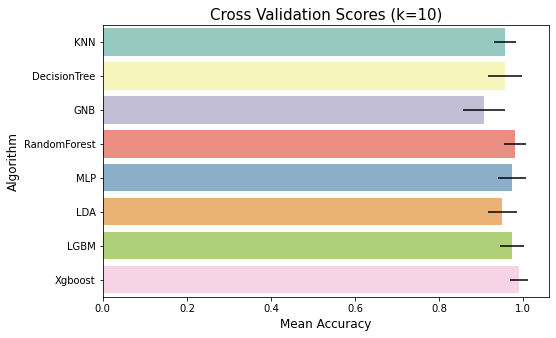

In [ ]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean Accuracy", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [ ]:
cv_res

CrossValMeans  CrossValerrors     Algorithm
0       0.956667        0.026034           KNN
1       0.956667        0.039581  DecisionTree
2       0.906667        0.048990           GNB
3       0.980000        0.026667  RandomForest
4       0.973333        0.032660           MLP
5       0.950000        0.034157           LDA
6       0.973333        0.029059          LGBM
7       0.990000        0.021344       Xgboost

# With Balancing the data

As we have seen previously, our data is indeed imbalanced with a ratio of 62.5 and 37.5 for the target
To counter this issue, we decided to check a couple of methods that help with this issue: undersampling and oversampling.
Undersampling will be innappropriate as the dataset is quite small, the overapling will be more redeeming and we have high hopes for it. The algorithm used is smote as it is quite powerful and precise

In [ ]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
y = df['class']
X = pd.DataFrame(robust_df, columns =['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'hypertension',
       'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
       'pedal_edema', 'anemia'])

In [ ]:
# applying the smote algorithm on the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

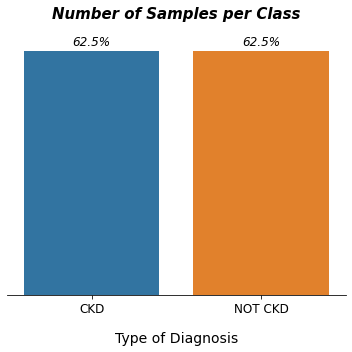

In [ ]:
# plotting the class variable disposition after the oversampling
plt.figure(figsize=(5, 5))

sns.countplot(x = y)
sns.despine(top=True, right=True, left=True, bottom=False)

plt.xticks(ticks= [0,1], labels=['CKD', 'NOT CKD'], fontsize=12)
plt.yticks([])
plt.title('Number of Samples per Class' , fontsize=15 , pad=20 , fontstyle='italic' , fontweight = 800)
plt.xlabel('Type of Diagnosis' , fontsize=14 , fontweight=400, labelpad=16)
plt.ylabel('')
ax = plt.gca()

for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/df.shape[0])), (p.get_x() + p.get_width() / 2., abs(p.get_height())), ha='center', 
                va='bottom', color='black', xytext=(0,2), rotation='horizontal', textcoords='offset points', fontsize = 12, fontstyle = 'italic')

# plt.savefig("samples.png")
plt.tight_layout()

In [ ]:
X = X.values
y = y.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Data Balancing Without feature selection

Decision Tree Classifier

In [ ]:
# Grid search CV for Decision Tree before fs
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
grid_values = {'criterion':['gini','entropy'],
               'max_depth': np.arange(3, 15),
               'min_samples_leaf':np.arange(1, 5),
               'min_samples_split':np.arange(2, 10),
               'splitter':['best','random']
              }
grid_search_dt = GridSearchCV(dt, param_grid = grid_values, cv = 5, scoring = 'accuracy')
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 9,
 'splitter': 'random'}

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        65
         1.0       0.98      0.98      0.98        60

    accuracy                           0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



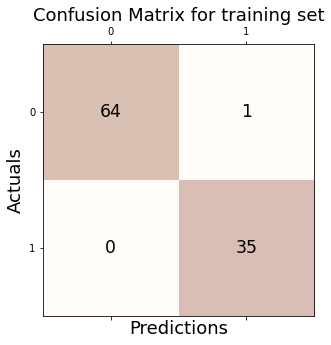

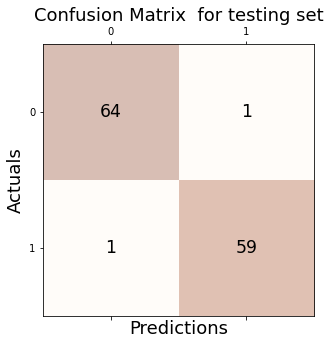

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 98.40%
Precision Result: 98.33%
Recall Result: 98.33%
F1-Score Result: 98.33%
AUC Result:98.40%


In [ ]:
#Let's apply the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
DT = DecisionTreeClassifier(criterion = 'gini',random_state=7624, splitter='random', max_depth=7,
                            min_samples_leaf= 1, min_samples_split= 3)
DT.fit(X_train, y_train)
#prediction phase
preds_dt = DT.predict(X_test)

print(classification_report(y_test, preds_dt))


conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=DT.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, DT.predict(X_train))
acc_dt = accuracy_score(y_test, preds_dt)
precision_dt = precision_score(y_test, preds_dt)*100    
recall_dt= recall_score(y_test, preds_dt)*100    
f1score_dt = f1_score(y_test, preds_dt)*100

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_dt*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_dt))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_dt)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_dt)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_dt)*100))

K Neighbors Classifier

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        65
         1.0       0.95      1.00      0.98        60

    accuracy                           0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



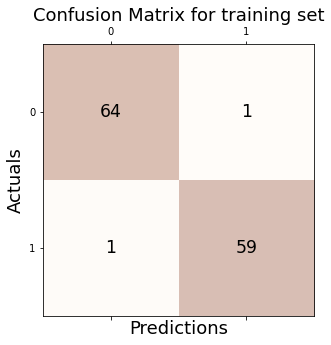

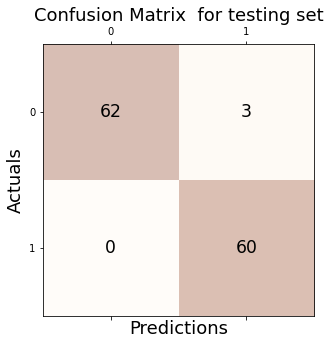

----------------- Overall Results -----------------
Accuracy Result for train set: 99.73%
Accuracy Result for test set: 97.60%
Precision Result: 95.24%
Recall Result: 100.00%
F1-Score Result: 97.56%
AUC Result:97.69%


In [ ]:
#let's apply KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
#predition phase
preds_knn=knn.predict(X_test)
print(classification_report(y_test, preds_knn))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=knn.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_knn)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, knn.predict(X_train))
acc_knn = accuracy_score(y_test, preds_knn)
precision_knn = precision_score(y_test, preds_knn)*100    
recall_knn= recall_score(y_test, preds_knn)*100    
f1score_knn = f1_score(y_test, preds_knn)*100
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_knn*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_knn))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_knn)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_knn)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_knn)*100))

LGBM Classifier

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.98      1.00      0.99        60

    accuracy                           0.99       125
   macro avg       0.99      0.99      0.99       125
weighted avg       0.99      0.99      0.99       125

Confusion Matrix of training set:- 
[[185   0]
 [  0 190]]

Confusion Matrix testing set:- 
[[64  1]
 [ 0 60]]



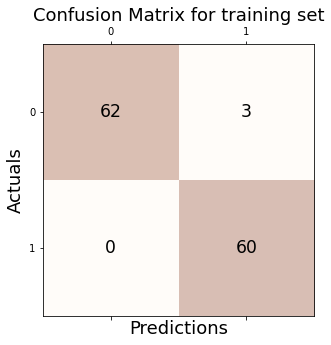

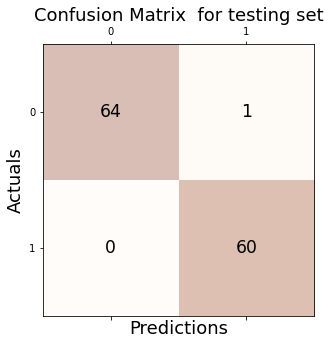

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 99.20%
Precision Result: 98.36%
Recall Result: 100.00%
F1-Score Result: 99.17%
AUC Result:99.23%


In [ ]:
# model fit
LGBM = LGBMClassifier()
LGBM.fit(X_train, y_train)

# prediction
preds_lgbm = LGBM.predict(X_test)
print(classification_report(y_test, preds_lgbm))
print(f"Confusion Matrix of training set:- \n{confusion_matrix(y_train, LGBM.predict(X_train))}\n")
print(f"Confusion Matrix testing set:- \n{confusion_matrix(y_test, preds_lgbm)}\n")

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=LGBM.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lgbm)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, LGBM.predict(X_train))
acc_lgbm = accuracy_score(y_test, preds_lgbm)
precision_lgbm = precision_score(y_test, preds_lgbm)*100    
recall_lgbm = recall_score(y_test, preds_lgbm)*100    
f1score_lgbm = f1_score(y_test, preds_lgbm)*100    
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lgbm*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lgbm))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lgbm)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lgbm)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lgbm)*100))

Gaussian NB

In [ ]:
#grid search for naive bayes algorithm
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 0.0012328467394420659}

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95        65
         1.0       0.92      0.98      0.95        60

    accuracy                           0.95       125
   macro avg       0.95      0.95      0.95       125
weighted avg       0.95      0.95      0.95       125



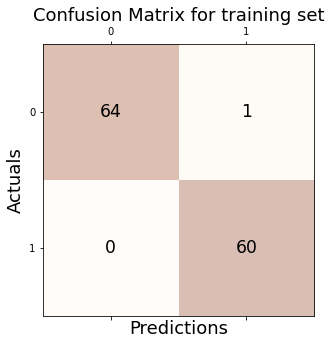

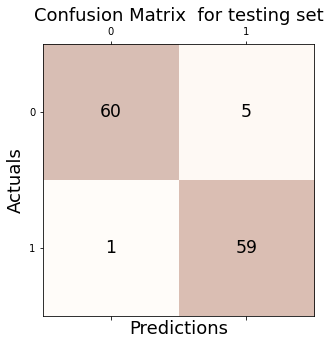

----------------- Overall Results -----------------
Accuracy Result for train set: 97.60%
Accuracy Result for test set: 95.20%
Precision Result: 92.19%
Recall Result: 98.33%
F1-Score Result: 95.16%
AUC Result:95.32%


In [ ]:
# model fit
NB = GaussianNB(var_smoothing= 0.0012328467394420659)
NB.fit(X_train, y_train)

# prediction
preds_nb = NB.predict(X_test)
print(classification_report(y_test, preds_nb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=NB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_nb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, NB.predict(X_train))
acc_nb = accuracy_score(y_test, preds_nb)
precision_nb = precision_score(y_test, preds_nb)*100    
recall_nb = recall_score(y_test, preds_nb)*100    
f1score_nb = f1_score(y_test, preds_nb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_nb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_nb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_nb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_nb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_nb)*100))

Random Forest Classifier

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        60

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



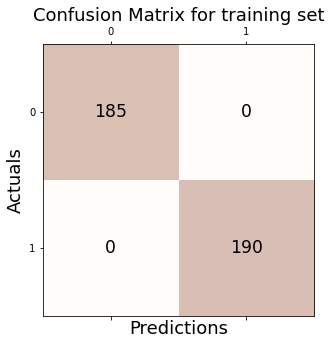

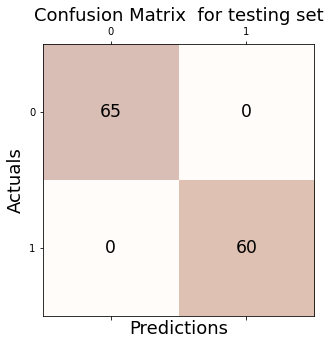

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%
AUC Result:100.00%


In [ ]:
# model fit
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# prediction
preds_rf = rf.predict(X_test)
print(classification_report(y_test, preds_rf))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=rf.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_rf)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, rf.predict(X_train))
acc_rf = accuracy_score(y_test, preds_rf)
precision_rf = precision_score(y_test, preds_rf)*100    
recall_rf = recall_score(y_test, preds_rf)*100    
f1score_rf = f1_score(y_test, preds_rf)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_rf*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_rf))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_rf)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_rf)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_rf)*100))

Linear Discriminant Analysis

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        65
         1.0       0.91      1.00      0.95        60

    accuracy                           0.95       125
   macro avg       0.95      0.95      0.95       125
weighted avg       0.96      0.95      0.95       125



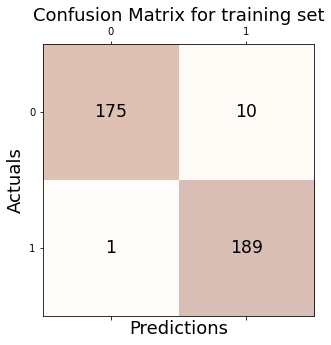

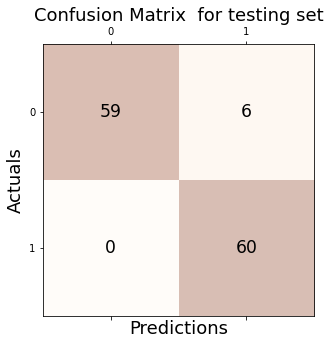

----------------- Overall Results -----------------
Accuracy Result for train set: 97.07%
Accuracy Result for test set: 95.20%
Precision Result: 90.91%
Recall Result: 100.00%
F1-Score Result: 95.24%
AUC Result:95.38%


In [ ]:
# model fit
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# prediction
preds_lda = lda.predict(X_test)
print(classification_report(y_test, preds_lda))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=lda.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lda)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, lda.predict(X_train))
acc_lda = accuracy_score(y_test, preds_lda)
precision_lda = precision_score(y_test, preds_lda)*100    
recall_lda = recall_score(y_test, preds_lda)*100    
f1score_lda = f1_score(y_test, preds_lda)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lda*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lda))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lda)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lda)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lda)*100))

XGB Classifier

[18:37:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.98      1.00      0.99        60

    accuracy                           0.99       125
   macro avg       0.99      0.99      0.99       125
weighted avg       0.99      0.99      0.99       125



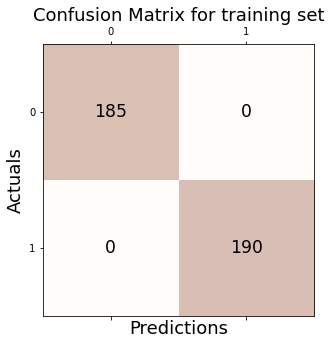

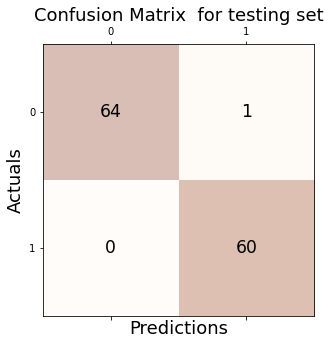

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 99.20%
Precision Result: 98.36%
Recall Result: 100.00%
F1-Score Result: 99.17%
AUC Result:99.23%


In [ ]:
# model fit
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

# prediction
preds_xgb = XGB.predict(X_test)
print(classification_report(y_test, preds_xgb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=XGB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_xgb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, XGB.predict(X_train))
acc_xgb = accuracy_score(y_test, preds_xgb)
precision_xgb = precision_score(y_test, preds_xgb)*100    
recall_xgb = recall_score(y_test, preds_xgb)*100    
f1score_xgb = f1_score(y_test, preds_xgb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_xgb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_xgb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_xgb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_xgb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_xgb)*100))

MLP Classifier

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.98      1.00      0.99        60

    accuracy                           0.99       125
   macro avg       0.99      0.99      0.99       125
weighted avg       0.99      0.99      0.99       125



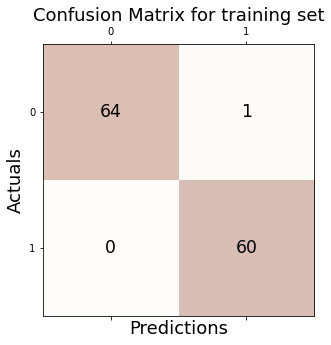

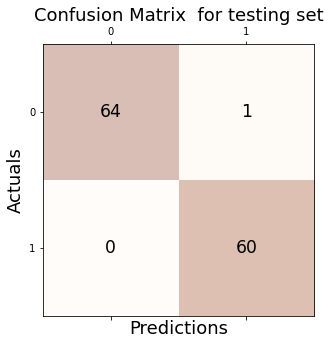

----------------- Overall Results -----------------
Accuracy Result for train set: 99.47%
Accuracy Result for test set: 99.20%
Precision Result: 98.36%
Recall Result: 100.00%
F1-Score Result: 99.17%
AUC Result:99.23%


In [ ]:
# model fit
MLP = MLPClassifier(random_state=976324)
MLP.fit(X_train, y_train)

# prediction
preds_mlp = MLP.predict(X_test)
print(classification_report(y_test, preds_mlp))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=MLP.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_mlp)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, MLP.predict(X_train))
acc_mlp = accuracy_score(y_test, preds_mlp)

precision_mlp = precision_score(y_test, preds_mlp)*100    
recall_mlp = recall_score(y_test, preds_mlp)*100    
f1score_mlp = f1_score(y_test, preds_mlp)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_mlp*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_mlp))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_mlp)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_mlp)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_mlp)*100))

Let's plot the results

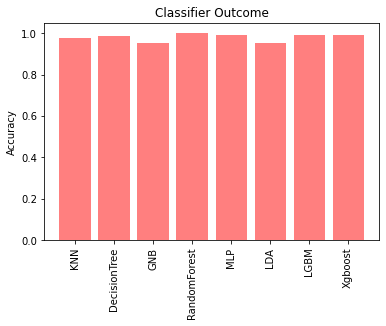

In [ ]:
#plotting the accuracy of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [acc_knn, acc_dt, acc_nb, acc_rf, acc_mlp, acc_lda, acc_lgbm, acc_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Classifier Outcome')
plt.show()

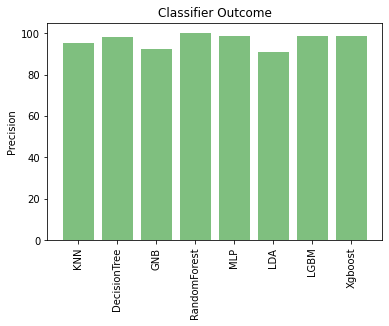

In [ ]:
#plotting the Precision of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [precision_knn, precision_dt, precision_nb, precision_rf, precision_mlp, precision_lda, precision_lgbm, precision_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='g')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Precision')
plt.title('Classifier Outcome')
plt.show()

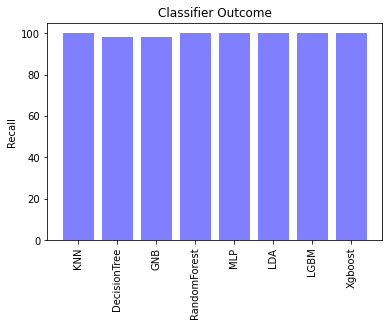

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [recall_knn, recall_dt, recall_nb, recall_rf, recall_mlp, recall_lda, recall_lgbm, recall_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='b')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Recall')
plt.title('Classifier Outcome')
plt.show()

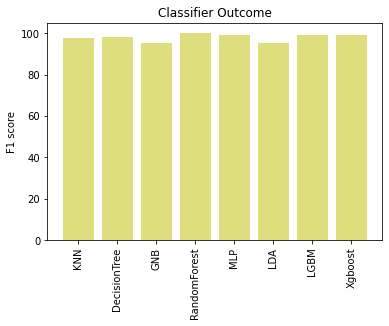

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [f1score_knn, f1score_dt, f1score_nb, f1score_rf, f1score_mlp,f1score_lda, f1score_lgbm, f1score_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='y')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('F1 score')
plt.title('Classifier Outcome')
plt.show()

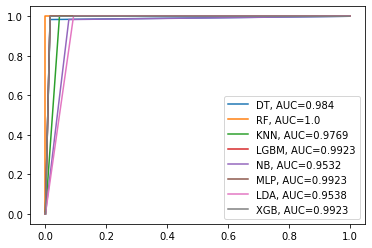

In [ ]:
#plotting the AUC of all models

# roc curve for classifiers before parameter tuning
fpr1, tpr1, _1 = roc_curve(y_test, preds_dt)
auc1 = round(roc_auc_score(y_test, preds_dt), 4)
plt.plot(fpr1,tpr1,label="DT, AUC="+str(auc1))

fpr2, tpr2, _2 = roc_curve(y_test,preds_rf)
auc2 = round(roc_auc_score(y_test, preds_rf), 4)
plt.plot(fpr2,tpr2,label="RF, AUC="+str(auc2))

fpr3, tpr3, _3 = roc_curve(y_test, preds_knn)
auc3 = round(roc_auc_score(y_test, preds_knn), 4)
plt.plot(fpr3,tpr3,label="KNN, AUC="+str(auc3))

fpr4, tpr4, _4 = roc_curve(y_test, preds_lgbm)
auc4 = round(roc_auc_score(y_test,preds_lgbm), 4)
plt.plot(fpr4,tpr4,label="LGBM, AUC="+str(auc4))

fpr5, tpr5, _5 = roc_curve(y_test, preds_nb)
auc5 = round(roc_auc_score(y_test, preds_nb), 4)
plt.plot(fpr5,tpr5,label="NB, AUC="+str(auc5))

fpr6, tpr6, _6 = roc_curve(y_test, preds_mlp)
auc6 = round(roc_auc_score(y_test, preds_mlp), 4)
plt.plot(fpr6,tpr6,label="MLP, AUC="+str(auc6))

fpr7, tpr7, _7 = roc_curve(y_test, preds_lda)
auc7 = round(roc_auc_score(y_test, preds_lda), 4)
plt.plot(fpr7,tpr7,label="LDA, AUC="+str(auc7))

fpr8, tpr8, _8 = roc_curve(y_test, preds_xgb)
auc8 = round(roc_auc_score(y_test, preds_xgb), 4)
plt.plot(fpr8,tpr8,label="XGB, AUC="+str(auc8))

plt.legend()


Cross validation results

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 0
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(GaussianNB())
classifiers.append(RandomForestClassifier())
classifiers.append(MLPClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier())
classifiers.append(XGBClassifier(use_label_encoder=False))

In [ ]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","DecisionTree","GNB",
"RandomForest","MLP","LDA","LGBM","Xgboost"]})

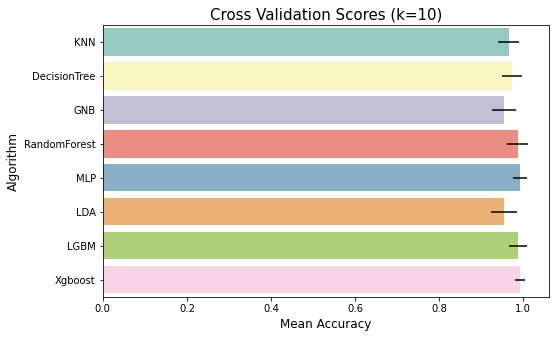

In [ ]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean Accuracy", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [ ]:
cv_res

CrossValMeans  CrossValerrors     Algorithm
0       0.965292        0.024157           KNN
1       0.973257        0.024019  DecisionTree
2       0.954908        0.028854           GNB
3       0.986558        0.024880  RandomForest
4       0.991963        0.017229           MLP
5       0.954836        0.031483           LDA
6       0.986700        0.021484          LGBM
7       0.991963        0.012278       Xgboost

# Data Balancing With Feature selection

# MRMR feature selection

In [ ]:
pip install mrmr-selection

Note: you may need to restart the kernel to use updated packages.


In [ ]:
y = df['class']
X = pd.DataFrame(robust_df, columns =['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'hypertension',
       'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
       'pedal_edema', 'anemia'])

In [ ]:
from mrmr import mrmr_classif
selected_features_mrmr = mrmr_classif(X=X, y=y, K=11)

selected_features_mrmr

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.80it/s]


['haemoglobin',
 'specific_gravity',
 'packed_cell_volume',
 'albumin',
 'hypertension',
 'diabetes_mellitus',
 'red_blood_cell_count',
 'red_blood_cells',
 'blood_glucose_random',
 'appetite',
 'pedal_edema']

In [ ]:
# We will get the column idexes of the selected feature to be able to use during trainin and testing
mrmr_subset_list = []
for i in selected_features_mrmr: 
    column_index = df.columns.get_loc(i)
    mrmr_subset_list.append(column_index)

In [ ]:
y = y.values
X= X.values
# Train/test set generation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:, mrmr_subset_list], y, test_size=0.25, random_state=123)

Decision Tree Classifier

In [ ]:
# Grid search CV for Decision Tree after fs
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
grid_values = {'criterion':['gini','entropy'],
               'max_depth': np.arange(3, 15),
               'min_samples_leaf':np.arange(1, 5),
               'min_samples_split':np.arange(2, 10),
               'splitter':['best','random']
              }
grid_search_dt = GridSearchCV(dt, param_grid = grid_values, cv = 5, scoring = 'accuracy')
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'splitter': 'random'}

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



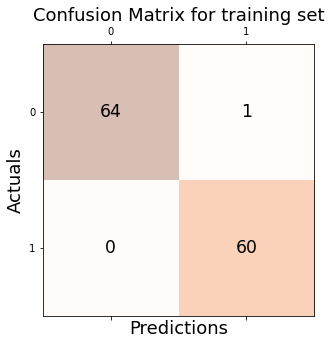

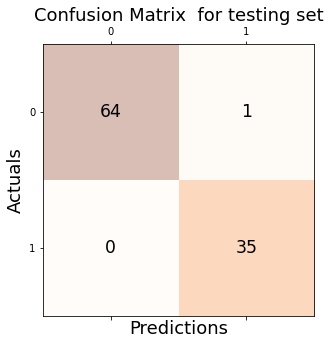

----------------- Overall Results -----------------
Accuracy Result for train set: 99.67%
Accuracy Result for test set: 99.00%
Precision Result: 97.22%
Recall Result: 100.00%
F1-Score Result: 98.59%
AUC Result:99.23%


In [ ]:
#Let's apply the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
DT = DecisionTreeClassifier(criterion = 'entropy',random_state=8432, splitter='random', 
                            max_depth=10,min_samples_leaf= 1, min_samples_split= 5)
DT.fit(X_train, y_train)
#prediction phase
preds_dt = DT.predict(X_test)

print(classification_report(y_test, preds_dt))


conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=DT.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, DT.predict(X_train))
acc_dt = accuracy_score(y_test, preds_dt)
precision_dt = precision_score(y_test, preds_dt)*100    
recall_dt= recall_score(y_test, preds_dt)*100    
f1score_dt = f1_score(y_test, preds_dt)*100

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_dt*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_dt))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_dt)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_dt)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_dt)*100))

K Neighbors Classifier

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



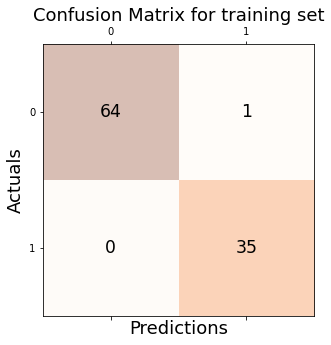

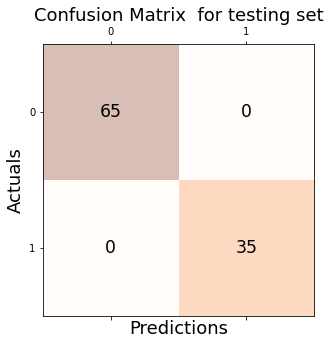

----------------- Overall Results -----------------
Accuracy Result for train set: 99.33%
Accuracy Result for test set: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%
AUC Result:100.00%


In [ ]:
#let's apply KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
#predition phase
preds_knn=knn.predict(X_test)
print(classification_report(y_test, preds_knn))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=knn.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_knn)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, knn.predict(X_train))
acc_knn = accuracy_score(y_test, preds_knn)
precision_knn = precision_score(y_test, preds_knn)*100    
recall_knn= recall_score(y_test, preds_knn)*100    
f1score_knn = f1_score(y_test, preds_knn)*100
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_knn*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_knn))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_knn)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_knn)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_knn)*100))

LGBM Classifier

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98        65
         1.0       0.94      0.97      0.96        35

    accuracy                           0.97       100
   macro avg       0.96      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

Confusion Matrix of training set:- 
[[185   0]
 [  0 115]]

Confusion Matrix testing set:- 
[[63  2]
 [ 1 34]]



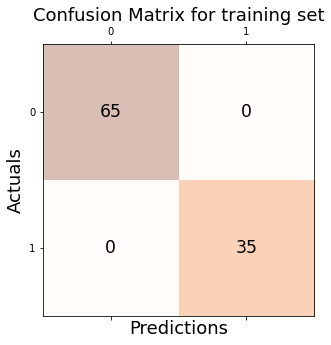

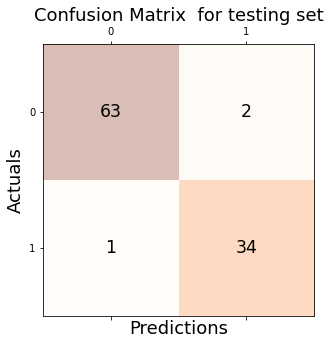

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 97.00%
Precision Result: 94.44%
Recall Result: 97.14%
F1-Score Result: 95.77%
AUC Result:97.03%


In [ ]:
# model fit
LGBM = LGBMClassifier()
LGBM.fit(X_train, y_train)

# prediction
preds_lgbm = LGBM.predict(X_test)
print(classification_report(y_test, preds_lgbm))
print(f"Confusion Matrix of training set:- \n{confusion_matrix(y_train, LGBM.predict(X_train))}\n")
print(f"Confusion Matrix testing set:- \n{confusion_matrix(y_test, preds_lgbm)}\n")

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=LGBM.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lgbm)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, LGBM.predict(X_train))
acc_lgbm = accuracy_score(y_test, preds_lgbm)
precision_lgbm = precision_score(y_test, preds_lgbm)*100    
recall_lgbm = recall_score(y_test, preds_lgbm)*100    
f1score_lgbm = f1_score(y_test, preds_lgbm)*100    
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lgbm*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lgbm))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lgbm)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lgbm)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lgbm)*100))

Gaussian NB

In [ ]:
#grid search for naive bayes algorithm
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 0.02310129700083159}

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        65
         1.0       0.90      1.00      0.95        35

    accuracy                           0.96       100
   macro avg       0.95      0.97      0.96       100
weighted avg       0.96      0.96      0.96       100



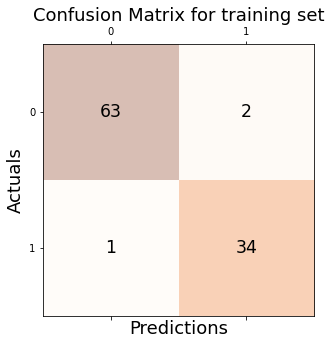

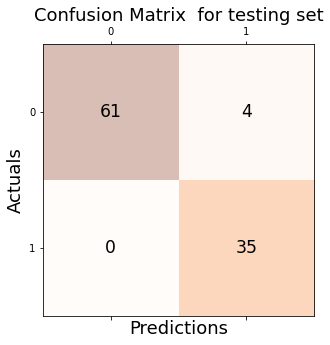

----------------- Overall Results -----------------
Accuracy Result for train set: 97.33%
Accuracy Result for test set: 96.00%
Precision Result: 89.74%
Recall Result: 100.00%
F1-Score Result: 94.59%
AUC Result:96.92%


In [ ]:
# model fit
NB = GaussianNB(var_smoothing=0.02310129700083159)
NB.fit(X_train, y_train)

# prediction
preds_nb = NB.predict(X_test)
print(classification_report(y_test, preds_nb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=NB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_nb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, NB.predict(X_train))
acc_nb = accuracy_score(y_test, preds_nb)
precision_nb = precision_score(y_test, preds_nb)*100    
recall_nb = recall_score(y_test, preds_nb)*100    
f1score_nb = f1_score(y_test, preds_nb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_nb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_nb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_nb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_nb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_nb)*100))

Random Forest Classifier

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        65
         1.0       1.00      0.91      0.96        35

    accuracy                           0.97       100
   macro avg       0.98      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100



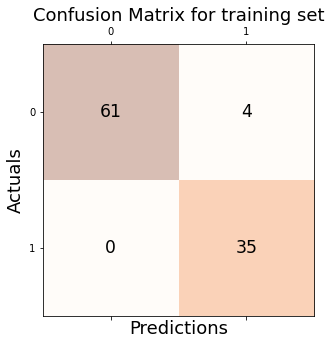

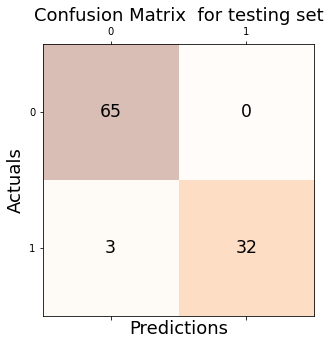

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 97.00%
Precision Result: 100.00%
Recall Result: 91.43%
F1-Score Result: 95.52%
AUC Result:95.71%


In [ ]:
# model fit
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# prediction
preds_rf = rf.predict(X_test)
print(classification_report(y_test, preds_rf))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=rf.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_rf)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, rf.predict(X_train))
acc_rf = accuracy_score(y_test, preds_rf)
precision_rf = precision_score(y_test, preds_rf)*100    
recall_rf = recall_score(y_test, preds_rf)*100    
f1score_rf = f1_score(y_test, preds_rf)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_rf*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_rf))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_rf)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_rf)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_rf)*100))

Linear Discriminant Analysis

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        65
         1.0       0.88      1.00      0.93        35

    accuracy                           0.95       100
   macro avg       0.94      0.96      0.95       100
weighted avg       0.96      0.95      0.95       100



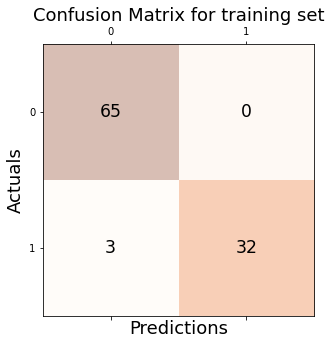

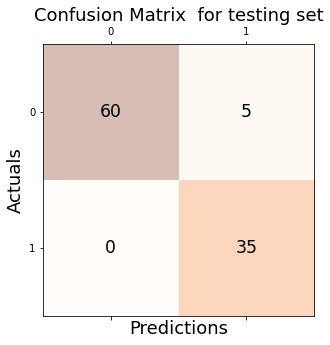

----------------- Overall Results -----------------
Accuracy Result for train set: 95.67%
Accuracy Result for test set: 95.00%
Precision Result: 87.50%
Recall Result: 100.00%
F1-Score Result: 93.33%
AUC Result:96.15%


In [ ]:
# model fit
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# prediction
preds_lda = lda.predict(X_test)
print(classification_report(y_test, preds_lda))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=lda.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lda)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, lda.predict(X_train))
acc_lda = accuracy_score(y_test, preds_lda)
precision_lda = precision_score(y_test, preds_lda)*100    
recall_lda = recall_score(y_test, preds_lda)*100    
f1score_lda = f1_score(y_test, preds_lda)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lda*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lda))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lda)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lda)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lda)*100))

XGB Classifier

[18:37:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98        65
         1.0       0.94      0.97      0.96        35

    accuracy                           0.97       100
   macro avg       0.96      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



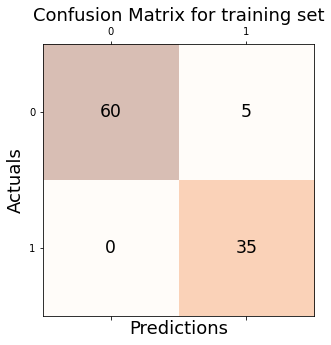

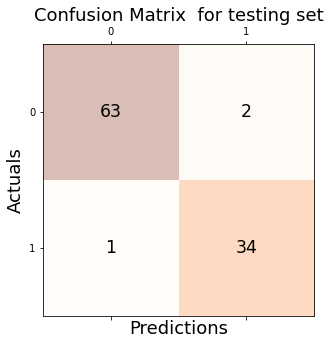

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 97.00%
Precision Result: 94.44%
Recall Result: 97.14%
F1-Score Result: 95.77%
AUC Result:97.03%


In [ ]:
# model fit
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

# prediction
preds_xgb = XGB.predict(X_test)
print(classification_report(y_test, preds_xgb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=XGB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_xgb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, XGB.predict(X_train))
acc_xgb = accuracy_score(y_test, preds_xgb)
precision_xgb = precision_score(y_test, preds_xgb)*100    
recall_xgb = recall_score(y_test, preds_xgb)*100    
f1score_xgb = f1_score(y_test, preds_xgb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_xgb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_xgb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_xgb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_xgb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_xgb)*100))

MLP Classifier

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        65
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



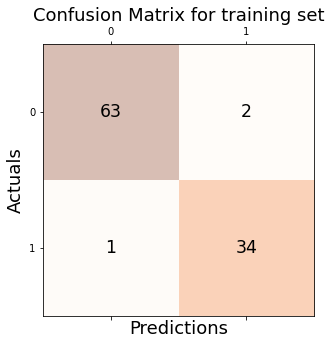

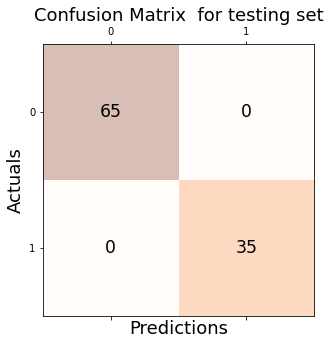

----------------- Overall Results -----------------
Accuracy Result for train set: 99.67%
Accuracy Result for test set: 100.00%
Precision Result: 100.00%
Recall Result: 100.00%
F1-Score Result: 100.00%
AUC Result:100.00%


In [ ]:
# model fit
MLP = MLPClassifier(random_state=42587)
MLP.fit(X_train, y_train)

# prediction
preds_mlp = MLP.predict(X_test)
print(classification_report(y_test, preds_mlp))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=MLP.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_mlp)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, MLP.predict(X_train))
acc_mlp = accuracy_score(y_test, preds_mlp)

precision_mlp = precision_score(y_test, preds_mlp)*100    
recall_mlp = recall_score(y_test, preds_mlp)*100    
f1score_mlp = f1_score(y_test, preds_mlp)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_mlp*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_mlp))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_mlp)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_mlp)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_mlp)*100))

Let's plot the results

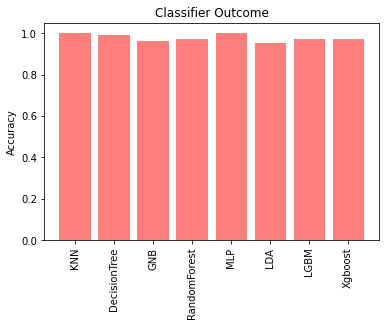

In [ ]:
#plotting the accuracy of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [acc_knn, acc_dt, acc_nb, acc_rf, acc_mlp, acc_lda, acc_lgbm, acc_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Classifier Outcome')
plt.show()

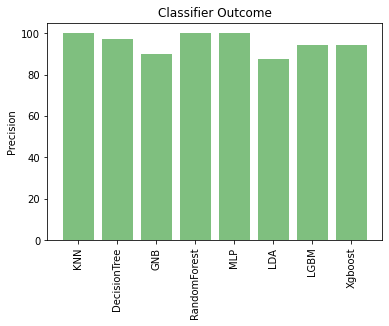

In [ ]:
#plotting the Precision of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [precision_knn, precision_dt, precision_nb, precision_rf, precision_mlp, precision_lda, precision_lgbm, precision_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='g')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Precision')
plt.title('Classifier Outcome')
plt.show()

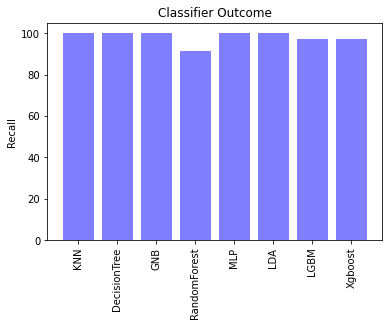

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [recall_knn, recall_dt, recall_nb, recall_rf, recall_mlp, recall_lda, recall_lgbm, recall_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='b')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Recall')
plt.title('Classifier Outcome')
plt.show()

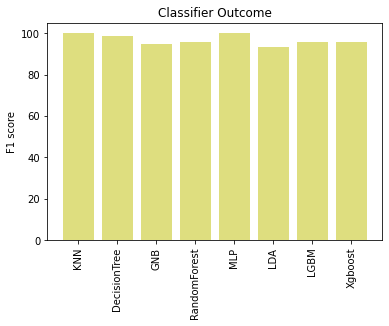

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [f1score_knn, f1score_dt, f1score_nb, f1score_rf, f1score_mlp,f1score_lda, f1score_lgbm, f1score_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='y')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('F1 score')
plt.title('Classifier Outcome')
plt.show()

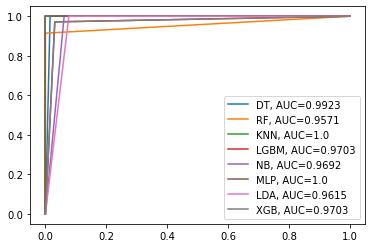

In [ ]:
#plotting the AUC of all models

# roc curve for classifiers before parameter tuning
fpr1, tpr1, _1 = roc_curve(y_test, preds_dt)
auc1 = round(roc_auc_score(y_test, preds_dt), 4)
plt.plot(fpr1,tpr1,label="DT, AUC="+str(auc1))

fpr2, tpr2, _2 = roc_curve(y_test,preds_rf)
auc2 = round(roc_auc_score(y_test, preds_rf), 4)
plt.plot(fpr2,tpr2,label="RF, AUC="+str(auc2))

fpr3, tpr3, _3 = roc_curve(y_test, preds_knn)
auc3 = round(roc_auc_score(y_test, preds_knn), 4)
plt.plot(fpr3,tpr3,label="KNN, AUC="+str(auc3))

fpr4, tpr4, _4 = roc_curve(y_test, preds_lgbm)
auc4 = round(roc_auc_score(y_test,preds_lgbm), 4)
plt.plot(fpr4,tpr4,label="LGBM, AUC="+str(auc4))

fpr5, tpr5, _5 = roc_curve(y_test, preds_nb)
auc5 = round(roc_auc_score(y_test, preds_nb), 4)
plt.plot(fpr5,tpr5,label="NB, AUC="+str(auc5))

fpr6, tpr6, _6 = roc_curve(y_test, preds_mlp)
auc6 = round(roc_auc_score(y_test, preds_mlp), 4)
plt.plot(fpr6,tpr6,label="MLP, AUC="+str(auc6))

fpr7, tpr7, _7 = roc_curve(y_test, preds_lda)
auc7 = round(roc_auc_score(y_test, preds_lda), 4)
plt.plot(fpr7,tpr7,label="LDA, AUC="+str(auc7))

fpr8, tpr8, _8 = roc_curve(y_test, preds_xgb)
auc8 = round(roc_auc_score(y_test, preds_xgb), 4)
plt.plot(fpr8,tpr8,label="XGB, AUC="+str(auc8))

plt.legend()


The cross validation results

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 0
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(GaussianNB())
classifiers.append(RandomForestClassifier())
classifiers.append(MLPClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier())
classifiers.append(XGBClassifier(use_label_encoder=False))

In [ ]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","DecisionTree","GNB",
"RandomForest","MLP","LDA","LGBM","Xgboost"]})

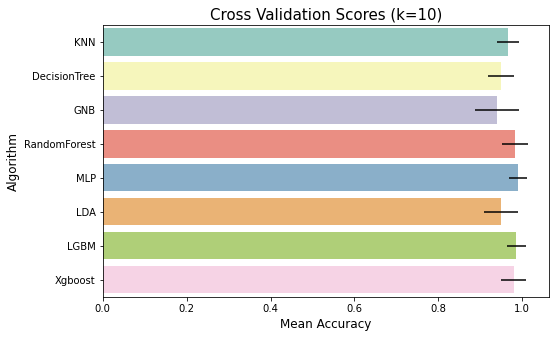

In [ ]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean Accuracy", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [ ]:
cv_res

CrossValMeans  CrossValerrors     Algorithm
0       0.966667        0.025820           KNN
1       0.950000        0.030732  DecisionTree
2       0.940000        0.053333           GNB
3       0.983333        0.030732  RandomForest
4       0.990000        0.021344           MLP
5       0.950000        0.040139           LDA
6       0.986667        0.022111          LGBM
7       0.980000        0.030551       Xgboost

# SFS feature selection

In [ ]:
y = df['class']
X = pd.DataFrame(robust_df, columns =['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count', 'hypertension',
       'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
       'pedal_edema', 'anemia'])

In [ ]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
dt = DecisionTreeClassifier()
sfs1 = SFS(dt, 
           k_features= 11, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10)
sfs1 = sfs1.fit(X, y)
sfs1.subsets_
# Which features?
feat_cols_sfs = list(sfs1.k_feature_idx_)
sfs1.k_score_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2022-12-11 18:37:47] Features: 1/11 -- score: 0.8825[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2022-12-11 18:37:47] Features: 2/11 -- score: 0.9524999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished

[2022-12-11 18:37:47] Features: 3/11 -- score: 0.9675[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:

0.9799999999999999

In [ ]:
y = y.values
X= X.values
# Train/test set generation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:, feat_cols_sfs], y, test_size=0.25, random_state=123)

Decision Tree Classifier

In [ ]:
# Grid search CV for Decision Tree before fs
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
grid_values = {'criterion':['gini','entropy'],
               'max_depth': np.arange(3, 15),
               'min_samples_leaf':np.arange(1, 5),
               'min_samples_split':np.arange(2, 10),
               'splitter':['best','random']
              }
grid_search_dt = GridSearchCV(dt, param_grid = grid_values, cv = 5, scoring = 'accuracy')
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96        65
         1.0       0.94      0.91      0.93        35

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.95      0.95       100



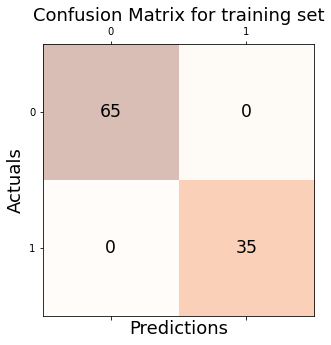

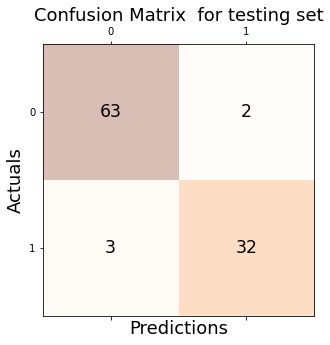

----------------- Overall Results -----------------
Accuracy Result for train set: 99.00%
Accuracy Result for test set: 95.00%
Precision Result: 94.12%
Recall Result: 91.43%
F1-Score Result: 92.75%
AUC Result:94.18%


In [ ]:
#Let's apply the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
DT = DecisionTreeClassifier(criterion = 'gini',random_state=123, splitter='random', 
                            max_depth=5,min_samples_leaf= 1, min_samples_split= 2)
DT.fit(X_train, y_train)
#prediction phase
preds_dt = DT.predict(X_test)

print(classification_report(y_test, preds_dt))


conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=DT.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, DT.predict(X_train))
acc_dt = accuracy_score(y_test, preds_dt)
precision_dt = precision_score(y_test, preds_dt)*100    
recall_dt= recall_score(y_test, preds_dt)*100    
f1score_dt = f1_score(y_test, preds_dt)*100

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_dt*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_dt))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_dt)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_dt)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_dt)*100))

K Neighbors Classifier

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        65
         1.0       0.97      0.97      0.97        35

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



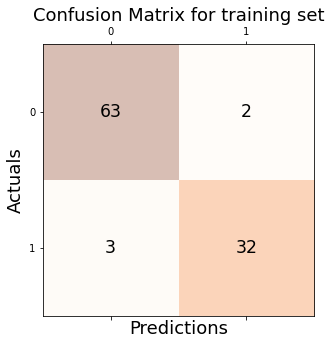

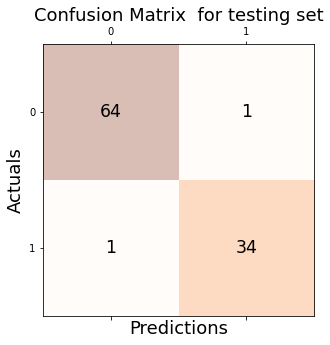

----------------- Overall Results -----------------
Accuracy Result for train set: 99.00%
Accuracy Result for test set: 98.00%
Precision Result: 97.14%
Recall Result: 97.14%
F1-Score Result: 97.14%
AUC Result:97.80%


In [ ]:
#let's apply KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
#predition phase
preds_knn=knn.predict(X_test)
print(classification_report(y_test, preds_knn))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=knn.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_knn)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, knn.predict(X_train))
acc_knn = accuracy_score(y_test, preds_knn)
precision_knn = precision_score(y_test, preds_knn)*100    
recall_knn= recall_score(y_test, preds_knn)*100    
f1score_knn = f1_score(y_test, preds_knn)*100
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_knn*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_knn))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_knn)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_knn)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_knn)*100))

LGBM Classifier

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix of training set:- 
[[185   0]
 [  0 115]]

Confusion Matrix testing set:- 
[[64  1]
 [ 0 35]]



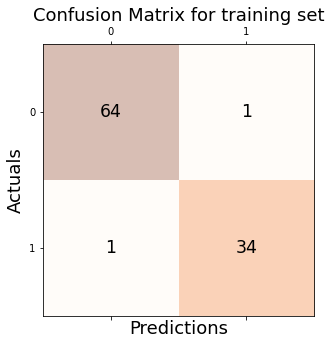

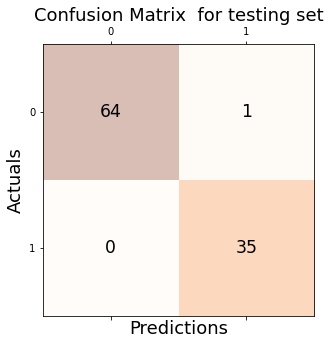

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 99.00%
Precision Result: 97.22%
Recall Result: 100.00%
F1-Score Result: 98.59%
AUC Result:99.23%


In [ ]:
# model fit
LGBM = LGBMClassifier(class_weight='balanced', n_estimators=800, random_state=84215, learning_rate=0.09,
                     reg_alpha=0.8, reg_lambda=0.2)
LGBM.fit(X_train, y_train)

# prediction
preds_lgbm = LGBM.predict(X_test)
print(classification_report(y_test, preds_lgbm))
print(f"Confusion Matrix of training set:- \n{confusion_matrix(y_train, LGBM.predict(X_train))}\n")
print(f"Confusion Matrix testing set:- \n{confusion_matrix(y_test, preds_lgbm)}\n")

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=LGBM.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lgbm)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, LGBM.predict(X_train))
acc_lgbm = accuracy_score(y_test, preds_lgbm)
precision_lgbm = precision_score(y_test, preds_lgbm)*100    
recall_lgbm = recall_score(y_test, preds_lgbm)*100    
f1score_lgbm = f1_score(y_test, preds_lgbm)*100    
print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lgbm*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lgbm))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lgbm)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lgbm)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lgbm)*100))

Gaussian NB

In [ ]:
#grid search for naive bayes algorithm
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 0.002848035868435802}

              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88        65
         1.0       0.71      1.00      0.83        35

    accuracy                           0.86       100
   macro avg       0.86      0.89      0.86       100
weighted avg       0.90      0.86      0.86       100



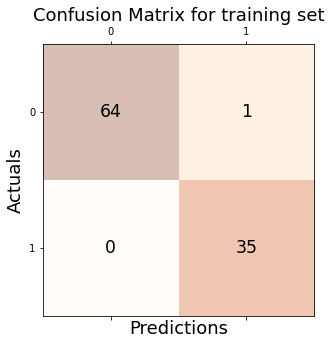

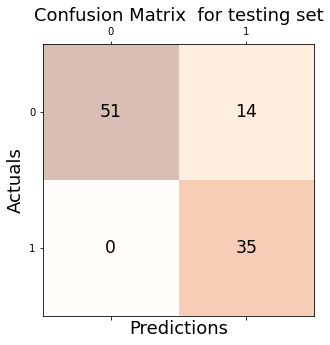

----------------- Overall Results -----------------
Accuracy Result for train set: 87.67%
Accuracy Result for test set: 86.00%
Precision Result: 71.43%
Recall Result: 100.00%
F1-Score Result: 83.33%
AUC Result:89.23%


In [ ]:
# model fit
NB = GaussianNB(var_smoothing= 0.02848035868435802)
NB.fit(X_train, y_train)

# prediction
preds_nb = NB.predict(X_test)
print(classification_report(y_test, preds_nb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=NB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_nb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, NB.predict(X_train))
acc_nb = accuracy_score(y_test, preds_nb)
precision_nb = precision_score(y_test, preds_nb)*100    
recall_nb = recall_score(y_test, preds_nb)*100    
f1score_nb = f1_score(y_test, preds_nb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_nb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_nb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_nb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_nb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_nb)*100))

Random Forest Classifier

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        65
         1.0       1.00      0.91      0.96        35

    accuracy                           0.97       100
   macro avg       0.98      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100



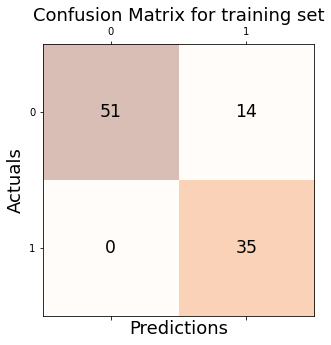

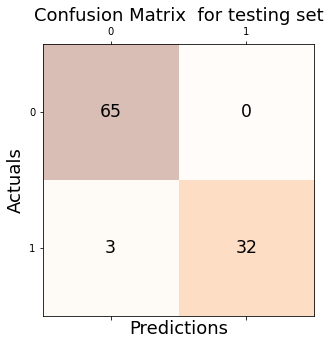

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 97.00%
Precision Result: 100.00%
Recall Result: 91.43%
F1-Score Result: 95.52%
AUC Result:95.71%


In [ ]:
# model fit
rf = RandomForestClassifier(n_estimators=500, criterion='gini')
rf.fit(X_train, y_train)

# prediction
preds_rf = rf.predict(X_test)
print(classification_report(y_test, preds_rf))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=rf.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_rf)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, rf.predict(X_train))
acc_rf = accuracy_score(y_test, preds_rf)
precision_rf = precision_score(y_test, preds_rf)*100    
recall_rf = recall_score(y_test, preds_rf)*100    
f1score_rf = f1_score(y_test, preds_rf)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_rf*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_rf))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_rf)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_rf)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_rf)*100))

Linear Discriminant Analysis

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        65
         1.0       0.83      1.00      0.91        35

    accuracy                           0.93       100
   macro avg       0.92      0.95      0.93       100
weighted avg       0.94      0.93      0.93       100



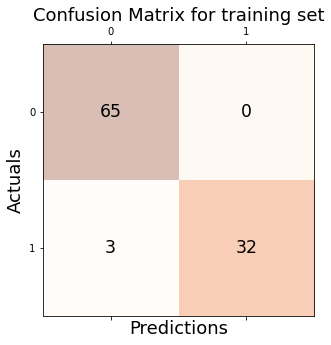

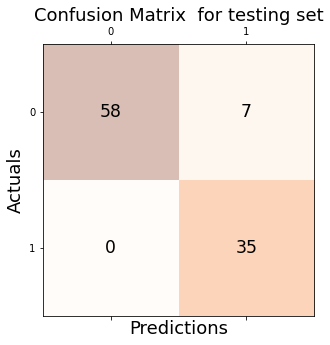

----------------- Overall Results -----------------
Accuracy Result for train set: 95.00%
Accuracy Result for test set: 93.00%
Precision Result: 83.33%
Recall Result: 100.00%
F1-Score Result: 90.91%
AUC Result:94.62%


In [ ]:
# model fit
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# prediction
preds_lda = lda.predict(X_test)
print(classification_report(y_test, preds_lda))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=lda.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lda)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, lda.predict(X_train))
acc_lda = accuracy_score(y_test, preds_lda)
precision_lda = precision_score(y_test, preds_lda)*100    
recall_lda = recall_score(y_test, preds_lda)*100    
f1score_lda = f1_score(y_test, preds_lda)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_lda*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_lda))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_lda)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_lda)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_lda)*100))

XGB Classifier

[18:37:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        65
         1.0       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



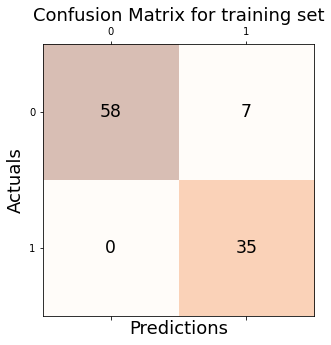

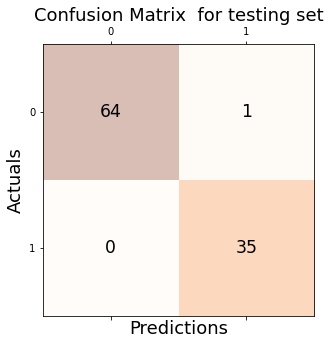

----------------- Overall Results -----------------
Accuracy Result for train set: 100.00%
Accuracy Result for test set: 99.00%
Precision Result: 97.22%
Recall Result: 100.00%
F1-Score Result: 98.59%
AUC Result:99.23%


In [ ]:
# model fit
XGB = XGBClassifier(n_estimators=500, learning_rate=0.5)
XGB.fit(X_train, y_train)

# prediction
preds_xgb = XGB.predict(X_test)
print(classification_report(y_test, preds_xgb))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=XGB.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_xgb)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()


acc_train = accuracy_score(y_train, XGB.predict(X_train))
acc_xgb = accuracy_score(y_test, preds_xgb)
precision_xgb = precision_score(y_test, preds_xgb)*100    
recall_xgb = recall_score(y_test, preds_xgb)*100    
f1score_xgb = f1_score(y_test, preds_xgb)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_xgb*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_xgb))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_xgb)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_xgb)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_xgb)*100))

MLP Classifier

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        65
         1.0       0.95      1.00      0.97        35

    accuracy                           0.98       100
   macro avg       0.97      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



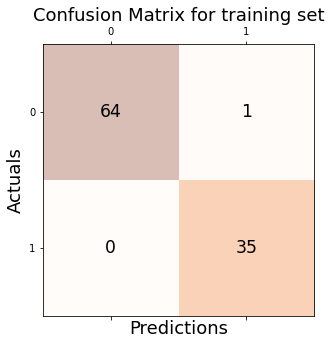

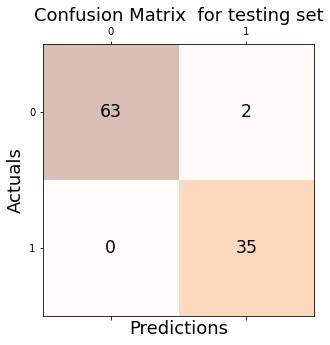

----------------- Overall Results -----------------
Accuracy Result for train set: 98.67%
Accuracy Result for test set: 98.00%
Precision Result: 94.59%
Recall Result: 100.00%
F1-Score Result: 97.22%
AUC Result:98.46%


In [ ]:
# model fit
MLP = MLPClassifier(random_state=84627)
MLP.fit(X_train, y_train)

# prediction
preds_mlp = MLP.predict(X_test)
print(classification_report(y_test, preds_mlp))

conf_matrix_train = confusion_matrix(y_true=y_train, y_pred=MLP.predict(X_train))
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_train, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_train.shape[0]):
    for j in range(conf_matrix_train.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_train[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for training set', fontsize=18)
plt.show()

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_mlp)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix  for testing set', fontsize=18)
plt.show()

acc_train = accuracy_score(y_train, MLP.predict(X_train))
acc_mlp = accuracy_score(y_test, preds_mlp)

precision_mlp = precision_score(y_test, preds_mlp)*100    
recall_mlp = recall_score(y_test, preds_mlp)*100    
f1score_mlp = f1_score(y_test, preds_mlp)*100    

print('----------------- Overall Results -----------------')
print('Accuracy Result for train set: %.2f%%'%(acc_train*100)) 
print('Accuracy Result for test set: %.2f%%'%(acc_mlp*100))                   
print('Precision Result: %.2f%%'%((precision_score(y_test, preds_mlp))*100))     
print('Recall Result: %.2f%%'%((recall_score(y_test, preds_mlp)*100)))      
print('F1-Score Result: %.2f%%'%((f1_score(y_test, preds_mlp)*100)))
print('AUC Result:%.2f%%'%(roc_auc_score(y_test, preds_mlp)*100))

Let's plot the results

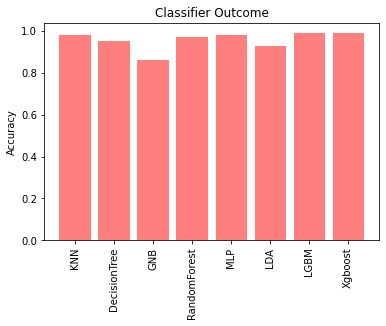

In [ ]:
#plotting the accuracy of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [acc_knn, acc_dt, acc_nb, acc_rf, acc_mlp, acc_lda, acc_lgbm, acc_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='r')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Classifier Outcome')
plt.show()

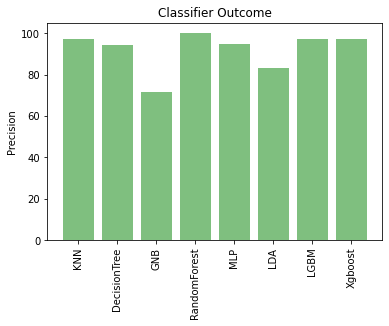

In [ ]:
#plotting the Precision of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [precision_knn, precision_dt, precision_nb, precision_rf, precision_mlp, precision_lda, precision_lgbm, precision_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='g')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Precision')
plt.title('Classifier Outcome')
plt.show()

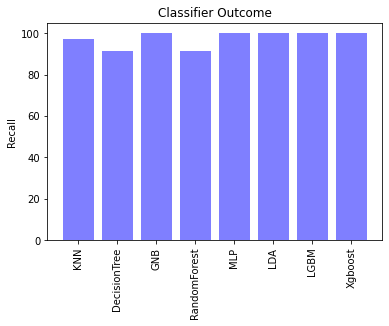

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [recall_knn, recall_dt, recall_nb, recall_rf, recall_mlp, recall_lda, recall_lgbm, recall_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='b')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('Recall')
plt.title('Classifier Outcome')
plt.show()

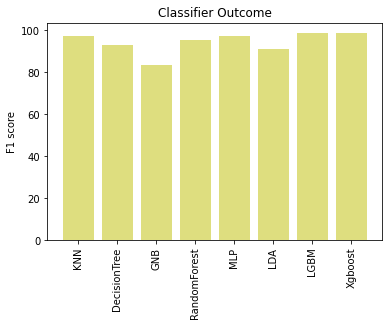

In [ ]:
#plotting the Recall of all models
objects = ("KNN","DecisionTree","GNB","RandomForest","MLP","LDA","LGBM","Xgboost")
x_pos = np.arange(len(objects))
accuracies1 = [f1score_knn, f1score_dt, f1score_nb, f1score_rf, f1score_mlp,f1score_lda, f1score_lgbm, f1score_xgb]
    
plt.bar(x_pos, accuracies1, align='center', alpha=0.5, color='y')
plt.xticks(x_pos, objects, rotation='vertical')
plt.ylabel('F1 score')
plt.title('Classifier Outcome')
plt.show()

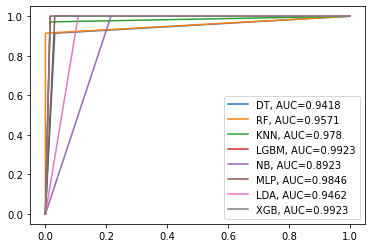

In [ ]:
#plotting the AUC of all models

# roc curve for classifiers before parameter tuning
fpr1, tpr1, _1 = roc_curve(y_test, preds_dt)
auc1 = round(roc_auc_score(y_test, preds_dt), 4)
plt.plot(fpr1,tpr1,label="DT, AUC="+str(auc1))

fpr2, tpr2, _2 = roc_curve(y_test,preds_rf)
auc2 = round(roc_auc_score(y_test, preds_rf), 4)
plt.plot(fpr2,tpr2,label="RF, AUC="+str(auc2))

fpr3, tpr3, _3 = roc_curve(y_test, preds_knn)
auc3 = round(roc_auc_score(y_test, preds_knn), 4)
plt.plot(fpr3,tpr3,label="KNN, AUC="+str(auc3))

fpr4, tpr4, _4 = roc_curve(y_test, preds_lgbm)
auc4 = round(roc_auc_score(y_test,preds_lgbm), 4)
plt.plot(fpr4,tpr4,label="LGBM, AUC="+str(auc4))

fpr5, tpr5, _5 = roc_curve(y_test, preds_nb)
auc5 = round(roc_auc_score(y_test, preds_nb), 4)
plt.plot(fpr5,tpr5,label="NB, AUC="+str(auc5))

fpr6, tpr6, _6 = roc_curve(y_test, preds_mlp)
auc6 = round(roc_auc_score(y_test, preds_mlp), 4)
plt.plot(fpr6,tpr6,label="MLP, AUC="+str(auc6))

fpr7, tpr7, _7 = roc_curve(y_test, preds_lda)
auc7 = round(roc_auc_score(y_test, preds_lda), 4)
plt.plot(fpr7,tpr7,label="LDA, AUC="+str(auc7))

fpr8, tpr8, _8 = roc_curve(y_test, preds_xgb)
auc8 = round(roc_auc_score(y_test, preds_xgb), 4)
plt.plot(fpr8,tpr8,label="XGB, AUC="+str(auc8))

plt.legend()


The cross validation results

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 0
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(GaussianNB())
classifiers.append(RandomForestClassifier())
classifiers.append(MLPClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LGBMClassifier())
classifiers.append(XGBClassifier(use_label_encoder=False))

In [ ]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["KNN","DecisionTree","GNB",
"RandomForest","MLP","LDA","LGBM","Xgboost"]})

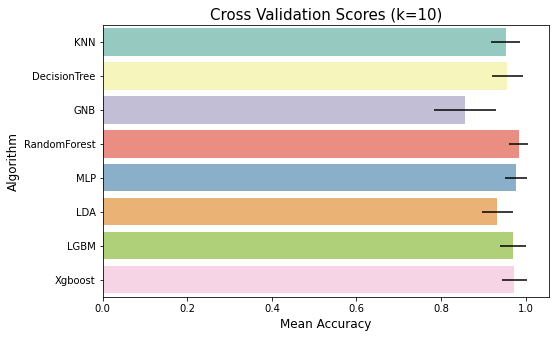

In [ ]:
plt.figure(figsize = (8,5))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_ylabel("Algorithm", fontsize = 12)
g.set_xlabel("Mean Accuracy", fontsize = 12)
g = g.set_title("Cross Validation Scores (k=10)", fontsize=15)
plt.show()

In [ ]:
cv_res

CrossValMeans  CrossValerrors     Algorithm
0       0.953333        0.033993           KNN
1       0.956667        0.036667  DecisionTree
2       0.856667        0.073106           GNB
3       0.983333        0.022361  RandomForest
4       0.976667        0.026034           MLP
5       0.933333        0.036515           LDA
6       0.970000        0.031447          LGBM
7       0.973333        0.029059       Xgboost